In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0,
    'binarize'      : True,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_0


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3737275, 828)
(3737275, 7)
validation
(449225, 828)
(449225, 7)
test
(529121, 828)
(529121, 7)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 7)                 903       


Total params: 1538823 (5.87 MB)


Trainable params: 1538823 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/374 [..............................] - ETA: 11:39 - loss: 1.9742 - STD: 0.0540 - MAE: 0.2434

  3/374 [..............................] - ETA: 10s - loss: 1.9425 - STD: 0.0493 - MAE: 0.2421  

  5/374 [..............................] - ETA: 9s - loss: 1.9389 - STD: 0.0502 - MAE: 0.2418 

  7/374 [..............................] - ETA: 9s - loss: 1.9313 - STD: 0.0476 - MAE: 0.2417

  9/374 [..............................] - ETA: 9s - loss: 1.9255 - STD: 0.0452 - MAE: 0.2416

 11/374 [..............................] - ETA: 9s - loss: 1.9216 - STD: 0.0445 - MAE: 0.2415

 13/374 [>.............................] - ETA: 9s - loss: 1.9158 - STD: 0.0440 - MAE: 0.2413

 15/374 [>.............................] - ETA: 9s - loss: 1.9083 - STD: 0.0439 - MAE: 0.2409

 17/374 [>.............................] - ETA: 9s - loss: 1.8999 - STD: 0.0448 - MAE: 0.2404

 19/374 [>.............................] - ETA: 9s - loss: 1.8901 - STD: 0.0469 - MAE: 0.2396

 21/374 [>.............................] - ETA: 9s - loss: 1.8802 - STD: 0.0498 - MAE: 0.2388

 23/374 [>.............................] - ETA: 9s - loss: 1.8701 - STD: 0.0529 - MAE: 0.2378

 25/374 [=>............................] - ETA: 9s - loss: 1.8608 - STD: 0.0558 - MAE: 0.2370

 27/374 [=>............................] - ETA: 9s - loss: 1.8508 - STD: 0.0585 - MAE: 0.2361

 29/374 [=>............................] - ETA: 8s - loss: 1.8408 - STD: 0.0610 - MAE: 0.2353

 31/374 [=>............................] - ETA: 8s - loss: 1.8310 - STD: 0.0633 - MAE: 0.2345

 33/374 [=>............................] - ETA: 8s - loss: 1.8215 - STD: 0.0654 - MAE: 0.2338

 35/374 [=>............................] - ETA: 8s - loss: 1.8120 - STD: 0.0673 - MAE: 0.2331

 37/374 [=>............................] - ETA: 8s - loss: 1.8022 - STD: 0.0695 - MAE: 0.2323

 39/374 [==>...........................] - ETA: 8s - loss: 1.7926 - STD: 0.0715 - MAE: 0.2315

 41/374 [==>...........................] - ETA: 8s - loss: 1.7824 - STD: 0.0737 - MAE: 0.2307

 43/374 [==>...........................] - ETA: 8s - loss: 1.7721 - STD: 0.0756 - MAE: 0.2299

 45/374 [==>...........................] - ETA: 8s - loss: 1.7614 - STD: 0.0775 - MAE: 0.2291

 47/374 [==>...........................] - ETA: 8s - loss: 1.7505 - STD: 0.0797 - MAE: 0.2282

 49/374 [==>...........................] - ETA: 8s - loss: 1.7398 - STD: 0.0818 - MAE: 0.2273

 52/374 [===>..........................] - ETA: 8s - loss: 1.7236 - STD: 0.0849 - MAE: 0.2259

 54/374 [===>..........................] - ETA: 8s - loss: 1.7130 - STD: 0.0869 - MAE: 0.2250

 56/374 [===>..........................] - ETA: 8s - loss: 1.7021 - STD: 0.0891 - MAE: 0.2240

 58/374 [===>..........................] - ETA: 8s - loss: 1.6914 - STD: 0.0911 - MAE: 0.2231

 61/374 [===>..........................] - ETA: 8s - loss: 1.6760 - STD: 0.0940 - MAE: 0.2217

 63/374 [====>.........................] - ETA: 8s - loss: 1.6661 - STD: 0.0959 - MAE: 0.2209

 66/374 [====>.........................] - ETA: 7s - loss: 1.6517 - STD: 0.0986 - MAE: 0.2196

 68/374 [====>.........................] - ETA: 7s - loss: 1.6425 - STD: 0.1004 - MAE: 0.2188

 70/374 [====>.........................] - ETA: 7s - loss: 1.6337 - STD: 0.1021 - MAE: 0.2180

 72/374 [====>.........................] - ETA: 7s - loss: 1.6250 - STD: 0.1038 - MAE: 0.2172

 74/374 [====>.........................] - ETA: 7s - loss: 1.6167 - STD: 0.1053 - MAE: 0.2164

 76/374 [=====>........................] - ETA: 7s - loss: 1.6084 - STD: 0.1069 - MAE: 0.2157

 78/374 [=====>........................] - ETA: 7s - loss: 1.6005 - STD: 0.1084 - MAE: 0.2150

 80/374 [=====>........................] - ETA: 7s - loss: 1.5929 - STD: 0.1099 - MAE: 0.2143

 82/374 [=====>........................] - ETA: 7s - loss: 1.5855 - STD: 0.1113 - MAE: 0.2136

 84/374 [=====>........................] - ETA: 7s - loss: 1.5784 - STD: 0.1126 - MAE: 0.2130

 86/374 [=====>........................] - ETA: 7s - loss: 1.5715 - STD: 0.1139 - MAE: 0.2123

 88/374 [======>.......................] - ETA: 7s - loss: 1.5649 - STD: 0.1152 - MAE: 0.2117

 90/374 [======>.......................] - ETA: 7s - loss: 1.5584 - STD: 0.1164 - MAE: 0.2111

 92/374 [======>.......................] - ETA: 7s - loss: 1.5519 - STD: 0.1176 - MAE: 0.2105

 94/374 [======>.......................] - ETA: 7s - loss: 1.5457 - STD: 0.1187 - MAE: 0.2099

 96/374 [======>.......................] - ETA: 7s - loss: 1.5398 - STD: 0.1198 - MAE: 0.2094

 98/374 [======>.......................] - ETA: 7s - loss: 1.5339 - STD: 0.1209 - MAE: 0.2088

100/374 [=======>......................] - ETA: 7s - loss: 1.5282 - STD: 0.1220 - MAE: 0.2083

102/374 [=======>......................] - ETA: 7s - loss: 1.5228 - STD: 0.1230 - MAE: 0.2077

104/374 [=======>......................] - ETA: 7s - loss: 1.5174 - STD: 0.1240 - MAE: 0.2073

106/374 [=======>......................] - ETA: 6s - loss: 1.5125 - STD: 0.1249 - MAE: 0.2068

108/374 [=======>......................] - ETA: 6s - loss: 1.5072 - STD: 0.1259 - MAE: 0.2063

110/374 [=======>......................] - ETA: 6s - loss: 1.5025 - STD: 0.1268 - MAE: 0.2058

112/374 [=======>......................] - ETA: 6s - loss: 1.4979 - STD: 0.1277 - MAE: 0.2054

114/374 [========>.....................] - ETA: 6s - loss: 1.4932 - STD: 0.1285 - MAE: 0.2049

116/374 [========>.....................] - ETA: 6s - loss: 1.4887 - STD: 0.1293 - MAE: 0.2045

118/374 [========>.....................] - ETA: 6s - loss: 1.4845 - STD: 0.1301 - MAE: 0.2041

120/374 [========>.....................] - ETA: 6s - loss: 1.4802 - STD: 0.1310 - MAE: 0.2037

122/374 [========>.....................] - ETA: 6s - loss: 1.4760 - STD: 0.1317 - MAE: 0.2033

124/374 [========>.....................] - ETA: 6s - loss: 1.4717 - STD: 0.1325 - MAE: 0.2028

126/374 [=========>....................] - ETA: 6s - loss: 1.4675 - STD: 0.1333 - MAE: 0.2024

128/374 [=========>....................] - ETA: 6s - loss: 1.4636 - STD: 0.1340 - MAE: 0.2021

130/374 [=========>....................] - ETA: 6s - loss: 1.4596 - STD: 0.1347 - MAE: 0.2017

133/374 [=========>....................] - ETA: 6s - loss: 1.4539 - STD: 0.1357 - MAE: 0.2011

135/374 [=========>....................] - ETA: 6s - loss: 1.4502 - STD: 0.1364 - MAE: 0.2007

137/374 [=========>....................] - ETA: 6s - loss: 1.4465 - STD: 0.1371 - MAE: 0.2004

140/374 [==========>...................] - ETA: 6s - loss: 1.4408 - STD: 0.1381 - MAE: 0.1998

143/374 [==========>...................] - ETA: 5s - loss: 1.4356 - STD: 0.1391 - MAE: 0.1992

146/374 [==========>...................] - ETA: 5s - loss: 1.4304 - STD: 0.1400 - MAE: 0.1987

148/374 [==========>...................] - ETA: 5s - loss: 1.4270 - STD: 0.1407 - MAE: 0.1984

151/374 [===========>..................] - ETA: 5s - loss: 1.4221 - STD: 0.1417 - MAE: 0.1979

153/374 [===========>..................] - ETA: 5s - loss: 1.4188 - STD: 0.1423 - MAE: 0.1975

155/374 [===========>..................] - ETA: 5s - loss: 1.4157 - STD: 0.1429 - MAE: 0.1972

157/374 [===========>..................] - ETA: 5s - loss: 1.4125 - STD: 0.1434 - MAE: 0.1969

159/374 [===========>..................] - ETA: 5s - loss: 1.4094 - STD: 0.1440 - MAE: 0.1965

161/374 [===========>..................] - ETA: 5s - loss: 1.4063 - STD: 0.1446 - MAE: 0.1962

163/374 [============>.................] - ETA: 5s - loss: 1.4032 - STD: 0.1451 - MAE: 0.1959

165/374 [============>.................] - ETA: 5s - loss: 1.4003 - STD: 0.1457 - MAE: 0.1956

167/374 [============>.................] - ETA: 5s - loss: 1.3976 - STD: 0.1463 - MAE: 0.1953

170/374 [============>.................] - ETA: 5s - loss: 1.3938 - STD: 0.1471 - MAE: 0.1949

172/374 [============>.................] - ETA: 5s - loss: 1.3909 - STD: 0.1476 - MAE: 0.1946

174/374 [============>.................] - ETA: 5s - loss: 1.3882 - STD: 0.1481 - MAE: 0.1943

176/374 [=============>................] - ETA: 5s - loss: 1.3854 - STD: 0.1486 - MAE: 0.1940

178/374 [=============>................] - ETA: 5s - loss: 1.3827 - STD: 0.1491 - MAE: 0.1937

180/374 [=============>................] - ETA: 5s - loss: 1.3801 - STD: 0.1495 - MAE: 0.1934

182/374 [=============>................] - ETA: 4s - loss: 1.3775 - STD: 0.1500 - MAE: 0.1932

184/374 [=============>................] - ETA: 4s - loss: 1.3750 - STD: 0.1505 - MAE: 0.1929

187/374 [==============>...............] - ETA: 4s - loss: 1.3713 - STD: 0.1512 - MAE: 0.1925

189/374 [==============>...............] - ETA: 4s - loss: 1.3688 - STD: 0.1516 - MAE: 0.1922

191/374 [==============>...............] - ETA: 4s - loss: 1.3664 - STD: 0.1521 - MAE: 0.1920

193/374 [==============>...............] - ETA: 4s - loss: 1.3639 - STD: 0.1525 - MAE: 0.1917

195/374 [==============>...............] - ETA: 4s - loss: 1.3615 - STD: 0.1529 - MAE: 0.1915

197/374 [==============>...............] - ETA: 4s - loss: 1.3593 - STD: 0.1534 - MAE: 0.1912

199/374 [==============>...............] - ETA: 4s - loss: 1.3569 - STD: 0.1538 - MAE: 0.1910

201/374 [===============>..............] - ETA: 4s - loss: 1.3545 - STD: 0.1542 - MAE: 0.1907

203/374 [===============>..............] - ETA: 4s - loss: 1.3523 - STD: 0.1546 - MAE: 0.1905

205/374 [===============>..............] - ETA: 4s - loss: 1.3501 - STD: 0.1550 - MAE: 0.1902

207/374 [===============>..............] - ETA: 4s - loss: 1.3480 - STD: 0.1554 - MAE: 0.1900

209/374 [===============>..............] - ETA: 4s - loss: 1.3458 - STD: 0.1558 - MAE: 0.1898

211/374 [===============>..............] - ETA: 4s - loss: 1.3437 - STD: 0.1562 - MAE: 0.1896

214/374 [================>.............] - ETA: 4s - loss: 1.3406 - STD: 0.1568 - MAE: 0.1892

217/374 [================>.............] - ETA: 4s - loss: 1.3375 - STD: 0.1573 - MAE: 0.1889

219/374 [================>.............] - ETA: 4s - loss: 1.3354 - STD: 0.1577 - MAE: 0.1887

221/374 [================>.............] - ETA: 3s - loss: 1.3334 - STD: 0.1581 - MAE: 0.1884

224/374 [================>.............] - ETA: 3s - loss: 1.3305 - STD: 0.1587 - MAE: 0.1881

227/374 [=================>............] - ETA: 3s - loss: 1.3275 - STD: 0.1592 - MAE: 0.1878

229/374 [=================>............] - ETA: 3s - loss: 1.3256 - STD: 0.1595 - MAE: 0.1876

231/374 [=================>............] - ETA: 3s - loss: 1.3237 - STD: 0.1599 - MAE: 0.1874

233/374 [=================>............] - ETA: 3s - loss: 1.3218 - STD: 0.1602 - MAE: 0.1872

235/374 [=================>............] - ETA: 3s - loss: 1.3199 - STD: 0.1605 - MAE: 0.1870

237/374 [==================>...........] - ETA: 3s - loss: 1.3181 - STD: 0.1609 - MAE: 0.1868

239/374 [==================>...........] - ETA: 3s - loss: 1.3163 - STD: 0.1612 - MAE: 0.1866

241/374 [==================>...........] - ETA: 3s - loss: 1.3146 - STD: 0.1615 - MAE: 0.1864

243/374 [==================>...........] - ETA: 3s - loss: 1.3127 - STD: 0.1618 - MAE: 0.1862

245/374 [==================>...........] - ETA: 3s - loss: 1.3109 - STD: 0.1622 - MAE: 0.1860

247/374 [==================>...........] - ETA: 3s - loss: 1.3092 - STD: 0.1625 - MAE: 0.1858

249/374 [==================>...........] - ETA: 3s - loss: 1.3073 - STD: 0.1628 - MAE: 0.1856

251/374 [===================>..........] - ETA: 3s - loss: 1.3056 - STD: 0.1631 - MAE: 0.1854

253/374 [===================>..........] - ETA: 3s - loss: 1.3039 - STD: 0.1634 - MAE: 0.1852

255/374 [===================>..........] - ETA: 3s - loss: 1.3022 - STD: 0.1637 - MAE: 0.1851

257/374 [===================>..........] - ETA: 3s - loss: 1.3006 - STD: 0.1640 - MAE: 0.1849

259/374 [===================>..........] - ETA: 2s - loss: 1.2990 - STD: 0.1643 - MAE: 0.1847

261/374 [===================>..........] - ETA: 2s - loss: 1.2973 - STD: 0.1646 - MAE: 0.1845

263/374 [====================>.........] - ETA: 2s - loss: 1.2957 - STD: 0.1649 - MAE: 0.1843

265/374 [====================>.........] - ETA: 2s - loss: 1.2941 - STD: 0.1652 - MAE: 0.1842

267/374 [====================>.........] - ETA: 2s - loss: 1.2925 - STD: 0.1655 - MAE: 0.1840

269/374 [====================>.........] - ETA: 2s - loss: 1.2910 - STD: 0.1657 - MAE: 0.1838

271/374 [====================>.........] - ETA: 2s - loss: 1.2897 - STD: 0.1660 - MAE: 0.1837

273/374 [====================>.........] - ETA: 2s - loss: 1.2882 - STD: 0.1663 - MAE: 0.1835

275/374 [=====================>........] - ETA: 2s - loss: 1.2867 - STD: 0.1666 - MAE: 0.1833

277/374 [=====================>........] - ETA: 2s - loss: 1.2853 - STD: 0.1669 - MAE: 0.1832

279/374 [=====================>........] - ETA: 2s - loss: 1.2839 - STD: 0.1671 - MAE: 0.1830

281/374 [=====================>........] - ETA: 2s - loss: 1.2824 - STD: 0.1674 - MAE: 0.1828

283/374 [=====================>........] - ETA: 2s - loss: 1.2811 - STD: 0.1676 - MAE: 0.1827

285/374 [=====================>........] - ETA: 2s - loss: 1.2797 - STD: 0.1679 - MAE: 0.1825

287/374 [======================>.......] - ETA: 2s - loss: 1.2782 - STD: 0.1681 - MAE: 0.1824

289/374 [======================>.......] - ETA: 2s - loss: 1.2768 - STD: 0.1684 - MAE: 0.1822

291/374 [======================>.......] - ETA: 2s - loss: 1.2753 - STD: 0.1686 - MAE: 0.1821

293/374 [======================>.......] - ETA: 2s - loss: 1.2738 - STD: 0.1689 - MAE: 0.1819

295/374 [======================>.......] - ETA: 2s - loss: 1.2724 - STD: 0.1691 - MAE: 0.1817

298/374 [======================>.......] - ETA: 1s - loss: 1.2703 - STD: 0.1695 - MAE: 0.1815

300/374 [=======================>......] - ETA: 1s - loss: 1.2689 - STD: 0.1697 - MAE: 0.1814

302/374 [=======================>......] - ETA: 1s - loss: 1.2676 - STD: 0.1700 - MAE: 0.1812

304/374 [=======================>......] - ETA: 1s - loss: 1.2663 - STD: 0.1702 - MAE: 0.1811

307/374 [=======================>......] - ETA: 1s - loss: 1.2644 - STD: 0.1706 - MAE: 0.1809

310/374 [=======================>......] - ETA: 1s - loss: 1.2624 - STD: 0.1709 - MAE: 0.1806

312/374 [========================>.....] - ETA: 1s - loss: 1.2611 - STD: 0.1711 - MAE: 0.1805

314/374 [========================>.....] - ETA: 1s - loss: 1.2599 - STD: 0.1714 - MAE: 0.1804

316/374 [========================>.....] - ETA: 1s - loss: 1.2585 - STD: 0.1716 - MAE: 0.1802

318/374 [========================>.....] - ETA: 1s - loss: 1.2572 - STD: 0.1718 - MAE: 0.1801

320/374 [========================>.....] - ETA: 1s - loss: 1.2559 - STD: 0.1720 - MAE: 0.1799

322/374 [========================>.....] - ETA: 1s - loss: 1.2547 - STD: 0.1722 - MAE: 0.1798

324/374 [========================>.....] - ETA: 1s - loss: 1.2534 - STD: 0.1725 - MAE: 0.1797

327/374 [=========================>....] - ETA: 1s - loss: 1.2516 - STD: 0.1728 - MAE: 0.1795

329/374 [=========================>....] - ETA: 1s - loss: 1.2503 - STD: 0.1730 - MAE: 0.1793

331/374 [=========================>....] - ETA: 1s - loss: 1.2491 - STD: 0.1732 - MAE: 0.1792

333/374 [=========================>....] - ETA: 1s - loss: 1.2479 - STD: 0.1734 - MAE: 0.1790

335/374 [=========================>....] - ETA: 1s - loss: 1.2467 - STD: 0.1736 - MAE: 0.1789

337/374 [==========================>...] - ETA: 0s - loss: 1.2455 - STD: 0.1738 - MAE: 0.1788

338/374 [==========================>...] - ETA: 1s - loss: 1.2450 - STD: 0.1739 - MAE: 0.1787

340/374 [==========================>...] - ETA: 0s - loss: 1.2438 - STD: 0.1741 - MAE: 0.1786

342/374 [==========================>...] - ETA: 0s - loss: 1.2426 - STD: 0.1743 - MAE: 0.1784

345/374 [==========================>...] - ETA: 0s - loss: 1.2409 - STD: 0.1746 - MAE: 0.1783

348/374 [==========================>...] - ETA: 0s - loss: 1.2392 - STD: 0.1749 - MAE: 0.1781

350/374 [===========================>..] - ETA: 0s - loss: 1.2380 - STD: 0.1751 - MAE: 0.1779

352/374 [===========================>..] - ETA: 0s - loss: 1.2369 - STD: 0.1753 - MAE: 0.1778

354/374 [===========================>..] - ETA: 0s - loss: 1.2358 - STD: 0.1755 - MAE: 0.1777

356/374 [===========================>..] - ETA: 0s - loss: 1.2347 - STD: 0.1757 - MAE: 0.1776

358/374 [===========================>..] - ETA: 0s - loss: 1.2335 - STD: 0.1759 - MAE: 0.1774

360/374 [===========================>..] - ETA: 0s - loss: 1.2324 - STD: 0.1761 - MAE: 0.1773

362/374 [============================>.] - ETA: 0s - loss: 1.2314 - STD: 0.1763 - MAE: 0.1772

364/374 [============================>.] - ETA: 0s - loss: 1.2303 - STD: 0.1764 - MAE: 0.1771

366/374 [============================>.] - ETA: 0s - loss: 1.2292 - STD: 0.1766 - MAE: 0.1770

368/374 [============================>.] - ETA: 0s - loss: 1.2280 - STD: 0.1768 - MAE: 0.1768

370/374 [============================>.] - ETA: 0s - loss: 1.2271 - STD: 0.1770 - MAE: 0.1767

372/374 [============================>.] - ETA: 0s - loss: 1.2260 - STD: 0.1772 - MAE: 0.1766

374/374 [==============================] - ETA: 0s - loss: 1.2249 - STD: 0.1774 - MAE: 0.1765

374/374 [==============================] - 14s 33ms/step - loss: 1.2249 - STD: 0.1774 - MAE: 0.1765 - val_loss: 1.1136 - val_STD: 0.2105 - val_MAE: 0.1553


Epoch 2/10000


  1/374 [..............................] - ETA: 20s - loss: 1.0240 - STD: 0.2104 - MAE: 0.1546

  3/374 [..............................] - ETA: 9s - loss: 1.0397 - STD: 0.2100 - MAE: 0.1558 

  5/374 [..............................] - ETA: 9s - loss: 1.0323 - STD: 0.2106 - MAE: 0.1551

  7/374 [..............................] - ETA: 9s - loss: 1.0302 - STD: 0.2108 - MAE: 0.1549

  9/374 [..............................] - ETA: 9s - loss: 1.0343 - STD: 0.2111 - MAE: 0.1551

 11/374 [..............................] - ETA: 9s - loss: 1.0370 - STD: 0.2117 - MAE: 0.1549

 13/374 [>.............................] - ETA: 9s - loss: 1.0399 - STD: 0.2111 - MAE: 0.1554

 15/374 [>.............................] - ETA: 9s - loss: 1.0431 - STD: 0.2110 - MAE: 0.1556

 17/374 [>.............................] - ETA: 9s - loss: 1.0432 - STD: 0.2108 - MAE: 0.1557

 19/374 [>.............................] - ETA: 9s - loss: 1.0429 - STD: 0.2106 - MAE: 0.1558

 21/374 [>.............................] - ETA: 9s - loss: 1.0435 - STD: 0.2108 - MAE: 0.1557

 23/374 [>.............................] - ETA: 9s - loss: 1.0444 - STD: 0.2105 - MAE: 0.1559

 25/374 [=>............................] - ETA: 9s - loss: 1.0451 - STD: 0.2105 - MAE: 0.1559

 28/374 [=>............................] - ETA: 8s - loss: 1.0442 - STD: 0.2104 - MAE: 0.1559

 30/374 [=>............................] - ETA: 8s - loss: 1.0424 - STD: 0.2104 - MAE: 0.1558

 32/374 [=>............................] - ETA: 8s - loss: 1.0418 - STD: 0.2105 - MAE: 0.1557

 34/374 [=>............................] - ETA: 8s - loss: 1.0408 - STD: 0.2105 - MAE: 0.1557

 36/374 [=>............................] - ETA: 8s - loss: 1.0401 - STD: 0.2105 - MAE: 0.1557

 38/374 [==>...........................] - ETA: 8s - loss: 1.0390 - STD: 0.2105 - MAE: 0.1556

 40/374 [==>...........................] - ETA: 8s - loss: 1.0374 - STD: 0.2106 - MAE: 0.1555

 42/374 [==>...........................] - ETA: 8s - loss: 1.0362 - STD: 0.2106 - MAE: 0.1554

 44/374 [==>...........................] - ETA: 8s - loss: 1.0350 - STD: 0.2107 - MAE: 0.1553

 46/374 [==>...........................] - ETA: 8s - loss: 1.0333 - STD: 0.2108 - MAE: 0.1551

 48/374 [==>...........................] - ETA: 8s - loss: 1.0322 - STD: 0.2110 - MAE: 0.1550

 50/374 [===>..........................] - ETA: 8s - loss: 1.0312 - STD: 0.2110 - MAE: 0.1549

 52/374 [===>..........................] - ETA: 8s - loss: 1.0300 - STD: 0.2111 - MAE: 0.1548

 54/374 [===>..........................] - ETA: 8s - loss: 1.0294 - STD: 0.2112 - MAE: 0.1548

 56/374 [===>..........................] - ETA: 8s - loss: 1.0284 - STD: 0.2112 - MAE: 0.1547

 59/374 [===>..........................] - ETA: 8s - loss: 1.0271 - STD: 0.2114 - MAE: 0.1545

 61/374 [===>..........................] - ETA: 8s - loss: 1.0260 - STD: 0.2115 - MAE: 0.1544

 63/374 [====>.........................] - ETA: 8s - loss: 1.0255 - STD: 0.2115 - MAE: 0.1543

 65/374 [====>.........................] - ETA: 7s - loss: 1.0250 - STD: 0.2116 - MAE: 0.1543

 67/374 [====>.........................] - ETA: 7s - loss: 1.0243 - STD: 0.2117 - MAE: 0.1542

 70/374 [====>.........................] - ETA: 7s - loss: 1.0241 - STD: 0.2117 - MAE: 0.1541

 72/374 [====>.........................] - ETA: 7s - loss: 1.0238 - STD: 0.2118 - MAE: 0.1541

 74/374 [====>.........................] - ETA: 7s - loss: 1.0236 - STD: 0.2119 - MAE: 0.1540

 76/374 [=====>........................] - ETA: 7s - loss: 1.0236 - STD: 0.2120 - MAE: 0.1540

 78/374 [=====>........................] - ETA: 7s - loss: 1.0235 - STD: 0.2120 - MAE: 0.1540

 80/374 [=====>........................] - ETA: 7s - loss: 1.0236 - STD: 0.2121 - MAE: 0.1540

 82/374 [=====>........................] - ETA: 7s - loss: 1.0237 - STD: 0.2121 - MAE: 0.1540

 84/374 [=====>........................] - ETA: 7s - loss: 1.0231 - STD: 0.2122 - MAE: 0.1539

 86/374 [=====>........................] - ETA: 7s - loss: 1.0227 - STD: 0.2122 - MAE: 0.1539

 88/374 [======>.......................] - ETA: 7s - loss: 1.0224 - STD: 0.2123 - MAE: 0.1538

 90/374 [======>.......................] - ETA: 7s - loss: 1.0221 - STD: 0.2123 - MAE: 0.1538

 92/374 [======>.......................] - ETA: 7s - loss: 1.0219 - STD: 0.2123 - MAE: 0.1538

 94/374 [======>.......................] - ETA: 7s - loss: 1.0212 - STD: 0.2124 - MAE: 0.1537

 96/374 [======>.......................] - ETA: 7s - loss: 1.0207 - STD: 0.2124 - MAE: 0.1537

 98/374 [======>.......................] - ETA: 7s - loss: 1.0202 - STD: 0.2125 - MAE: 0.1536

100/374 [=======>......................] - ETA: 7s - loss: 1.0195 - STD: 0.2125 - MAE: 0.1535

102/374 [=======>......................] - ETA: 7s - loss: 1.0190 - STD: 0.2125 - MAE: 0.1535

104/374 [=======>......................] - ETA: 6s - loss: 1.0186 - STD: 0.2126 - MAE: 0.1535

106/374 [=======>......................] - ETA: 6s - loss: 1.0179 - STD: 0.2127 - MAE: 0.1534

109/374 [=======>......................] - ETA: 6s - loss: 1.0172 - STD: 0.2127 - MAE: 0.1533

111/374 [=======>......................] - ETA: 6s - loss: 1.0168 - STD: 0.2128 - MAE: 0.1533

113/374 [========>.....................] - ETA: 6s - loss: 1.0164 - STD: 0.2128 - MAE: 0.1532

115/374 [========>.....................] - ETA: 6s - loss: 1.0160 - STD: 0.2129 - MAE: 0.1532

117/374 [========>.....................] - ETA: 6s - loss: 1.0153 - STD: 0.2129 - MAE: 0.1531

119/374 [========>.....................] - ETA: 6s - loss: 1.0149 - STD: 0.2130 - MAE: 0.1531

121/374 [========>.....................] - ETA: 6s - loss: 1.0143 - STD: 0.2130 - MAE: 0.1530

123/374 [========>.....................] - ETA: 6s - loss: 1.0138 - STD: 0.2131 - MAE: 0.1530

125/374 [=========>....................] - ETA: 6s - loss: 1.0137 - STD: 0.2131 - MAE: 0.1529

127/374 [=========>....................] - ETA: 6s - loss: 1.0132 - STD: 0.2132 - MAE: 0.1529

129/374 [=========>....................] - ETA: 6s - loss: 1.0129 - STD: 0.2132 - MAE: 0.1528

131/374 [=========>....................] - ETA: 6s - loss: 1.0124 - STD: 0.2133 - MAE: 0.1528

133/374 [=========>....................] - ETA: 6s - loss: 1.0119 - STD: 0.2134 - MAE: 0.1527

135/374 [=========>....................] - ETA: 6s - loss: 1.0115 - STD: 0.2134 - MAE: 0.1527

137/374 [=========>....................] - ETA: 6s - loss: 1.0110 - STD: 0.2135 - MAE: 0.1526

139/374 [==========>...................] - ETA: 6s - loss: 1.0108 - STD: 0.2136 - MAE: 0.1526

142/374 [==========>...................] - ETA: 5s - loss: 1.0102 - STD: 0.2136 - MAE: 0.1525

144/374 [==========>...................] - ETA: 5s - loss: 1.0098 - STD: 0.2137 - MAE: 0.1524

146/374 [==========>...................] - ETA: 5s - loss: 1.0095 - STD: 0.2137 - MAE: 0.1524

149/374 [==========>...................] - ETA: 5s - loss: 1.0089 - STD: 0.2138 - MAE: 0.1523

152/374 [===========>..................] - ETA: 5s - loss: 1.0085 - STD: 0.2139 - MAE: 0.1523

155/374 [===========>..................] - ETA: 5s - loss: 1.0082 - STD: 0.2140 - MAE: 0.1522

157/374 [===========>..................] - ETA: 5s - loss: 1.0081 - STD: 0.2140 - MAE: 0.1522

159/374 [===========>..................] - ETA: 5s - loss: 1.0080 - STD: 0.2141 - MAE: 0.1522

161/374 [===========>..................] - ETA: 5s - loss: 1.0079 - STD: 0.2141 - MAE: 0.1522

163/374 [============>.................] - ETA: 5s - loss: 1.0078 - STD: 0.2141 - MAE: 0.1521

165/374 [============>.................] - ETA: 5s - loss: 1.0074 - STD: 0.2142 - MAE: 0.1521

167/374 [============>.................] - ETA: 5s - loss: 1.0072 - STD: 0.2142 - MAE: 0.1521

169/374 [============>.................] - ETA: 5s - loss: 1.0069 - STD: 0.2142 - MAE: 0.1520

171/374 [============>.................] - ETA: 5s - loss: 1.0066 - STD: 0.2143 - MAE: 0.1520

173/374 [============>.................] - ETA: 5s - loss: 1.0064 - STD: 0.2143 - MAE: 0.1520

175/374 [=============>................] - ETA: 5s - loss: 1.0060 - STD: 0.2143 - MAE: 0.1520

177/374 [=============>................] - ETA: 5s - loss: 1.0057 - STD: 0.2144 - MAE: 0.1519

179/374 [=============>................] - ETA: 5s - loss: 1.0055 - STD: 0.2144 - MAE: 0.1519

181/374 [=============>................] - ETA: 4s - loss: 1.0052 - STD: 0.2144 - MAE: 0.1519

183/374 [=============>................] - ETA: 4s - loss: 1.0048 - STD: 0.2145 - MAE: 0.1518

185/374 [=============>................] - ETA: 4s - loss: 1.0046 - STD: 0.2145 - MAE: 0.1518

187/374 [==============>...............] - ETA: 4s - loss: 1.0045 - STD: 0.2145 - MAE: 0.1518

189/374 [==============>...............] - ETA: 4s - loss: 1.0044 - STD: 0.2146 - MAE: 0.1517

191/374 [==============>...............] - ETA: 4s - loss: 1.0042 - STD: 0.2147 - MAE: 0.1517

193/374 [==============>...............] - ETA: 4s - loss: 1.0040 - STD: 0.2147 - MAE: 0.1517

195/374 [==============>...............] - ETA: 4s - loss: 1.0038 - STD: 0.2147 - MAE: 0.1517

197/374 [==============>...............] - ETA: 4s - loss: 1.0037 - STD: 0.2147 - MAE: 0.1516

199/374 [==============>...............] - ETA: 4s - loss: 1.0033 - STD: 0.2148 - MAE: 0.1516

201/374 [===============>..............] - ETA: 4s - loss: 1.0031 - STD: 0.2148 - MAE: 0.1516

203/374 [===============>..............] - ETA: 4s - loss: 1.0028 - STD: 0.2149 - MAE: 0.1515

205/374 [===============>..............] - ETA: 4s - loss: 1.0025 - STD: 0.2149 - MAE: 0.1515

208/374 [===============>..............] - ETA: 4s - loss: 1.0020 - STD: 0.2149 - MAE: 0.1515

210/374 [===============>..............] - ETA: 4s - loss: 1.0021 - STD: 0.2150 - MAE: 0.1514

212/374 [================>.............] - ETA: 4s - loss: 1.0019 - STD: 0.2150 - MAE: 0.1514

214/374 [================>.............] - ETA: 4s - loss: 1.0018 - STD: 0.2151 - MAE: 0.1514

216/374 [================>.............] - ETA: 4s - loss: 1.0019 - STD: 0.2151 - MAE: 0.1514

218/374 [================>.............] - ETA: 4s - loss: 1.0015 - STD: 0.2151 - MAE: 0.1513

220/374 [================>.............] - ETA: 3s - loss: 1.0013 - STD: 0.2152 - MAE: 0.1513

223/374 [================>.............] - ETA: 3s - loss: 1.0008 - STD: 0.2152 - MAE: 0.1513

226/374 [=================>............] - ETA: 3s - loss: 1.0004 - STD: 0.2153 - MAE: 0.1512

228/374 [=================>............] - ETA: 3s - loss: 1.0000 - STD: 0.2153 - MAE: 0.1512

230/374 [=================>............] - ETA: 3s - loss: 0.9996 - STD: 0.2153 - MAE: 0.1511

232/374 [=================>............] - ETA: 3s - loss: 0.9993 - STD: 0.2154 - MAE: 0.1511

235/374 [=================>............] - ETA: 3s - loss: 0.9990 - STD: 0.2154 - MAE: 0.1510

238/374 [==================>...........] - ETA: 3s - loss: 0.9986 - STD: 0.2155 - MAE: 0.1510

240/374 [==================>...........] - ETA: 3s - loss: 0.9984 - STD: 0.2155 - MAE: 0.1510

242/374 [==================>...........] - ETA: 3s - loss: 0.9981 - STD: 0.2156 - MAE: 0.1509

244/374 [==================>...........] - ETA: 3s - loss: 0.9979 - STD: 0.2156 - MAE: 0.1509

246/374 [==================>...........] - ETA: 3s - loss: 0.9976 - STD: 0.2156 - MAE: 0.1509

248/374 [==================>...........] - ETA: 3s - loss: 0.9973 - STD: 0.2157 - MAE: 0.1508

250/374 [===================>..........] - ETA: 3s - loss: 0.9970 - STD: 0.2157 - MAE: 0.1508

252/374 [===================>..........] - ETA: 3s - loss: 0.9967 - STD: 0.2157 - MAE: 0.1508

255/374 [===================>..........] - ETA: 3s - loss: 0.9961 - STD: 0.2158 - MAE: 0.1507

257/374 [===================>..........] - ETA: 3s - loss: 0.9958 - STD: 0.2158 - MAE: 0.1507

259/374 [===================>..........] - ETA: 2s - loss: 0.9955 - STD: 0.2159 - MAE: 0.1506

261/374 [===================>..........] - ETA: 2s - loss: 0.9951 - STD: 0.2159 - MAE: 0.1506

263/374 [====================>.........] - ETA: 2s - loss: 0.9948 - STD: 0.2159 - MAE: 0.1506

265/374 [====================>.........] - ETA: 2s - loss: 0.9945 - STD: 0.2160 - MAE: 0.1505

267/374 [====================>.........] - ETA: 2s - loss: 0.9944 - STD: 0.2160 - MAE: 0.1505

269/374 [====================>.........] - ETA: 2s - loss: 0.9944 - STD: 0.2161 - MAE: 0.1505

271/374 [====================>.........] - ETA: 2s - loss: 0.9941 - STD: 0.2161 - MAE: 0.1505

273/374 [====================>.........] - ETA: 2s - loss: 0.9938 - STD: 0.2161 - MAE: 0.1504

275/374 [=====================>........] - ETA: 2s - loss: 0.9936 - STD: 0.2162 - MAE: 0.1504

277/374 [=====================>........] - ETA: 2s - loss: 0.9934 - STD: 0.2162 - MAE: 0.1504

279/374 [=====================>........] - ETA: 2s - loss: 0.9931 - STD: 0.2162 - MAE: 0.1503

281/374 [=====================>........] - ETA: 2s - loss: 0.9929 - STD: 0.2163 - MAE: 0.1503

283/374 [=====================>........] - ETA: 2s - loss: 0.9926 - STD: 0.2163 - MAE: 0.1503

285/374 [=====================>........] - ETA: 2s - loss: 0.9924 - STD: 0.2164 - MAE: 0.1502

288/374 [======================>.......] - ETA: 2s - loss: 0.9920 - STD: 0.2164 - MAE: 0.1502

290/374 [======================>.......] - ETA: 2s - loss: 0.9918 - STD: 0.2164 - MAE: 0.1502

292/374 [======================>.......] - ETA: 2s - loss: 0.9916 - STD: 0.2165 - MAE: 0.1501

294/374 [======================>.......] - ETA: 2s - loss: 0.9913 - STD: 0.2165 - MAE: 0.1501

296/374 [======================>.......] - ETA: 2s - loss: 0.9909 - STD: 0.2165 - MAE: 0.1501

298/374 [======================>.......] - ETA: 1s - loss: 0.9905 - STD: 0.2166 - MAE: 0.1500

300/374 [=======================>......] - ETA: 1s - loss: 0.9903 - STD: 0.2166 - MAE: 0.1500

302/374 [=======================>......] - ETA: 1s - loss: 0.9900 - STD: 0.2167 - MAE: 0.1499

304/374 [=======================>......] - ETA: 1s - loss: 0.9898 - STD: 0.2167 - MAE: 0.1499

307/374 [=======================>......] - ETA: 1s - loss: 0.9895 - STD: 0.2167 - MAE: 0.1499

309/374 [=======================>......] - ETA: 1s - loss: 0.9892 - STD: 0.2168 - MAE: 0.1498

311/374 [=======================>......] - ETA: 1s - loss: 0.9890 - STD: 0.2168 - MAE: 0.1498

313/374 [========================>.....] - ETA: 1s - loss: 0.9890 - STD: 0.2168 - MAE: 0.1498

316/374 [========================>.....] - ETA: 1s - loss: 0.9887 - STD: 0.2169 - MAE: 0.1498

318/374 [========================>.....] - ETA: 1s - loss: 0.9887 - STD: 0.2169 - MAE: 0.1497

320/374 [========================>.....] - ETA: 1s - loss: 0.9885 - STD: 0.2170 - MAE: 0.1497

322/374 [========================>.....] - ETA: 1s - loss: 0.9883 - STD: 0.2170 - MAE: 0.1497

324/374 [========================>.....] - ETA: 1s - loss: 0.9880 - STD: 0.2170 - MAE: 0.1497

327/374 [=========================>....] - ETA: 1s - loss: 0.9878 - STD: 0.2171 - MAE: 0.1496

329/374 [=========================>....] - ETA: 1s - loss: 0.9877 - STD: 0.2171 - MAE: 0.1496

331/374 [=========================>....] - ETA: 1s - loss: 0.9875 - STD: 0.2171 - MAE: 0.1496

333/374 [=========================>....] - ETA: 1s - loss: 0.9874 - STD: 0.2172 - MAE: 0.1496

335/374 [=========================>....] - ETA: 1s - loss: 0.9871 - STD: 0.2172 - MAE: 0.1495

337/374 [==========================>...] - ETA: 0s - loss: 0.9869 - STD: 0.2173 - MAE: 0.1495

339/374 [==========================>...] - ETA: 0s - loss: 0.9867 - STD: 0.2173 - MAE: 0.1495

341/374 [==========================>...] - ETA: 0s - loss: 0.9864 - STD: 0.2173 - MAE: 0.1494

343/374 [==========================>...] - ETA: 0s - loss: 0.9865 - STD: 0.2173 - MAE: 0.1494

345/374 [==========================>...] - ETA: 0s - loss: 0.9863 - STD: 0.2174 - MAE: 0.1494

347/374 [==========================>...] - ETA: 0s - loss: 0.9863 - STD: 0.2174 - MAE: 0.1494

349/374 [==========================>...] - ETA: 0s - loss: 0.9863 - STD: 0.2174 - MAE: 0.1494

351/374 [===========================>..] - ETA: 0s - loss: 0.9863 - STD: 0.2175 - MAE: 0.1494

353/374 [===========================>..] - ETA: 0s - loss: 0.9862 - STD: 0.2175 - MAE: 0.1494

355/374 [===========================>..] - ETA: 0s - loss: 0.9863 - STD: 0.2175 - MAE: 0.1493

357/374 [===========================>..] - ETA: 0s - loss: 0.9863 - STD: 0.2175 - MAE: 0.1493

359/374 [===========================>..] - ETA: 0s - loss: 0.9861 - STD: 0.2176 - MAE: 0.1493

361/374 [===========================>..] - ETA: 0s - loss: 0.9860 - STD: 0.2176 - MAE: 0.1493

363/374 [============================>.] - ETA: 0s - loss: 0.9859 - STD: 0.2176 - MAE: 0.1493

365/374 [============================>.] - ETA: 0s - loss: 0.9858 - STD: 0.2176 - MAE: 0.1493

367/374 [============================>.] - ETA: 0s - loss: 0.9857 - STD: 0.2176 - MAE: 0.1493

369/374 [============================>.] - ETA: 0s - loss: 0.9855 - STD: 0.2177 - MAE: 0.1492

371/374 [============================>.] - ETA: 0s - loss: 0.9853 - STD: 0.2177 - MAE: 0.1492

373/374 [============================>.] - ETA: 0s - loss: 0.9852 - STD: 0.2177 - MAE: 0.1492

374/374 [==============================] - 11s 28ms/step - loss: 0.9852 - STD: 0.2177 - MAE: 0.1492 - val_loss: 1.0999 - val_STD: 0.2223 - val_MAE: 0.1488


Epoch 3/10000


  1/374 [..............................] - ETA: 26s - loss: 0.9309 - STD: 0.2219 - MAE: 0.1442

  3/374 [..............................] - ETA: 9s - loss: 0.9548 - STD: 0.2213 - MAE: 0.1459 

  5/374 [..............................] - ETA: 9s - loss: 0.9511 - STD: 0.2217 - MAE: 0.1454

  8/374 [..............................] - ETA: 9s - loss: 0.9531 - STD: 0.2217 - MAE: 0.1454

 10/374 [..............................] - ETA: 9s - loss: 0.9526 - STD: 0.2217 - MAE: 0.1454

 12/374 [..............................] - ETA: 9s - loss: 0.9528 - STD: 0.2218 - MAE: 0.1453

 14/374 [>.............................] - ETA: 9s - loss: 0.9537 - STD: 0.2218 - MAE: 0.1454

 16/374 [>.............................] - ETA: 9s - loss: 0.9527 - STD: 0.2218 - MAE: 0.1453

 18/374 [>.............................] - ETA: 9s - loss: 0.9511 - STD: 0.2220 - MAE: 0.1452

 20/374 [>.............................] - ETA: 9s - loss: 0.9521 - STD: 0.2219 - MAE: 0.1453

 22/374 [>.............................] - ETA: 9s - loss: 0.9527 - STD: 0.2220 - MAE: 0.1453

 24/374 [>.............................] - ETA: 9s - loss: 0.9524 - STD: 0.2221 - MAE: 0.1452

 26/374 [=>............................] - ETA: 8s - loss: 0.9513 - STD: 0.2222 - MAE: 0.1451

 28/374 [=>............................] - ETA: 8s - loss: 0.9536 - STD: 0.2223 - MAE: 0.1452

 30/374 [=>............................] - ETA: 8s - loss: 0.9527 - STD: 0.2224 - MAE: 0.1451

 32/374 [=>............................] - ETA: 8s - loss: 0.9525 - STD: 0.2224 - MAE: 0.1451

 34/374 [=>............................] - ETA: 8s - loss: 0.9517 - STD: 0.2225 - MAE: 0.1450

 36/374 [=>............................] - ETA: 8s - loss: 0.9514 - STD: 0.2226 - MAE: 0.1449

 38/374 [==>...........................] - ETA: 8s - loss: 0.9507 - STD: 0.2226 - MAE: 0.1449

 40/374 [==>...........................] - ETA: 8s - loss: 0.9504 - STD: 0.2227 - MAE: 0.1448

 42/374 [==>...........................] - ETA: 8s - loss: 0.9497 - STD: 0.2227 - MAE: 0.1447

 45/374 [==>...........................] - ETA: 8s - loss: 0.9488 - STD: 0.2227 - MAE: 0.1447

 47/374 [==>...........................] - ETA: 8s - loss: 0.9485 - STD: 0.2227 - MAE: 0.1447

 49/374 [==>...........................] - ETA: 8s - loss: 0.9475 - STD: 0.2228 - MAE: 0.1446

 51/374 [===>..........................] - ETA: 8s - loss: 0.9470 - STD: 0.2228 - MAE: 0.1446

 54/374 [===>..........................] - ETA: 8s - loss: 0.9461 - STD: 0.2229 - MAE: 0.1445

 56/374 [===>..........................] - ETA: 8s - loss: 0.9456 - STD: 0.2230 - MAE: 0.1444

 58/374 [===>..........................] - ETA: 8s - loss: 0.9456 - STD: 0.2231 - MAE: 0.1443

 60/374 [===>..........................] - ETA: 8s - loss: 0.9451 - STD: 0.2232 - MAE: 0.1443

 62/374 [===>..........................] - ETA: 8s - loss: 0.9444 - STD: 0.2232 - MAE: 0.1442

 65/374 [====>.........................] - ETA: 7s - loss: 0.9442 - STD: 0.2233 - MAE: 0.1442

 67/374 [====>.........................] - ETA: 7s - loss: 0.9443 - STD: 0.2233 - MAE: 0.1441

 69/374 [====>.........................] - ETA: 7s - loss: 0.9438 - STD: 0.2234 - MAE: 0.1441

 71/374 [====>.........................] - ETA: 7s - loss: 0.9438 - STD: 0.2234 - MAE: 0.1441

 73/374 [====>.........................] - ETA: 7s - loss: 0.9436 - STD: 0.2235 - MAE: 0.1440

 75/374 [=====>........................] - ETA: 7s - loss: 0.9437 - STD: 0.2235 - MAE: 0.1441

 77/374 [=====>........................] - ETA: 7s - loss: 0.9436 - STD: 0.2235 - MAE: 0.1440

 79/374 [=====>........................] - ETA: 7s - loss: 0.9436 - STD: 0.2235 - MAE: 0.1440

 81/374 [=====>........................] - ETA: 7s - loss: 0.9434 - STD: 0.2235 - MAE: 0.1440

 83/374 [=====>........................] - ETA: 7s - loss: 0.9432 - STD: 0.2236 - MAE: 0.1440

 85/374 [=====>........................] - ETA: 7s - loss: 0.9433 - STD: 0.2236 - MAE: 0.1440

 87/374 [=====>........................] - ETA: 7s - loss: 0.9433 - STD: 0.2236 - MAE: 0.1440

 89/374 [======>.......................] - ETA: 7s - loss: 0.9436 - STD: 0.2236 - MAE: 0.1440

 91/374 [======>.......................] - ETA: 7s - loss: 0.9439 - STD: 0.2236 - MAE: 0.1440

 93/374 [======>.......................] - ETA: 7s - loss: 0.9437 - STD: 0.2237 - MAE: 0.1440

 95/374 [======>.......................] - ETA: 7s - loss: 0.9445 - STD: 0.2237 - MAE: 0.1440

 97/374 [======>.......................] - ETA: 7s - loss: 0.9444 - STD: 0.2237 - MAE: 0.1440

 99/374 [======>.......................] - ETA: 7s - loss: 0.9444 - STD: 0.2238 - MAE: 0.1440

101/374 [=======>......................] - ETA: 7s - loss: 0.9442 - STD: 0.2238 - MAE: 0.1440

103/374 [=======>......................] - ETA: 6s - loss: 0.9439 - STD: 0.2238 - MAE: 0.1439

105/374 [=======>......................] - ETA: 6s - loss: 0.9441 - STD: 0.2238 - MAE: 0.1439

107/374 [=======>......................] - ETA: 6s - loss: 0.9439 - STD: 0.2238 - MAE: 0.1439

109/374 [=======>......................] - ETA: 6s - loss: 0.9441 - STD: 0.2238 - MAE: 0.1439

111/374 [=======>......................] - ETA: 6s - loss: 0.9439 - STD: 0.2239 - MAE: 0.1439

113/374 [========>.....................] - ETA: 6s - loss: 0.9436 - STD: 0.2239 - MAE: 0.1439

115/374 [========>.....................] - ETA: 6s - loss: 0.9433 - STD: 0.2239 - MAE: 0.1439

117/374 [========>.....................] - ETA: 6s - loss: 0.9430 - STD: 0.2239 - MAE: 0.1438

119/374 [========>.....................] - ETA: 6s - loss: 0.9427 - STD: 0.2239 - MAE: 0.1438

121/374 [========>.....................] - ETA: 6s - loss: 0.9426 - STD: 0.2239 - MAE: 0.1438

123/374 [========>.....................] - ETA: 6s - loss: 0.9423 - STD: 0.2239 - MAE: 0.1438

125/374 [=========>....................] - ETA: 6s - loss: 0.9420 - STD: 0.2240 - MAE: 0.1437

127/374 [=========>....................] - ETA: 6s - loss: 0.9417 - STD: 0.2240 - MAE: 0.1437

129/374 [=========>....................] - ETA: 6s - loss: 0.9413 - STD: 0.2240 - MAE: 0.1437

131/374 [=========>....................] - ETA: 6s - loss: 0.9412 - STD: 0.2241 - MAE: 0.1436

133/374 [=========>....................] - ETA: 6s - loss: 0.9410 - STD: 0.2241 - MAE: 0.1436

136/374 [=========>....................] - ETA: 6s - loss: 0.9408 - STD: 0.2241 - MAE: 0.1436

139/374 [==========>...................] - ETA: 6s - loss: 0.9408 - STD: 0.2241 - MAE: 0.1436

141/374 [==========>...................] - ETA: 5s - loss: 0.9407 - STD: 0.2241 - MAE: 0.1436

143/374 [==========>...................] - ETA: 5s - loss: 0.9406 - STD: 0.2241 - MAE: 0.1436

146/374 [==========>...................] - ETA: 5s - loss: 0.9403 - STD: 0.2242 - MAE: 0.1435

148/374 [==========>...................] - ETA: 5s - loss: 0.9401 - STD: 0.2242 - MAE: 0.1435

151/374 [===========>..................] - ETA: 5s - loss: 0.9403 - STD: 0.2243 - MAE: 0.1435

153/374 [===========>..................] - ETA: 5s - loss: 0.9402 - STD: 0.2243 - MAE: 0.1435

155/374 [===========>..................] - ETA: 5s - loss: 0.9402 - STD: 0.2243 - MAE: 0.1435

157/374 [===========>..................] - ETA: 5s - loss: 0.9400 - STD: 0.2243 - MAE: 0.1434

159/374 [===========>..................] - ETA: 5s - loss: 0.9401 - STD: 0.2244 - MAE: 0.1434

161/374 [===========>..................] - ETA: 5s - loss: 0.9403 - STD: 0.2244 - MAE: 0.1434

163/374 [============>.................] - ETA: 5s - loss: 0.9405 - STD: 0.2244 - MAE: 0.1434

165/374 [============>.................] - ETA: 5s - loss: 0.9409 - STD: 0.2244 - MAE: 0.1435

167/374 [============>.................] - ETA: 5s - loss: 0.9414 - STD: 0.2244 - MAE: 0.1435

169/374 [============>.................] - ETA: 5s - loss: 0.9414 - STD: 0.2244 - MAE: 0.1435

171/374 [============>.................] - ETA: 5s - loss: 0.9414 - STD: 0.2244 - MAE: 0.1435

173/374 [============>.................] - ETA: 5s - loss: 0.9416 - STD: 0.2244 - MAE: 0.1435

175/374 [=============>................] - ETA: 5s - loss: 0.9416 - STD: 0.2244 - MAE: 0.1435

177/374 [=============>................] - ETA: 5s - loss: 0.9415 - STD: 0.2244 - MAE: 0.1435

179/374 [=============>................] - ETA: 5s - loss: 0.9414 - STD: 0.2244 - MAE: 0.1435

181/374 [=============>................] - ETA: 4s - loss: 0.9412 - STD: 0.2244 - MAE: 0.1435

183/374 [=============>................] - ETA: 4s - loss: 0.9411 - STD: 0.2244 - MAE: 0.1435

185/374 [=============>................] - ETA: 4s - loss: 0.9410 - STD: 0.2244 - MAE: 0.1435

187/374 [==============>...............] - ETA: 4s - loss: 0.9409 - STD: 0.2244 - MAE: 0.1435

189/374 [==============>...............] - ETA: 4s - loss: 0.9408 - STD: 0.2244 - MAE: 0.1435

191/374 [==============>...............] - ETA: 4s - loss: 0.9406 - STD: 0.2244 - MAE: 0.1434

193/374 [==============>...............] - ETA: 4s - loss: 0.9405 - STD: 0.2245 - MAE: 0.1434

195/374 [==============>...............] - ETA: 4s - loss: 0.9404 - STD: 0.2245 - MAE: 0.1434

197/374 [==============>...............] - ETA: 4s - loss: 0.9404 - STD: 0.2245 - MAE: 0.1434

199/374 [==============>...............] - ETA: 4s - loss: 0.9402 - STD: 0.2245 - MAE: 0.1434

201/374 [===============>..............] - ETA: 4s - loss: 0.9403 - STD: 0.2245 - MAE: 0.1434

203/374 [===============>..............] - ETA: 4s - loss: 0.9401 - STD: 0.2245 - MAE: 0.1434

205/374 [===============>..............] - ETA: 4s - loss: 0.9400 - STD: 0.2246 - MAE: 0.1434

207/374 [===============>..............] - ETA: 4s - loss: 0.9399 - STD: 0.2246 - MAE: 0.1433

210/374 [===============>..............] - ETA: 4s - loss: 0.9398 - STD: 0.2246 - MAE: 0.1433

212/374 [================>.............] - ETA: 4s - loss: 0.9398 - STD: 0.2246 - MAE: 0.1433

214/374 [================>.............] - ETA: 4s - loss: 0.9398 - STD: 0.2247 - MAE: 0.1433

216/374 [================>.............] - ETA: 4s - loss: 0.9397 - STD: 0.2247 - MAE: 0.1433

219/374 [================>.............] - ETA: 3s - loss: 0.9395 - STD: 0.2247 - MAE: 0.1433

222/374 [================>.............] - ETA: 3s - loss: 0.9394 - STD: 0.2247 - MAE: 0.1433

224/374 [================>.............] - ETA: 3s - loss: 0.9393 - STD: 0.2247 - MAE: 0.1432

226/374 [=================>............] - ETA: 3s - loss: 0.9392 - STD: 0.2247 - MAE: 0.1432

229/374 [=================>............] - ETA: 3s - loss: 0.9390 - STD: 0.2247 - MAE: 0.1432

231/374 [=================>............] - ETA: 3s - loss: 0.9389 - STD: 0.2248 - MAE: 0.1432

233/374 [=================>............] - ETA: 3s - loss: 0.9388 - STD: 0.2248 - MAE: 0.1432

235/374 [=================>............] - ETA: 3s - loss: 0.9387 - STD: 0.2248 - MAE: 0.1432

237/374 [==================>...........] - ETA: 3s - loss: 0.9385 - STD: 0.2248 - MAE: 0.1432

239/374 [==================>...........] - ETA: 3s - loss: 0.9382 - STD: 0.2248 - MAE: 0.1431

241/374 [==================>...........] - ETA: 3s - loss: 0.9381 - STD: 0.2248 - MAE: 0.1431

243/374 [==================>...........] - ETA: 3s - loss: 0.9379 - STD: 0.2249 - MAE: 0.1431

245/374 [==================>...........] - ETA: 3s - loss: 0.9378 - STD: 0.2249 - MAE: 0.1431

247/374 [==================>...........] - ETA: 3s - loss: 0.9377 - STD: 0.2249 - MAE: 0.1431

249/374 [==================>...........] - ETA: 3s - loss: 0.9375 - STD: 0.2249 - MAE: 0.1430

251/374 [===================>..........] - ETA: 3s - loss: 0.9373 - STD: 0.2249 - MAE: 0.1430

253/374 [===================>..........] - ETA: 3s - loss: 0.9371 - STD: 0.2250 - MAE: 0.1430

255/374 [===================>..........] - ETA: 3s - loss: 0.9370 - STD: 0.2250 - MAE: 0.1430

258/374 [===================>..........] - ETA: 2s - loss: 0.9366 - STD: 0.2250 - MAE: 0.1429

260/374 [===================>..........] - ETA: 2s - loss: 0.9365 - STD: 0.2250 - MAE: 0.1429

263/374 [====================>.........] - ETA: 2s - loss: 0.9363 - STD: 0.2251 - MAE: 0.1429

265/374 [====================>.........] - ETA: 2s - loss: 0.9361 - STD: 0.2251 - MAE: 0.1429

267/374 [====================>.........] - ETA: 2s - loss: 0.9360 - STD: 0.2251 - MAE: 0.1429

269/374 [====================>.........] - ETA: 2s - loss: 0.9360 - STD: 0.2251 - MAE: 0.1429

271/374 [====================>.........] - ETA: 2s - loss: 0.9358 - STD: 0.2251 - MAE: 0.1428

273/374 [====================>.........] - ETA: 2s - loss: 0.9357 - STD: 0.2251 - MAE: 0.1428

275/374 [=====================>........] - ETA: 2s - loss: 0.9355 - STD: 0.2252 - MAE: 0.1428

277/374 [=====================>........] - ETA: 2s - loss: 0.9355 - STD: 0.2252 - MAE: 0.1428

280/374 [=====================>........] - ETA: 2s - loss: 0.9353 - STD: 0.2252 - MAE: 0.1428

282/374 [=====================>........] - ETA: 2s - loss: 0.9352 - STD: 0.2252 - MAE: 0.1428

284/374 [=====================>........] - ETA: 2s - loss: 0.9351 - STD: 0.2252 - MAE: 0.1427

286/374 [=====================>........] - ETA: 2s - loss: 0.9349 - STD: 0.2253 - MAE: 0.1427

288/374 [======================>.......] - ETA: 2s - loss: 0.9347 - STD: 0.2253 - MAE: 0.1427

290/374 [======================>.......] - ETA: 2s - loss: 0.9346 - STD: 0.2253 - MAE: 0.1427

292/374 [======================>.......] - ETA: 2s - loss: 0.9346 - STD: 0.2253 - MAE: 0.1427

294/374 [======================>.......] - ETA: 2s - loss: 0.9345 - STD: 0.2254 - MAE: 0.1426

296/374 [======================>.......] - ETA: 2s - loss: 0.9347 - STD: 0.2254 - MAE: 0.1426

298/374 [======================>.......] - ETA: 1s - loss: 0.9348 - STD: 0.2254 - MAE: 0.1426

300/374 [=======================>......] - ETA: 1s - loss: 0.9351 - STD: 0.2254 - MAE: 0.1427

303/374 [=======================>......] - ETA: 1s - loss: 0.9354 - STD: 0.2254 - MAE: 0.1427

305/374 [=======================>......] - ETA: 1s - loss: 0.9355 - STD: 0.2254 - MAE: 0.1427

307/374 [=======================>......] - ETA: 1s - loss: 0.9359 - STD: 0.2255 - MAE: 0.1427

309/374 [=======================>......] - ETA: 1s - loss: 0.9360 - STD: 0.2255 - MAE: 0.1427

311/374 [=======================>......] - ETA: 1s - loss: 0.9361 - STD: 0.2255 - MAE: 0.1427

314/374 [========================>.....] - ETA: 1s - loss: 0.9360 - STD: 0.2255 - MAE: 0.1427

316/374 [========================>.....] - ETA: 1s - loss: 0.9360 - STD: 0.2255 - MAE: 0.1427

318/374 [========================>.....] - ETA: 1s - loss: 0.9359 - STD: 0.2255 - MAE: 0.1427

320/374 [========================>.....] - ETA: 1s - loss: 0.9358 - STD: 0.2255 - MAE: 0.1427

322/374 [========================>.....] - ETA: 1s - loss: 0.9357 - STD: 0.2255 - MAE: 0.1427

324/374 [========================>.....] - ETA: 1s - loss: 0.9356 - STD: 0.2255 - MAE: 0.1427

326/374 [=========================>....] - ETA: 1s - loss: 0.9355 - STD: 0.2255 - MAE: 0.1427

328/374 [=========================>....] - ETA: 1s - loss: 0.9354 - STD: 0.2255 - MAE: 0.1427

330/374 [=========================>....] - ETA: 1s - loss: 0.9353 - STD: 0.2255 - MAE: 0.1427

333/374 [=========================>....] - ETA: 1s - loss: 0.9351 - STD: 0.2255 - MAE: 0.1427

335/374 [=========================>....] - ETA: 1s - loss: 0.9350 - STD: 0.2255 - MAE: 0.1426

337/374 [==========================>...] - ETA: 0s - loss: 0.9348 - STD: 0.2255 - MAE: 0.1426

339/374 [==========================>...] - ETA: 0s - loss: 0.9347 - STD: 0.2255 - MAE: 0.1426

341/374 [==========================>...] - ETA: 0s - loss: 0.9345 - STD: 0.2255 - MAE: 0.1426

343/374 [==========================>...] - ETA: 0s - loss: 0.9344 - STD: 0.2255 - MAE: 0.1426

345/374 [==========================>...] - ETA: 0s - loss: 0.9342 - STD: 0.2255 - MAE: 0.1426

347/374 [==========================>...] - ETA: 0s - loss: 0.9341 - STD: 0.2256 - MAE: 0.1425

349/374 [==========================>...] - ETA: 0s - loss: 0.9339 - STD: 0.2256 - MAE: 0.1425

351/374 [===========================>..] - ETA: 0s - loss: 0.9338 - STD: 0.2256 - MAE: 0.1425

354/374 [===========================>..] - ETA: 0s - loss: 0.9335 - STD: 0.2256 - MAE: 0.1425

356/374 [===========================>..] - ETA: 0s - loss: 0.9334 - STD: 0.2256 - MAE: 0.1425

358/374 [===========================>..] - ETA: 0s - loss: 0.9333 - STD: 0.2256 - MAE: 0.1425

360/374 [===========================>..] - ETA: 0s - loss: 0.9331 - STD: 0.2257 - MAE: 0.1424

362/374 [============================>.] - ETA: 0s - loss: 0.9329 - STD: 0.2257 - MAE: 0.1424

364/374 [============================>.] - ETA: 0s - loss: 0.9328 - STD: 0.2257 - MAE: 0.1424

366/374 [============================>.] - ETA: 0s - loss: 0.9327 - STD: 0.2257 - MAE: 0.1424

368/374 [============================>.] - ETA: 0s - loss: 0.9325 - STD: 0.2257 - MAE: 0.1424

370/374 [============================>.] - ETA: 0s - loss: 0.9324 - STD: 0.2257 - MAE: 0.1424

372/374 [============================>.] - ETA: 0s - loss: 0.9324 - STD: 0.2257 - MAE: 0.1424

374/374 [==============================] - ETA: 0s - loss: 0.9322 - STD: 0.2258 - MAE: 0.1423

374/374 [==============================] - 11s 28ms/step - loss: 0.9322 - STD: 0.2258 - MAE: 0.1423 - val_loss: 1.0651 - val_STD: 0.2279 - val_MAE: 0.1453


Epoch 4/10000


  1/374 [..............................] - ETA: 23s - loss: 0.8981 - STD: 0.2295 - MAE: 0.1384

  3/374 [..............................] - ETA: 9s - loss: 0.9045 - STD: 0.2290 - MAE: 0.1391 

  5/374 [..............................] - ETA: 9s - loss: 0.9115 - STD: 0.2288 - MAE: 0.1396

  7/374 [..............................] - ETA: 9s - loss: 0.9094 - STD: 0.2286 - MAE: 0.1396

  9/374 [..............................] - ETA: 9s - loss: 0.9084 - STD: 0.2285 - MAE: 0.1396

 11/374 [..............................] - ETA: 9s - loss: 0.9074 - STD: 0.2287 - MAE: 0.1395

 13/374 [>.............................] - ETA: 9s - loss: 0.9079 - STD: 0.2287 - MAE: 0.1394

 15/374 [>.............................] - ETA: 9s - loss: 0.9079 - STD: 0.2290 - MAE: 0.1393

 17/374 [>.............................] - ETA: 9s - loss: 0.9083 - STD: 0.2291 - MAE: 0.1393

 19/374 [>.............................] - ETA: 9s - loss: 0.9096 - STD: 0.2290 - MAE: 0.1394

 21/374 [>.............................] - ETA: 9s - loss: 0.9100 - STD: 0.2290 - MAE: 0.1394

 23/374 [>.............................] - ETA: 9s - loss: 0.9103 - STD: 0.2291 - MAE: 0.1394

 25/374 [=>............................] - ETA: 9s - loss: 0.9104 - STD: 0.2291 - MAE: 0.1394

 27/374 [=>............................] - ETA: 9s - loss: 0.9104 - STD: 0.2290 - MAE: 0.1394

 30/374 [=>............................] - ETA: 9s - loss: 0.9097 - STD: 0.2290 - MAE: 0.1394

 32/374 [=>............................] - ETA: 8s - loss: 0.9098 - STD: 0.2290 - MAE: 0.1394

 35/374 [=>............................] - ETA: 8s - loss: 0.9108 - STD: 0.2290 - MAE: 0.1395

 37/374 [=>............................] - ETA: 8s - loss: 0.9111 - STD: 0.2290 - MAE: 0.1395

 39/374 [==>...........................] - ETA: 8s - loss: 0.9107 - STD: 0.2290 - MAE: 0.1395

 41/374 [==>...........................] - ETA: 8s - loss: 0.9102 - STD: 0.2290 - MAE: 0.1395

 43/374 [==>...........................] - ETA: 8s - loss: 0.9099 - STD: 0.2290 - MAE: 0.1394

 45/374 [==>...........................] - ETA: 8s - loss: 0.9097 - STD: 0.2290 - MAE: 0.1394

 48/374 [==>...........................] - ETA: 8s - loss: 0.9096 - STD: 0.2291 - MAE: 0.1394

 50/374 [===>..........................] - ETA: 8s - loss: 0.9089 - STD: 0.2291 - MAE: 0.1393

 52/374 [===>..........................] - ETA: 8s - loss: 0.9091 - STD: 0.2291 - MAE: 0.1393

 54/374 [===>..........................] - ETA: 8s - loss: 0.9087 - STD: 0.2291 - MAE: 0.1393

 57/374 [===>..........................] - ETA: 8s - loss: 0.9079 - STD: 0.2291 - MAE: 0.1392

 59/374 [===>..........................] - ETA: 8s - loss: 0.9076 - STD: 0.2291 - MAE: 0.1392

 61/374 [===>..........................] - ETA: 8s - loss: 0.9075 - STD: 0.2291 - MAE: 0.1392

 63/374 [====>.........................] - ETA: 8s - loss: 0.9075 - STD: 0.2291 - MAE: 0.1392

 66/374 [====>.........................] - ETA: 7s - loss: 0.9073 - STD: 0.2292 - MAE: 0.1392

 68/374 [====>.........................] - ETA: 7s - loss: 0.9080 - STD: 0.2292 - MAE: 0.1392

 70/374 [====>.........................] - ETA: 7s - loss: 0.9078 - STD: 0.2292 - MAE: 0.1392

 73/374 [====>.........................] - ETA: 7s - loss: 0.9087 - STD: 0.2292 - MAE: 0.1392

 75/374 [=====>........................] - ETA: 7s - loss: 0.9089 - STD: 0.2292 - MAE: 0.1393

 78/374 [=====>........................] - ETA: 7s - loss: 0.9099 - STD: 0.2292 - MAE: 0.1393

 80/374 [=====>........................] - ETA: 7s - loss: 0.9098 - STD: 0.2292 - MAE: 0.1393

 82/374 [=====>........................] - ETA: 7s - loss: 0.9098 - STD: 0.2292 - MAE: 0.1393

 84/374 [=====>........................] - ETA: 7s - loss: 0.9096 - STD: 0.2292 - MAE: 0.1393

 86/374 [=====>........................] - ETA: 7s - loss: 0.9094 - STD: 0.2292 - MAE: 0.1393

 89/374 [======>.......................] - ETA: 7s - loss: 0.9094 - STD: 0.2292 - MAE: 0.1393

 91/374 [======>.......................] - ETA: 7s - loss: 0.9093 - STD: 0.2292 - MAE: 0.1393

 94/374 [======>.......................] - ETA: 7s - loss: 0.9092 - STD: 0.2292 - MAE: 0.1393

 97/374 [======>.......................] - ETA: 7s - loss: 0.9087 - STD: 0.2292 - MAE: 0.1393

 99/374 [======>.......................] - ETA: 7s - loss: 0.9086 - STD: 0.2292 - MAE: 0.1392

101/374 [=======>......................] - ETA: 7s - loss: 0.9085 - STD: 0.2292 - MAE: 0.1392

103/374 [=======>......................] - ETA: 6s - loss: 0.9082 - STD: 0.2292 - MAE: 0.1392

105/374 [=======>......................] - ETA: 6s - loss: 0.9080 - STD: 0.2293 - MAE: 0.1392

107/374 [=======>......................] - ETA: 6s - loss: 0.9078 - STD: 0.2293 - MAE: 0.1392

110/374 [=======>......................] - ETA: 6s - loss: 0.9076 - STD: 0.2293 - MAE: 0.1392

112/374 [=======>......................] - ETA: 6s - loss: 0.9077 - STD: 0.2293 - MAE: 0.1392

114/374 [========>.....................] - ETA: 6s - loss: 0.9076 - STD: 0.2293 - MAE: 0.1392

116/374 [========>.....................] - ETA: 6s - loss: 0.9074 - STD: 0.2293 - MAE: 0.1391

118/374 [========>.....................] - ETA: 6s - loss: 0.9074 - STD: 0.2293 - MAE: 0.1391

121/374 [========>.....................] - ETA: 6s - loss: 0.9072 - STD: 0.2293 - MAE: 0.1391

123/374 [========>.....................] - ETA: 6s - loss: 0.9070 - STD: 0.2293 - MAE: 0.1391

126/374 [=========>....................] - ETA: 6s - loss: 0.9069 - STD: 0.2293 - MAE: 0.1391

128/374 [=========>....................] - ETA: 6s - loss: 0.9068 - STD: 0.2294 - MAE: 0.1391

130/374 [=========>....................] - ETA: 6s - loss: 0.9068 - STD: 0.2294 - MAE: 0.1391

132/374 [=========>....................] - ETA: 6s - loss: 0.9067 - STD: 0.2294 - MAE: 0.1391

135/374 [=========>....................] - ETA: 6s - loss: 0.9068 - STD: 0.2294 - MAE: 0.1391

137/374 [=========>....................] - ETA: 6s - loss: 0.9068 - STD: 0.2294 - MAE: 0.1391

140/374 [==========>...................] - ETA: 5s - loss: 0.9068 - STD: 0.2294 - MAE: 0.1391

143/374 [==========>...................] - ETA: 5s - loss: 0.9069 - STD: 0.2294 - MAE: 0.1391

145/374 [==========>...................] - ETA: 5s - loss: 0.9068 - STD: 0.2294 - MAE: 0.1391

147/374 [==========>...................] - ETA: 5s - loss: 0.9067 - STD: 0.2295 - MAE: 0.1390

149/374 [==========>...................] - ETA: 5s - loss: 0.9066 - STD: 0.2294 - MAE: 0.1390

151/374 [===========>..................] - ETA: 5s - loss: 0.9067 - STD: 0.2295 - MAE: 0.1390

154/374 [===========>..................] - ETA: 5s - loss: 0.9064 - STD: 0.2295 - MAE: 0.1390

156/374 [===========>..................] - ETA: 5s - loss: 0.9064 - STD: 0.2295 - MAE: 0.1390

158/374 [===========>..................] - ETA: 5s - loss: 0.9064 - STD: 0.2295 - MAE: 0.1390

160/374 [===========>..................] - ETA: 5s - loss: 0.9066 - STD: 0.2295 - MAE: 0.1390

162/374 [===========>..................] - ETA: 5s - loss: 0.9067 - STD: 0.2295 - MAE: 0.1390

164/374 [============>.................] - ETA: 5s - loss: 0.9068 - STD: 0.2295 - MAE: 0.1390

166/374 [============>.................] - ETA: 5s - loss: 0.9070 - STD: 0.2295 - MAE: 0.1390

168/374 [============>.................] - ETA: 5s - loss: 0.9072 - STD: 0.2295 - MAE: 0.1391

170/374 [============>.................] - ETA: 5s - loss: 0.9073 - STD: 0.2295 - MAE: 0.1391

173/374 [============>.................] - ETA: 5s - loss: 0.9072 - STD: 0.2295 - MAE: 0.1390

175/374 [=============>................] - ETA: 5s - loss: 0.9071 - STD: 0.2295 - MAE: 0.1390

177/374 [=============>................] - ETA: 5s - loss: 0.9069 - STD: 0.2295 - MAE: 0.1390

179/374 [=============>................] - ETA: 4s - loss: 0.9069 - STD: 0.2295 - MAE: 0.1390

181/374 [=============>................] - ETA: 4s - loss: 0.9068 - STD: 0.2295 - MAE: 0.1390

183/374 [=============>................] - ETA: 4s - loss: 0.9068 - STD: 0.2295 - MAE: 0.1390

185/374 [=============>................] - ETA: 4s - loss: 0.9067 - STD: 0.2295 - MAE: 0.1390

187/374 [==============>...............] - ETA: 4s - loss: 0.9068 - STD: 0.2296 - MAE: 0.1390

189/374 [==============>...............] - ETA: 4s - loss: 0.9067 - STD: 0.2296 - MAE: 0.1390

191/374 [==============>...............] - ETA: 4s - loss: 0.9068 - STD: 0.2296 - MAE: 0.1390

193/374 [==============>...............] - ETA: 4s - loss: 0.9069 - STD: 0.2296 - MAE: 0.1390

195/374 [==============>...............] - ETA: 4s - loss: 0.9070 - STD: 0.2296 - MAE: 0.1390

197/374 [==============>...............] - ETA: 4s - loss: 0.9068 - STD: 0.2296 - MAE: 0.1390

199/374 [==============>...............] - ETA: 4s - loss: 0.9068 - STD: 0.2296 - MAE: 0.1390

201/374 [===============>..............] - ETA: 4s - loss: 0.9068 - STD: 0.2296 - MAE: 0.1390

203/374 [===============>..............] - ETA: 4s - loss: 0.9066 - STD: 0.2296 - MAE: 0.1390

205/374 [===============>..............] - ETA: 4s - loss: 0.9065 - STD: 0.2296 - MAE: 0.1390

207/374 [===============>..............] - ETA: 4s - loss: 0.9065 - STD: 0.2296 - MAE: 0.1390

210/374 [===============>..............] - ETA: 4s - loss: 0.9061 - STD: 0.2296 - MAE: 0.1389

212/374 [================>.............] - ETA: 4s - loss: 0.9061 - STD: 0.2297 - MAE: 0.1389

214/374 [================>.............] - ETA: 4s - loss: 0.9059 - STD: 0.2297 - MAE: 0.1389

216/374 [================>.............] - ETA: 4s - loss: 0.9059 - STD: 0.2297 - MAE: 0.1389

218/374 [================>.............] - ETA: 4s - loss: 0.9057 - STD: 0.2297 - MAE: 0.1389

221/374 [================>.............] - ETA: 3s - loss: 0.9057 - STD: 0.2297 - MAE: 0.1388

223/374 [================>.............] - ETA: 3s - loss: 0.9057 - STD: 0.2297 - MAE: 0.1388

225/374 [=================>............] - ETA: 3s - loss: 0.9055 - STD: 0.2297 - MAE: 0.1388

228/374 [=================>............] - ETA: 3s - loss: 0.9053 - STD: 0.2298 - MAE: 0.1388

230/374 [=================>............] - ETA: 3s - loss: 0.9053 - STD: 0.2298 - MAE: 0.1388

232/374 [=================>............] - ETA: 3s - loss: 0.9052 - STD: 0.2298 - MAE: 0.1388

234/374 [=================>............] - ETA: 3s - loss: 0.9052 - STD: 0.2298 - MAE: 0.1388

237/374 [==================>...........] - ETA: 3s - loss: 0.9050 - STD: 0.2298 - MAE: 0.1388

240/374 [==================>...........] - ETA: 3s - loss: 0.9048 - STD: 0.2298 - MAE: 0.1387

242/374 [==================>...........] - ETA: 3s - loss: 0.9047 - STD: 0.2298 - MAE: 0.1387

244/374 [==================>...........] - ETA: 3s - loss: 0.9046 - STD: 0.2298 - MAE: 0.1387

246/374 [==================>...........] - ETA: 3s - loss: 0.9044 - STD: 0.2298 - MAE: 0.1387

248/374 [==================>...........] - ETA: 3s - loss: 0.9043 - STD: 0.2299 - MAE: 0.1387

250/374 [===================>..........] - ETA: 3s - loss: 0.9040 - STD: 0.2299 - MAE: 0.1387

252/374 [===================>..........] - ETA: 3s - loss: 0.9038 - STD: 0.2299 - MAE: 0.1386

254/374 [===================>..........] - ETA: 3s - loss: 0.9037 - STD: 0.2299 - MAE: 0.1386

256/374 [===================>..........] - ETA: 3s - loss: 0.9035 - STD: 0.2299 - MAE: 0.1386

258/374 [===================>..........] - ETA: 2s - loss: 0.9034 - STD: 0.2299 - MAE: 0.1386

261/374 [===================>..........] - ETA: 2s - loss: 0.9032 - STD: 0.2299 - MAE: 0.1386

263/374 [====================>.........] - ETA: 2s - loss: 0.9030 - STD: 0.2299 - MAE: 0.1386

265/374 [====================>.........] - ETA: 2s - loss: 0.9030 - STD: 0.2300 - MAE: 0.1385

267/374 [====================>.........] - ETA: 2s - loss: 0.9031 - STD: 0.2300 - MAE: 0.1385

270/374 [====================>.........] - ETA: 2s - loss: 0.9030 - STD: 0.2300 - MAE: 0.1385

272/374 [====================>.........] - ETA: 2s - loss: 0.9030 - STD: 0.2300 - MAE: 0.1385

274/374 [====================>.........] - ETA: 2s - loss: 0.9029 - STD: 0.2300 - MAE: 0.1385

276/374 [=====================>........] - ETA: 2s - loss: 0.9028 - STD: 0.2300 - MAE: 0.1385

278/374 [=====================>........] - ETA: 2s - loss: 0.9027 - STD: 0.2300 - MAE: 0.1385

280/374 [=====================>........] - ETA: 2s - loss: 0.9026 - STD: 0.2301 - MAE: 0.1385

282/374 [=====================>........] - ETA: 2s - loss: 0.9025 - STD: 0.2301 - MAE: 0.1385

284/374 [=====================>........] - ETA: 2s - loss: 0.9025 - STD: 0.2301 - MAE: 0.1385

286/374 [=====================>........] - ETA: 2s - loss: 0.9024 - STD: 0.2301 - MAE: 0.1385

288/374 [======================>.......] - ETA: 2s - loss: 0.9022 - STD: 0.2301 - MAE: 0.1384

290/374 [======================>.......] - ETA: 2s - loss: 0.9021 - STD: 0.2301 - MAE: 0.1384

292/374 [======================>.......] - ETA: 2s - loss: 0.9021 - STD: 0.2301 - MAE: 0.1384

294/374 [======================>.......] - ETA: 2s - loss: 0.9022 - STD: 0.2302 - MAE: 0.1384

296/374 [======================>.......] - ETA: 2s - loss: 0.9022 - STD: 0.2302 - MAE: 0.1384

298/374 [======================>.......] - ETA: 1s - loss: 0.9023 - STD: 0.2302 - MAE: 0.1384

300/374 [=======================>......] - ETA: 1s - loss: 0.9024 - STD: 0.2302 - MAE: 0.1384

302/374 [=======================>......] - ETA: 1s - loss: 0.9025 - STD: 0.2302 - MAE: 0.1384

304/374 [=======================>......] - ETA: 1s - loss: 0.9024 - STD: 0.2302 - MAE: 0.1384

306/374 [=======================>......] - ETA: 1s - loss: 0.9025 - STD: 0.2302 - MAE: 0.1384

308/374 [=======================>......] - ETA: 1s - loss: 0.9024 - STD: 0.2302 - MAE: 0.1384

311/374 [=======================>......] - ETA: 1s - loss: 0.9024 - STD: 0.2302 - MAE: 0.1384

313/374 [========================>.....] - ETA: 1s - loss: 0.9024 - STD: 0.2302 - MAE: 0.1384

315/374 [========================>.....] - ETA: 1s - loss: 0.9024 - STD: 0.2302 - MAE: 0.1384

317/374 [========================>.....] - ETA: 1s - loss: 0.9023 - STD: 0.2302 - MAE: 0.1384

320/374 [========================>.....] - ETA: 1s - loss: 0.9023 - STD: 0.2302 - MAE: 0.1384

323/374 [========================>.....] - ETA: 1s - loss: 0.9021 - STD: 0.2302 - MAE: 0.1384

326/374 [=========================>....] - ETA: 1s - loss: 0.9019 - STD: 0.2302 - MAE: 0.1384

329/374 [=========================>....] - ETA: 1s - loss: 0.9018 - STD: 0.2303 - MAE: 0.1383

332/374 [=========================>....] - ETA: 1s - loss: 0.9016 - STD: 0.2303 - MAE: 0.1383

335/374 [=========================>....] - ETA: 0s - loss: 0.9013 - STD: 0.2303 - MAE: 0.1383

338/374 [==========================>...] - ETA: 0s - loss: 0.9011 - STD: 0.2303 - MAE: 0.1383

341/374 [==========================>...] - ETA: 0s - loss: 0.9009 - STD: 0.2303 - MAE: 0.1383

344/374 [==========================>...] - ETA: 0s - loss: 0.9008 - STD: 0.2303 - MAE: 0.1382

347/374 [==========================>...] - ETA: 0s - loss: 0.9007 - STD: 0.2303 - MAE: 0.1382

350/374 [===========================>..] - ETA: 0s - loss: 0.9007 - STD: 0.2304 - MAE: 0.1382

353/374 [===========================>..] - ETA: 0s - loss: 0.9006 - STD: 0.2304 - MAE: 0.1382

356/374 [===========================>..] - ETA: 0s - loss: 0.9003 - STD: 0.2304 - MAE: 0.1382

359/374 [===========================>..] - ETA: 0s - loss: 0.9001 - STD: 0.2304 - MAE: 0.1382

362/374 [============================>.] - ETA: 0s - loss: 0.9000 - STD: 0.2304 - MAE: 0.1381

365/374 [============================>.] - ETA: 0s - loss: 0.8997 - STD: 0.2305 - MAE: 0.1381

368/374 [============================>.] - ETA: 0s - loss: 0.8995 - STD: 0.2305 - MAE: 0.1381

371/374 [============================>.] - ETA: 0s - loss: 0.8994 - STD: 0.2305 - MAE: 0.1381

374/374 [==============================] - ETA: 0s - loss: 0.8994 - STD: 0.2305 - MAE: 0.1381

374/374 [==============================] - 10s 27ms/step - loss: 0.8994 - STD: 0.2305 - MAE: 0.1381 - val_loss: 1.0581 - val_STD: 0.2306 - val_MAE: 0.1442


Epoch 5/10000


  1/374 [..............................] - ETA: 19s - loss: 0.9040 - STD: 0.2328 - MAE: 0.1374

  4/374 [..............................] - ETA: 8s - loss: 0.8927 - STD: 0.2330 - MAE: 0.1364 

  7/374 [..............................] - ETA: 8s - loss: 0.8966 - STD: 0.2336 - MAE: 0.1365

 10/374 [..............................] - ETA: 8s - loss: 0.8991 - STD: 0.2334 - MAE: 0.1368

 13/374 [>.............................] - ETA: 8s - loss: 0.8968 - STD: 0.2331 - MAE: 0.1367

 16/374 [>.............................] - ETA: 8s - loss: 0.8953 - STD: 0.2327 - MAE: 0.1368

 19/374 [>.............................] - ETA: 8s - loss: 0.8918 - STD: 0.2324 - MAE: 0.1367

 22/374 [>.............................] - ETA: 8s - loss: 0.8909 - STD: 0.2324 - MAE: 0.1366

 25/374 [=>............................] - ETA: 8s - loss: 0.8880 - STD: 0.2326 - MAE: 0.1364

 28/374 [=>............................] - ETA: 7s - loss: 0.8858 - STD: 0.2327 - MAE: 0.1361

 31/374 [=>............................] - ETA: 7s - loss: 0.8863 - STD: 0.2328 - MAE: 0.1361

 34/374 [=>............................] - ETA: 7s - loss: 0.8894 - STD: 0.2329 - MAE: 0.1363

 37/374 [=>............................] - ETA: 7s - loss: 0.8895 - STD: 0.2329 - MAE: 0.1363

 40/374 [==>...........................] - ETA: 7s - loss: 0.8890 - STD: 0.2327 - MAE: 0.1363

 43/374 [==>...........................] - ETA: 7s - loss: 0.8879 - STD: 0.2326 - MAE: 0.1363

 46/374 [==>...........................] - ETA: 7s - loss: 0.8869 - STD: 0.2326 - MAE: 0.1363

 49/374 [==>...........................] - ETA: 7s - loss: 0.8864 - STD: 0.2327 - MAE: 0.1362

 52/374 [===>..........................] - ETA: 7s - loss: 0.8853 - STD: 0.2327 - MAE: 0.1361

 55/374 [===>..........................] - ETA: 7s - loss: 0.8849 - STD: 0.2327 - MAE: 0.1361

 58/374 [===>..........................] - ETA: 7s - loss: 0.8848 - STD: 0.2327 - MAE: 0.1361

 61/374 [===>..........................] - ETA: 7s - loss: 0.8844 - STD: 0.2327 - MAE: 0.1360

 64/374 [====>.........................] - ETA: 7s - loss: 0.8842 - STD: 0.2327 - MAE: 0.1360

 67/374 [====>.........................] - ETA: 7s - loss: 0.8843 - STD: 0.2327 - MAE: 0.1361

 70/374 [====>.........................] - ETA: 7s - loss: 0.8841 - STD: 0.2328 - MAE: 0.1360

 73/374 [====>.........................] - ETA: 6s - loss: 0.8839 - STD: 0.2328 - MAE: 0.1360

 76/374 [=====>........................] - ETA: 6s - loss: 0.8837 - STD: 0.2328 - MAE: 0.1360

 79/374 [=====>........................] - ETA: 6s - loss: 0.8834 - STD: 0.2328 - MAE: 0.1359

 82/374 [=====>........................] - ETA: 6s - loss: 0.8832 - STD: 0.2328 - MAE: 0.1359

 85/374 [=====>........................] - ETA: 6s - loss: 0.8831 - STD: 0.2328 - MAE: 0.1359

 88/374 [======>.......................] - ETA: 6s - loss: 0.8835 - STD: 0.2328 - MAE: 0.1359

 91/374 [======>.......................] - ETA: 6s - loss: 0.8833 - STD: 0.2329 - MAE: 0.1359

 94/374 [======>.......................] - ETA: 6s - loss: 0.8836 - STD: 0.2329 - MAE: 0.1359

 97/374 [======>.......................] - ETA: 6s - loss: 0.8837 - STD: 0.2329 - MAE: 0.1359

100/374 [=======>......................] - ETA: 6s - loss: 0.8835 - STD: 0.2328 - MAE: 0.1359

103/374 [=======>......................] - ETA: 6s - loss: 0.8832 - STD: 0.2329 - MAE: 0.1359

106/374 [=======>......................] - ETA: 6s - loss: 0.8829 - STD: 0.2329 - MAE: 0.1359

109/374 [=======>......................] - ETA: 6s - loss: 0.8827 - STD: 0.2329 - MAE: 0.1359

112/374 [=======>......................] - ETA: 6s - loss: 0.8829 - STD: 0.2329 - MAE: 0.1359

115/374 [========>.....................] - ETA: 5s - loss: 0.8827 - STD: 0.2329 - MAE: 0.1358

118/374 [========>.....................] - ETA: 5s - loss: 0.8824 - STD: 0.2330 - MAE: 0.1358

121/374 [========>.....................] - ETA: 5s - loss: 0.8823 - STD: 0.2330 - MAE: 0.1358

124/374 [========>.....................] - ETA: 5s - loss: 0.8823 - STD: 0.2330 - MAE: 0.1358

127/374 [=========>....................] - ETA: 5s - loss: 0.8831 - STD: 0.2331 - MAE: 0.1358

130/374 [=========>....................] - ETA: 5s - loss: 0.8836 - STD: 0.2331 - MAE: 0.1359

133/374 [=========>....................] - ETA: 5s - loss: 0.8840 - STD: 0.2331 - MAE: 0.1359

136/374 [=========>....................] - ETA: 5s - loss: 0.8849 - STD: 0.2331 - MAE: 0.1360

139/374 [==========>...................] - ETA: 5s - loss: 0.8854 - STD: 0.2331 - MAE: 0.1360

142/374 [==========>...................] - ETA: 5s - loss: 0.8853 - STD: 0.2331 - MAE: 0.1360

145/374 [==========>...................] - ETA: 5s - loss: 0.8851 - STD: 0.2330 - MAE: 0.1360

148/374 [==========>...................] - ETA: 5s - loss: 0.8848 - STD: 0.2330 - MAE: 0.1360

151/374 [===========>..................] - ETA: 5s - loss: 0.8847 - STD: 0.2330 - MAE: 0.1360

154/374 [===========>..................] - ETA: 5s - loss: 0.8845 - STD: 0.2330 - MAE: 0.1360

157/374 [===========>..................] - ETA: 4s - loss: 0.8845 - STD: 0.2330 - MAE: 0.1360

160/374 [===========>..................] - ETA: 4s - loss: 0.8844 - STD: 0.2329 - MAE: 0.1360

163/374 [============>.................] - ETA: 4s - loss: 0.8845 - STD: 0.2329 - MAE: 0.1360

166/374 [============>.................] - ETA: 4s - loss: 0.8843 - STD: 0.2329 - MAE: 0.1360

169/374 [============>.................] - ETA: 4s - loss: 0.8841 - STD: 0.2329 - MAE: 0.1360

172/374 [============>.................] - ETA: 4s - loss: 0.8842 - STD: 0.2329 - MAE: 0.1360

175/374 [=============>................] - ETA: 4s - loss: 0.8840 - STD: 0.2329 - MAE: 0.1360

178/374 [=============>................] - ETA: 4s - loss: 0.8837 - STD: 0.2329 - MAE: 0.1359

181/374 [=============>................] - ETA: 4s - loss: 0.8836 - STD: 0.2330 - MAE: 0.1359

184/374 [=============>................] - ETA: 4s - loss: 0.8833 - STD: 0.2330 - MAE: 0.1359

187/374 [==============>...............] - ETA: 4s - loss: 0.8833 - STD: 0.2330 - MAE: 0.1359

190/374 [==============>...............] - ETA: 4s - loss: 0.8832 - STD: 0.2330 - MAE: 0.1359

193/374 [==============>...............] - ETA: 4s - loss: 0.8831 - STD: 0.2330 - MAE: 0.1359

196/374 [==============>...............] - ETA: 4s - loss: 0.8828 - STD: 0.2330 - MAE: 0.1358

199/374 [==============>...............] - ETA: 3s - loss: 0.8826 - STD: 0.2330 - MAE: 0.1358

202/374 [===============>..............] - ETA: 3s - loss: 0.8824 - STD: 0.2330 - MAE: 0.1358

205/374 [===============>..............] - ETA: 3s - loss: 0.8821 - STD: 0.2331 - MAE: 0.1358

208/374 [===============>..............] - ETA: 3s - loss: 0.8818 - STD: 0.2331 - MAE: 0.1357

211/374 [===============>..............] - ETA: 3s - loss: 0.8815 - STD: 0.2331 - MAE: 0.1357

214/374 [================>.............] - ETA: 3s - loss: 0.8812 - STD: 0.2331 - MAE: 0.1357

217/374 [================>.............] - ETA: 3s - loss: 0.8810 - STD: 0.2331 - MAE: 0.1357

220/374 [================>.............] - ETA: 3s - loss: 0.8809 - STD: 0.2331 - MAE: 0.1356

223/374 [================>.............] - ETA: 3s - loss: 0.8806 - STD: 0.2331 - MAE: 0.1356

226/374 [=================>............] - ETA: 3s - loss: 0.8806 - STD: 0.2332 - MAE: 0.1356

229/374 [=================>............] - ETA: 3s - loss: 0.8804 - STD: 0.2332 - MAE: 0.1356

232/374 [=================>............] - ETA: 3s - loss: 0.8802 - STD: 0.2332 - MAE: 0.1356

235/374 [=================>............] - ETA: 3s - loss: 0.8801 - STD: 0.2332 - MAE: 0.1355

238/374 [==================>...........] - ETA: 3s - loss: 0.8801 - STD: 0.2332 - MAE: 0.1355

241/374 [==================>...........] - ETA: 3s - loss: 0.8799 - STD: 0.2332 - MAE: 0.1355

244/374 [==================>...........] - ETA: 2s - loss: 0.8798 - STD: 0.2333 - MAE: 0.1355

247/374 [==================>...........] - ETA: 2s - loss: 0.8797 - STD: 0.2333 - MAE: 0.1355

250/374 [===================>..........] - ETA: 2s - loss: 0.8798 - STD: 0.2333 - MAE: 0.1355

253/374 [===================>..........] - ETA: 2s - loss: 0.8796 - STD: 0.2333 - MAE: 0.1355

256/374 [===================>..........] - ETA: 2s - loss: 0.8798 - STD: 0.2333 - MAE: 0.1355

259/374 [===================>..........] - ETA: 2s - loss: 0.8797 - STD: 0.2333 - MAE: 0.1355

262/374 [====================>.........] - ETA: 2s - loss: 0.8797 - STD: 0.2333 - MAE: 0.1355

265/374 [====================>.........] - ETA: 2s - loss: 0.8796 - STD: 0.2334 - MAE: 0.1354

267/374 [====================>.........] - ETA: 2s - loss: 0.8799 - STD: 0.2334 - MAE: 0.1355

270/374 [====================>.........] - ETA: 2s - loss: 0.8797 - STD: 0.2334 - MAE: 0.1354

273/374 [====================>.........] - ETA: 2s - loss: 0.8799 - STD: 0.2334 - MAE: 0.1355

276/374 [=====================>........] - ETA: 2s - loss: 0.8799 - STD: 0.2334 - MAE: 0.1354

279/374 [=====================>........] - ETA: 2s - loss: 0.8798 - STD: 0.2334 - MAE: 0.1354

282/374 [=====================>........] - ETA: 2s - loss: 0.8797 - STD: 0.2334 - MAE: 0.1354

285/374 [=====================>........] - ETA: 2s - loss: 0.8796 - STD: 0.2334 - MAE: 0.1354

288/374 [======================>.......] - ETA: 1s - loss: 0.8795 - STD: 0.2334 - MAE: 0.1354

291/374 [======================>.......] - ETA: 1s - loss: 0.8794 - STD: 0.2334 - MAE: 0.1354

294/374 [======================>.......] - ETA: 1s - loss: 0.8793 - STD: 0.2335 - MAE: 0.1354

297/374 [======================>.......] - ETA: 1s - loss: 0.8792 - STD: 0.2335 - MAE: 0.1354

300/374 [=======================>......] - ETA: 1s - loss: 0.8791 - STD: 0.2335 - MAE: 0.1354

303/374 [=======================>......] - ETA: 1s - loss: 0.8789 - STD: 0.2335 - MAE: 0.1353

306/374 [=======================>......] - ETA: 1s - loss: 0.8788 - STD: 0.2335 - MAE: 0.1353

309/374 [=======================>......] - ETA: 1s - loss: 0.8789 - STD: 0.2335 - MAE: 0.1353

312/374 [========================>.....] - ETA: 1s - loss: 0.8789 - STD: 0.2335 - MAE: 0.1353

315/374 [========================>.....] - ETA: 1s - loss: 0.8788 - STD: 0.2335 - MAE: 0.1353

318/374 [========================>.....] - ETA: 1s - loss: 0.8789 - STD: 0.2335 - MAE: 0.1353

321/374 [========================>.....] - ETA: 1s - loss: 0.8788 - STD: 0.2335 - MAE: 0.1353

324/374 [========================>.....] - ETA: 1s - loss: 0.8788 - STD: 0.2335 - MAE: 0.1353

327/374 [=========================>....] - ETA: 1s - loss: 0.8788 - STD: 0.2336 - MAE: 0.1353

330/374 [=========================>....] - ETA: 1s - loss: 0.8787 - STD: 0.2336 - MAE: 0.1353

333/374 [=========================>....] - ETA: 0s - loss: 0.8786 - STD: 0.2336 - MAE: 0.1353

336/374 [=========================>....] - ETA: 0s - loss: 0.8785 - STD: 0.2336 - MAE: 0.1353

339/374 [==========================>...] - ETA: 0s - loss: 0.8784 - STD: 0.2336 - MAE: 0.1353

342/374 [==========================>...] - ETA: 0s - loss: 0.8783 - STD: 0.2336 - MAE: 0.1352

345/374 [==========================>...] - ETA: 0s - loss: 0.8781 - STD: 0.2336 - MAE: 0.1352

348/374 [==========================>...] - ETA: 0s - loss: 0.8779 - STD: 0.2336 - MAE: 0.1352

351/374 [===========================>..] - ETA: 0s - loss: 0.8778 - STD: 0.2336 - MAE: 0.1352

354/374 [===========================>..] - ETA: 0s - loss: 0.8776 - STD: 0.2336 - MAE: 0.1352

357/374 [===========================>..] - ETA: 0s - loss: 0.8775 - STD: 0.2337 - MAE: 0.1352

360/374 [===========================>..] - ETA: 0s - loss: 0.8775 - STD: 0.2337 - MAE: 0.1352

363/374 [============================>.] - ETA: 0s - loss: 0.8774 - STD: 0.2337 - MAE: 0.1352

366/374 [============================>.] - ETA: 0s - loss: 0.8774 - STD: 0.2337 - MAE: 0.1351

369/374 [============================>.] - ETA: 0s - loss: 0.8774 - STD: 0.2337 - MAE: 0.1351

372/374 [============================>.] - ETA: 0s - loss: 0.8773 - STD: 0.2337 - MAE: 0.1351

374/374 [==============================] - 9s 25ms/step - loss: 0.8773 - STD: 0.2337 - MAE: 0.1351 - val_loss: 1.0437 - val_STD: 0.2312 - val_MAE: 0.1431


Epoch 6/10000


  1/374 [..............................] - ETA: 18s - loss: 0.8934 - STD: 0.2355 - MAE: 0.1354

  4/374 [..............................] - ETA: 8s - loss: 0.8691 - STD: 0.2349 - MAE: 0.1341 

  7/374 [..............................] - ETA: 8s - loss: 0.8674 - STD: 0.2348 - MAE: 0.1340

 10/374 [..............................] - ETA: 8s - loss: 0.8700 - STD: 0.2347 - MAE: 0.1342

 13/374 [>.............................] - ETA: 8s - loss: 0.8701 - STD: 0.2348 - MAE: 0.1341

 16/374 [>.............................] - ETA: 8s - loss: 0.8711 - STD: 0.2351 - MAE: 0.1341

 19/374 [>.............................] - ETA: 8s - loss: 0.8710 - STD: 0.2351 - MAE: 0.1341

 22/374 [>.............................] - ETA: 7s - loss: 0.8701 - STD: 0.2351 - MAE: 0.1340

 25/374 [=>............................] - ETA: 7s - loss: 0.8699 - STD: 0.2350 - MAE: 0.1341

 28/374 [=>............................] - ETA: 7s - loss: 0.8686 - STD: 0.2349 - MAE: 0.1341

 31/374 [=>............................] - ETA: 7s - loss: 0.8674 - STD: 0.2349 - MAE: 0.1340

 34/374 [=>............................] - ETA: 7s - loss: 0.8668 - STD: 0.2348 - MAE: 0.1340

 37/374 [=>............................] - ETA: 7s - loss: 0.8660 - STD: 0.2348 - MAE: 0.1339

 40/374 [==>...........................] - ETA: 7s - loss: 0.8655 - STD: 0.2348 - MAE: 0.1339

 43/374 [==>...........................] - ETA: 7s - loss: 0.8657 - STD: 0.2349 - MAE: 0.1338

 46/374 [==>...........................] - ETA: 7s - loss: 0.8658 - STD: 0.2349 - MAE: 0.1338

 49/374 [==>...........................] - ETA: 7s - loss: 0.8657 - STD: 0.2351 - MAE: 0.1338

 52/374 [===>..........................] - ETA: 7s - loss: 0.8663 - STD: 0.2351 - MAE: 0.1338

 55/374 [===>..........................] - ETA: 7s - loss: 0.8658 - STD: 0.2350 - MAE: 0.1338

 58/374 [===>..........................] - ETA: 7s - loss: 0.8653 - STD: 0.2350 - MAE: 0.1338

 61/374 [===>..........................] - ETA: 7s - loss: 0.8643 - STD: 0.2350 - MAE: 0.1337

 64/374 [====>.........................] - ETA: 6s - loss: 0.8631 - STD: 0.2350 - MAE: 0.1336

 67/374 [====>.........................] - ETA: 6s - loss: 0.8624 - STD: 0.2351 - MAE: 0.1335

 70/374 [====>.........................] - ETA: 6s - loss: 0.8617 - STD: 0.2352 - MAE: 0.1334

 73/374 [====>.........................] - ETA: 6s - loss: 0.8612 - STD: 0.2352 - MAE: 0.1334

 76/374 [=====>........................] - ETA: 6s - loss: 0.8611 - STD: 0.2353 - MAE: 0.1333

 79/374 [=====>........................] - ETA: 6s - loss: 0.8611 - STD: 0.2353 - MAE: 0.1333

 82/374 [=====>........................] - ETA: 6s - loss: 0.8609 - STD: 0.2354 - MAE: 0.1332

 85/374 [=====>........................] - ETA: 6s - loss: 0.8609 - STD: 0.2354 - MAE: 0.1332

 88/374 [======>.......................] - ETA: 6s - loss: 0.8619 - STD: 0.2355 - MAE: 0.1333

 91/374 [======>.......................] - ETA: 6s - loss: 0.8619 - STD: 0.2355 - MAE: 0.1333

 94/374 [======>.......................] - ETA: 6s - loss: 0.8622 - STD: 0.2355 - MAE: 0.1333

 97/374 [======>.......................] - ETA: 6s - loss: 0.8623 - STD: 0.2354 - MAE: 0.1333

100/374 [=======>......................] - ETA: 6s - loss: 0.8622 - STD: 0.2354 - MAE: 0.1333

103/374 [=======>......................] - ETA: 6s - loss: 0.8620 - STD: 0.2355 - MAE: 0.1333

106/374 [=======>......................] - ETA: 6s - loss: 0.8617 - STD: 0.2355 - MAE: 0.1333

109/374 [=======>......................] - ETA: 5s - loss: 0.8617 - STD: 0.2355 - MAE: 0.1333

112/374 [=======>......................] - ETA: 5s - loss: 0.8616 - STD: 0.2355 - MAE: 0.1333

115/374 [========>.....................] - ETA: 5s - loss: 0.8613 - STD: 0.2356 - MAE: 0.1332

118/374 [========>.....................] - ETA: 5s - loss: 0.8614 - STD: 0.2356 - MAE: 0.1332

121/374 [========>.....................] - ETA: 5s - loss: 0.8611 - STD: 0.2356 - MAE: 0.1332

124/374 [========>.....................] - ETA: 5s - loss: 0.8609 - STD: 0.2356 - MAE: 0.1332

127/374 [=========>....................] - ETA: 5s - loss: 0.8614 - STD: 0.2356 - MAE: 0.1332

130/374 [=========>....................] - ETA: 5s - loss: 0.8613 - STD: 0.2356 - MAE: 0.1332

133/374 [=========>....................] - ETA: 5s - loss: 0.8612 - STD: 0.2356 - MAE: 0.1332

136/374 [=========>....................] - ETA: 5s - loss: 0.8610 - STD: 0.2356 - MAE: 0.1332

139/374 [==========>...................] - ETA: 5s - loss: 0.8611 - STD: 0.2356 - MAE: 0.1332

142/374 [==========>...................] - ETA: 5s - loss: 0.8610 - STD: 0.2356 - MAE: 0.1332

145/374 [==========>...................] - ETA: 5s - loss: 0.8610 - STD: 0.2356 - MAE: 0.1332

148/374 [==========>...................] - ETA: 5s - loss: 0.8607 - STD: 0.2357 - MAE: 0.1331

151/374 [===========>..................] - ETA: 5s - loss: 0.8606 - STD: 0.2357 - MAE: 0.1331

154/374 [===========>..................] - ETA: 4s - loss: 0.8604 - STD: 0.2357 - MAE: 0.1331

157/374 [===========>..................] - ETA: 4s - loss: 0.8603 - STD: 0.2357 - MAE: 0.1331

160/374 [===========>..................] - ETA: 4s - loss: 0.8601 - STD: 0.2357 - MAE: 0.1330

163/374 [============>.................] - ETA: 4s - loss: 0.8597 - STD: 0.2357 - MAE: 0.1330

166/374 [============>.................] - ETA: 4s - loss: 0.8594 - STD: 0.2357 - MAE: 0.1330

169/374 [============>.................] - ETA: 4s - loss: 0.8593 - STD: 0.2357 - MAE: 0.1330

172/374 [============>.................] - ETA: 4s - loss: 0.8592 - STD: 0.2358 - MAE: 0.1330

175/374 [=============>................] - ETA: 4s - loss: 0.8593 - STD: 0.2358 - MAE: 0.1330

178/374 [=============>................] - ETA: 4s - loss: 0.8592 - STD: 0.2358 - MAE: 0.1329

181/374 [=============>................] - ETA: 4s - loss: 0.8592 - STD: 0.2358 - MAE: 0.1329

184/374 [=============>................] - ETA: 4s - loss: 0.8590 - STD: 0.2358 - MAE: 0.1329

187/374 [==============>...............] - ETA: 4s - loss: 0.8587 - STD: 0.2358 - MAE: 0.1329

190/374 [==============>...............] - ETA: 4s - loss: 0.8587 - STD: 0.2359 - MAE: 0.1329

193/374 [==============>...............] - ETA: 4s - loss: 0.8585 - STD: 0.2359 - MAE: 0.1328

196/374 [==============>...............] - ETA: 4s - loss: 0.8584 - STD: 0.2359 - MAE: 0.1328

199/374 [==============>...............] - ETA: 3s - loss: 0.8581 - STD: 0.2359 - MAE: 0.1328

202/374 [===============>..............] - ETA: 3s - loss: 0.8581 - STD: 0.2360 - MAE: 0.1328

205/374 [===============>..............] - ETA: 3s - loss: 0.8581 - STD: 0.2360 - MAE: 0.1328

208/374 [===============>..............] - ETA: 3s - loss: 0.8579 - STD: 0.2360 - MAE: 0.1328

211/374 [===============>..............] - ETA: 3s - loss: 0.8578 - STD: 0.2360 - MAE: 0.1327

214/374 [================>.............] - ETA: 3s - loss: 0.8576 - STD: 0.2360 - MAE: 0.1327

217/374 [================>.............] - ETA: 3s - loss: 0.8574 - STD: 0.2360 - MAE: 0.1327

220/374 [================>.............] - ETA: 3s - loss: 0.8571 - STD: 0.2361 - MAE: 0.1327

223/374 [================>.............] - ETA: 3s - loss: 0.8570 - STD: 0.2361 - MAE: 0.1327

226/374 [=================>............] - ETA: 3s - loss: 0.8572 - STD: 0.2361 - MAE: 0.1327

229/374 [=================>............] - ETA: 3s - loss: 0.8572 - STD: 0.2361 - MAE: 0.1326

232/374 [=================>............] - ETA: 3s - loss: 0.8574 - STD: 0.2361 - MAE: 0.1327

235/374 [=================>............] - ETA: 3s - loss: 0.8573 - STD: 0.2361 - MAE: 0.1326

238/374 [==================>...........] - ETA: 3s - loss: 0.8570 - STD: 0.2361 - MAE: 0.1326

241/374 [==================>...........] - ETA: 3s - loss: 0.8570 - STD: 0.2361 - MAE: 0.1326

244/374 [==================>...........] - ETA: 2s - loss: 0.8567 - STD: 0.2362 - MAE: 0.1326

247/374 [==================>...........] - ETA: 2s - loss: 0.8565 - STD: 0.2362 - MAE: 0.1326

250/374 [===================>..........] - ETA: 2s - loss: 0.8564 - STD: 0.2362 - MAE: 0.1325

253/374 [===================>..........] - ETA: 2s - loss: 0.8566 - STD: 0.2362 - MAE: 0.1325

256/374 [===================>..........] - ETA: 2s - loss: 0.8565 - STD: 0.2363 - MAE: 0.1325

259/374 [===================>..........] - ETA: 2s - loss: 0.8563 - STD: 0.2363 - MAE: 0.1325

262/374 [====================>.........] - ETA: 2s - loss: 0.8562 - STD: 0.2363 - MAE: 0.1325

265/374 [====================>.........] - ETA: 2s - loss: 0.8560 - STD: 0.2363 - MAE: 0.1325

268/374 [====================>.........] - ETA: 2s - loss: 0.8558 - STD: 0.2363 - MAE: 0.1325

271/374 [====================>.........] - ETA: 2s - loss: 0.8555 - STD: 0.2363 - MAE: 0.1324

274/374 [====================>.........] - ETA: 2s - loss: 0.8554 - STD: 0.2363 - MAE: 0.1324

277/374 [=====================>........] - ETA: 2s - loss: 0.8553 - STD: 0.2363 - MAE: 0.1324

280/374 [=====================>........] - ETA: 2s - loss: 0.8556 - STD: 0.2364 - MAE: 0.1324

283/374 [=====================>........] - ETA: 2s - loss: 0.8557 - STD: 0.2364 - MAE: 0.1324

286/374 [=====================>........] - ETA: 1s - loss: 0.8555 - STD: 0.2364 - MAE: 0.1324

289/374 [======================>.......] - ETA: 1s - loss: 0.8555 - STD: 0.2364 - MAE: 0.1324

292/374 [======================>.......] - ETA: 1s - loss: 0.8554 - STD: 0.2364 - MAE: 0.1324

295/374 [======================>.......] - ETA: 1s - loss: 0.8552 - STD: 0.2364 - MAE: 0.1324

298/374 [======================>.......] - ETA: 1s - loss: 0.8551 - STD: 0.2364 - MAE: 0.1323

301/374 [=======================>......] - ETA: 1s - loss: 0.8549 - STD: 0.2364 - MAE: 0.1323

304/374 [=======================>......] - ETA: 1s - loss: 0.8548 - STD: 0.2365 - MAE: 0.1323

307/374 [=======================>......] - ETA: 1s - loss: 0.8546 - STD: 0.2365 - MAE: 0.1323

310/374 [=======================>......] - ETA: 1s - loss: 0.8545 - STD: 0.2365 - MAE: 0.1323

313/374 [========================>.....] - ETA: 1s - loss: 0.8545 - STD: 0.2365 - MAE: 0.1323

316/374 [========================>.....] - ETA: 1s - loss: 0.8545 - STD: 0.2365 - MAE: 0.1323

319/374 [========================>.....] - ETA: 1s - loss: 0.8544 - STD: 0.2366 - MAE: 0.1322

322/374 [========================>.....] - ETA: 1s - loss: 0.8544 - STD: 0.2366 - MAE: 0.1322

325/374 [=========================>....] - ETA: 1s - loss: 0.8543 - STD: 0.2366 - MAE: 0.1322

328/374 [=========================>....] - ETA: 1s - loss: 0.8544 - STD: 0.2366 - MAE: 0.1322

331/374 [=========================>....] - ETA: 0s - loss: 0.8544 - STD: 0.2366 - MAE: 0.1322

334/374 [=========================>....] - ETA: 0s - loss: 0.8543 - STD: 0.2366 - MAE: 0.1322

337/374 [==========================>...] - ETA: 0s - loss: 0.8542 - STD: 0.2366 - MAE: 0.1322

340/374 [==========================>...] - ETA: 0s - loss: 0.8541 - STD: 0.2366 - MAE: 0.1322

343/374 [==========================>...] - ETA: 0s - loss: 0.8540 - STD: 0.2366 - MAE: 0.1322

346/374 [==========================>...] - ETA: 0s - loss: 0.8541 - STD: 0.2366 - MAE: 0.1322

349/374 [==========================>...] - ETA: 0s - loss: 0.8541 - STD: 0.2366 - MAE: 0.1322

352/374 [===========================>..] - ETA: 0s - loss: 0.8540 - STD: 0.2367 - MAE: 0.1322

355/374 [===========================>..] - ETA: 0s - loss: 0.8539 - STD: 0.2367 - MAE: 0.1321

358/374 [===========================>..] - ETA: 0s - loss: 0.8538 - STD: 0.2367 - MAE: 0.1321

361/374 [===========================>..] - ETA: 0s - loss: 0.8536 - STD: 0.2367 - MAE: 0.1321

364/374 [============================>.] - ETA: 0s - loss: 0.8535 - STD: 0.2367 - MAE: 0.1321

367/374 [============================>.] - ETA: 0s - loss: 0.8534 - STD: 0.2367 - MAE: 0.1321

370/374 [============================>.] - ETA: 0s - loss: 0.8532 - STD: 0.2367 - MAE: 0.1321

373/374 [============================>.] - ETA: 0s - loss: 0.8531 - STD: 0.2367 - MAE: 0.1321

374/374 [==============================] - 9s 25ms/step - loss: 0.8530 - STD: 0.2367 - MAE: 0.1320 - val_loss: 1.0094 - val_STD: 0.2335 - val_MAE: 0.1409


Epoch 7/10000


  1/374 [..............................] - ETA: 18s - loss: 0.8354 - STD: 0.2388 - MAE: 0.1298

  4/374 [..............................] - ETA: 8s - loss: 0.8467 - STD: 0.2388 - MAE: 0.1305 

  7/374 [..............................] - ETA: 8s - loss: 0.8483 - STD: 0.2386 - MAE: 0.1307

 10/374 [..............................] - ETA: 8s - loss: 0.8464 - STD: 0.2385 - MAE: 0.1308

 13/374 [>.............................] - ETA: 8s - loss: 0.8427 - STD: 0.2386 - MAE: 0.1305

 16/374 [>.............................] - ETA: 8s - loss: 0.8426 - STD: 0.2387 - MAE: 0.1304

 19/374 [>.............................] - ETA: 7s - loss: 0.8406 - STD: 0.2386 - MAE: 0.1303

 22/374 [>.............................] - ETA: 7s - loss: 0.8387 - STD: 0.2385 - MAE: 0.1302

 25/374 [=>............................] - ETA: 7s - loss: 0.8396 - STD: 0.2386 - MAE: 0.1302

 28/374 [=>............................] - ETA: 7s - loss: 0.8405 - STD: 0.2387 - MAE: 0.1303

 31/374 [=>............................] - ETA: 7s - loss: 0.8400 - STD: 0.2387 - MAE: 0.1302

 34/374 [=>............................] - ETA: 7s - loss: 0.8411 - STD: 0.2387 - MAE: 0.1303

 37/374 [=>............................] - ETA: 7s - loss: 0.8412 - STD: 0.2386 - MAE: 0.1303

 40/374 [==>...........................] - ETA: 7s - loss: 0.8420 - STD: 0.2386 - MAE: 0.1304

 43/374 [==>...........................] - ETA: 7s - loss: 0.8421 - STD: 0.2385 - MAE: 0.1305

 46/374 [==>...........................] - ETA: 7s - loss: 0.8427 - STD: 0.2386 - MAE: 0.1305

 49/374 [==>...........................] - ETA: 7s - loss: 0.8445 - STD: 0.2385 - MAE: 0.1306

 52/374 [===>..........................] - ETA: 7s - loss: 0.8452 - STD: 0.2385 - MAE: 0.1307

 55/374 [===>..........................] - ETA: 7s - loss: 0.8457 - STD: 0.2385 - MAE: 0.1307

 58/374 [===>..........................] - ETA: 7s - loss: 0.8455 - STD: 0.2384 - MAE: 0.1307

 61/374 [===>..........................] - ETA: 7s - loss: 0.8455 - STD: 0.2384 - MAE: 0.1308

 64/374 [====>.........................] - ETA: 6s - loss: 0.8459 - STD: 0.2384 - MAE: 0.1308

 67/374 [====>.........................] - ETA: 6s - loss: 0.8459 - STD: 0.2384 - MAE: 0.1308

 70/374 [====>.........................] - ETA: 6s - loss: 0.8456 - STD: 0.2384 - MAE: 0.1307

 73/374 [====>.........................] - ETA: 6s - loss: 0.8453 - STD: 0.2384 - MAE: 0.1307

 76/374 [=====>........................] - ETA: 6s - loss: 0.8451 - STD: 0.2384 - MAE: 0.1307

 79/374 [=====>........................] - ETA: 6s - loss: 0.8446 - STD: 0.2383 - MAE: 0.1307

 82/374 [=====>........................] - ETA: 6s - loss: 0.8439 - STD: 0.2383 - MAE: 0.1307

 85/374 [=====>........................] - ETA: 6s - loss: 0.8434 - STD: 0.2383 - MAE: 0.1306

 88/374 [======>.......................] - ETA: 6s - loss: 0.8429 - STD: 0.2384 - MAE: 0.1306

 91/374 [======>.......................] - ETA: 6s - loss: 0.8428 - STD: 0.2384 - MAE: 0.1306

 94/374 [======>.......................] - ETA: 6s - loss: 0.8425 - STD: 0.2384 - MAE: 0.1305

 97/374 [======>.......................] - ETA: 6s - loss: 0.8428 - STD: 0.2384 - MAE: 0.1306

100/374 [=======>......................] - ETA: 6s - loss: 0.8425 - STD: 0.2384 - MAE: 0.1305

103/374 [=======>......................] - ETA: 6s - loss: 0.8437 - STD: 0.2384 - MAE: 0.1306

106/374 [=======>......................] - ETA: 6s - loss: 0.8439 - STD: 0.2384 - MAE: 0.1306

109/374 [=======>......................] - ETA: 5s - loss: 0.8440 - STD: 0.2384 - MAE: 0.1306

112/374 [=======>......................] - ETA: 5s - loss: 0.8440 - STD: 0.2384 - MAE: 0.1306

115/374 [========>.....................] - ETA: 5s - loss: 0.8441 - STD: 0.2384 - MAE: 0.1306

118/374 [========>.....................] - ETA: 5s - loss: 0.8439 - STD: 0.2384 - MAE: 0.1306

121/374 [========>.....................] - ETA: 5s - loss: 0.8439 - STD: 0.2384 - MAE: 0.1306

124/374 [========>.....................] - ETA: 5s - loss: 0.8437 - STD: 0.2384 - MAE: 0.1306

127/374 [=========>....................] - ETA: 5s - loss: 0.8435 - STD: 0.2384 - MAE: 0.1306

130/374 [=========>....................] - ETA: 5s - loss: 0.8435 - STD: 0.2384 - MAE: 0.1306

133/374 [=========>....................] - ETA: 5s - loss: 0.8433 - STD: 0.2384 - MAE: 0.1306

136/374 [=========>....................] - ETA: 5s - loss: 0.8434 - STD: 0.2384 - MAE: 0.1306

139/374 [==========>...................] - ETA: 5s - loss: 0.8432 - STD: 0.2384 - MAE: 0.1306

142/374 [==========>...................] - ETA: 5s - loss: 0.8432 - STD: 0.2384 - MAE: 0.1306

145/374 [==========>...................] - ETA: 5s - loss: 0.8430 - STD: 0.2385 - MAE: 0.1305

148/374 [==========>...................] - ETA: 5s - loss: 0.8429 - STD: 0.2385 - MAE: 0.1305

151/374 [===========>..................] - ETA: 5s - loss: 0.8428 - STD: 0.2385 - MAE: 0.1305

154/374 [===========>..................] - ETA: 4s - loss: 0.8427 - STD: 0.2385 - MAE: 0.1305

157/374 [===========>..................] - ETA: 4s - loss: 0.8424 - STD: 0.2385 - MAE: 0.1305

160/374 [===========>..................] - ETA: 4s - loss: 0.8423 - STD: 0.2385 - MAE: 0.1305

163/374 [============>.................] - ETA: 4s - loss: 0.8420 - STD: 0.2385 - MAE: 0.1304

166/374 [============>.................] - ETA: 4s - loss: 0.8421 - STD: 0.2385 - MAE: 0.1304

169/374 [============>.................] - ETA: 4s - loss: 0.8420 - STD: 0.2385 - MAE: 0.1304

172/374 [============>.................] - ETA: 4s - loss: 0.8419 - STD: 0.2386 - MAE: 0.1304

175/374 [=============>................] - ETA: 4s - loss: 0.8418 - STD: 0.2386 - MAE: 0.1304

178/374 [=============>................] - ETA: 4s - loss: 0.8417 - STD: 0.2386 - MAE: 0.1304

181/374 [=============>................] - ETA: 4s - loss: 0.8415 - STD: 0.2386 - MAE: 0.1304

184/374 [=============>................] - ETA: 4s - loss: 0.8415 - STD: 0.2386 - MAE: 0.1304

187/374 [==============>...............] - ETA: 4s - loss: 0.8419 - STD: 0.2386 - MAE: 0.1304

190/374 [==============>...............] - ETA: 4s - loss: 0.8417 - STD: 0.2386 - MAE: 0.1304

193/374 [==============>...............] - ETA: 4s - loss: 0.8418 - STD: 0.2386 - MAE: 0.1304

196/374 [==============>...............] - ETA: 4s - loss: 0.8416 - STD: 0.2387 - MAE: 0.1303

199/374 [==============>...............] - ETA: 3s - loss: 0.8417 - STD: 0.2387 - MAE: 0.1303

202/374 [===============>..............] - ETA: 3s - loss: 0.8415 - STD: 0.2387 - MAE: 0.1303

205/374 [===============>..............] - ETA: 3s - loss: 0.8414 - STD: 0.2387 - MAE: 0.1303

208/374 [===============>..............] - ETA: 3s - loss: 0.8411 - STD: 0.2387 - MAE: 0.1303

211/374 [===============>..............] - ETA: 3s - loss: 0.8409 - STD: 0.2387 - MAE: 0.1303

214/374 [================>.............] - ETA: 3s - loss: 0.8408 - STD: 0.2387 - MAE: 0.1303

217/374 [================>.............] - ETA: 3s - loss: 0.8406 - STD: 0.2387 - MAE: 0.1302

220/374 [================>.............] - ETA: 3s - loss: 0.8406 - STD: 0.2387 - MAE: 0.1302

223/374 [================>.............] - ETA: 3s - loss: 0.8403 - STD: 0.2388 - MAE: 0.1302

226/374 [=================>............] - ETA: 3s - loss: 0.8402 - STD: 0.2388 - MAE: 0.1302

229/374 [=================>............] - ETA: 3s - loss: 0.8400 - STD: 0.2388 - MAE: 0.1302

232/374 [=================>............] - ETA: 3s - loss: 0.8398 - STD: 0.2388 - MAE: 0.1301

235/374 [=================>............] - ETA: 3s - loss: 0.8396 - STD: 0.2388 - MAE: 0.1301

238/374 [==================>...........] - ETA: 3s - loss: 0.8393 - STD: 0.2388 - MAE: 0.1301

241/374 [==================>...........] - ETA: 2s - loss: 0.8391 - STD: 0.2388 - MAE: 0.1301

244/374 [==================>...........] - ETA: 2s - loss: 0.8392 - STD: 0.2389 - MAE: 0.1301

247/374 [==================>...........] - ETA: 2s - loss: 0.8395 - STD: 0.2389 - MAE: 0.1301

250/374 [===================>..........] - ETA: 2s - loss: 0.8395 - STD: 0.2389 - MAE: 0.1301

253/374 [===================>..........] - ETA: 2s - loss: 0.8394 - STD: 0.2389 - MAE: 0.1301

256/374 [===================>..........] - ETA: 2s - loss: 0.8397 - STD: 0.2389 - MAE: 0.1301

259/374 [===================>..........] - ETA: 2s - loss: 0.8394 - STD: 0.2389 - MAE: 0.1301

262/374 [====================>.........] - ETA: 2s - loss: 0.8393 - STD: 0.2389 - MAE: 0.1300

265/374 [====================>.........] - ETA: 2s - loss: 0.8394 - STD: 0.2389 - MAE: 0.1301

268/374 [====================>.........] - ETA: 2s - loss: 0.8393 - STD: 0.2389 - MAE: 0.1300

271/374 [====================>.........] - ETA: 2s - loss: 0.8392 - STD: 0.2389 - MAE: 0.1300

274/374 [====================>.........] - ETA: 2s - loss: 0.8391 - STD: 0.2389 - MAE: 0.1300

277/374 [=====================>........] - ETA: 2s - loss: 0.8391 - STD: 0.2389 - MAE: 0.1300

280/374 [=====================>........] - ETA: 2s - loss: 0.8392 - STD: 0.2389 - MAE: 0.1300

283/374 [=====================>........] - ETA: 2s - loss: 0.8393 - STD: 0.2389 - MAE: 0.1300

286/374 [=====================>........] - ETA: 1s - loss: 0.8392 - STD: 0.2389 - MAE: 0.1300

289/374 [======================>.......] - ETA: 1s - loss: 0.8392 - STD: 0.2389 - MAE: 0.1300

292/374 [======================>.......] - ETA: 1s - loss: 0.8391 - STD: 0.2389 - MAE: 0.1300

295/374 [======================>.......] - ETA: 1s - loss: 0.8389 - STD: 0.2389 - MAE: 0.1300

298/374 [======================>.......] - ETA: 1s - loss: 0.8387 - STD: 0.2389 - MAE: 0.1300

301/374 [=======================>......] - ETA: 1s - loss: 0.8385 - STD: 0.2390 - MAE: 0.1300

304/374 [=======================>......] - ETA: 1s - loss: 0.8384 - STD: 0.2390 - MAE: 0.1300

307/374 [=======================>......] - ETA: 1s - loss: 0.8383 - STD: 0.2390 - MAE: 0.1299

310/374 [=======================>......] - ETA: 1s - loss: 0.8381 - STD: 0.2390 - MAE: 0.1299

313/374 [========================>.....] - ETA: 1s - loss: 0.8380 - STD: 0.2390 - MAE: 0.1299

316/374 [========================>.....] - ETA: 1s - loss: 0.8378 - STD: 0.2390 - MAE: 0.1299

319/374 [========================>.....] - ETA: 1s - loss: 0.8377 - STD: 0.2390 - MAE: 0.1299

322/374 [========================>.....] - ETA: 1s - loss: 0.8376 - STD: 0.2391 - MAE: 0.1299

325/374 [=========================>....] - ETA: 1s - loss: 0.8378 - STD: 0.2391 - MAE: 0.1299

328/374 [=========================>....] - ETA: 1s - loss: 0.8378 - STD: 0.2391 - MAE: 0.1299

331/374 [=========================>....] - ETA: 0s - loss: 0.8378 - STD: 0.2391 - MAE: 0.1299

334/374 [=========================>....] - ETA: 0s - loss: 0.8378 - STD: 0.2391 - MAE: 0.1299

337/374 [==========================>...] - ETA: 0s - loss: 0.8378 - STD: 0.2391 - MAE: 0.1299

340/374 [==========================>...] - ETA: 0s - loss: 0.8377 - STD: 0.2391 - MAE: 0.1298

343/374 [==========================>...] - ETA: 0s - loss: 0.8376 - STD: 0.2391 - MAE: 0.1298

346/374 [==========================>...] - ETA: 0s - loss: 0.8375 - STD: 0.2391 - MAE: 0.1298

349/374 [==========================>...] - ETA: 0s - loss: 0.8374 - STD: 0.2391 - MAE: 0.1298

352/374 [===========================>..] - ETA: 0s - loss: 0.8374 - STD: 0.2392 - MAE: 0.1298

355/374 [===========================>..] - ETA: 0s - loss: 0.8375 - STD: 0.2392 - MAE: 0.1298

358/374 [===========================>..] - ETA: 0s - loss: 0.8374 - STD: 0.2392 - MAE: 0.1298

361/374 [===========================>..] - ETA: 0s - loss: 0.8374 - STD: 0.2392 - MAE: 0.1298

364/374 [============================>.] - ETA: 0s - loss: 0.8373 - STD: 0.2392 - MAE: 0.1298

367/374 [============================>.] - ETA: 0s - loss: 0.8371 - STD: 0.2392 - MAE: 0.1298

370/374 [============================>.] - ETA: 0s - loss: 0.8369 - STD: 0.2392 - MAE: 0.1297

373/374 [============================>.] - ETA: 0s - loss: 0.8367 - STD: 0.2392 - MAE: 0.1297

374/374 [==============================] - 9s 25ms/step - loss: 0.8367 - STD: 0.2392 - MAE: 0.1297 - val_loss: 1.0394 - val_STD: 0.2351 - val_MAE: 0.1410


Epoch 8/10000


  1/374 [..............................] - ETA: 16s - loss: 0.8252 - STD: 0.2394 - MAE: 0.1288

  4/374 [..............................] - ETA: 8s - loss: 0.8207 - STD: 0.2406 - MAE: 0.1277 

  7/374 [..............................] - ETA: 8s - loss: 0.8201 - STD: 0.2409 - MAE: 0.1276

 10/374 [..............................] - ETA: 8s - loss: 0.8216 - STD: 0.2406 - MAE: 0.1279

 13/374 [>.............................] - ETA: 8s - loss: 0.8215 - STD: 0.2407 - MAE: 0.1279

 16/374 [>.............................] - ETA: 8s - loss: 0.8242 - STD: 0.2406 - MAE: 0.1282

 19/374 [>.............................] - ETA: 8s - loss: 0.8239 - STD: 0.2406 - MAE: 0.1282

 22/374 [>.............................] - ETA: 7s - loss: 0.8242 - STD: 0.2406 - MAE: 0.1282

 25/374 [=>............................] - ETA: 7s - loss: 0.8228 - STD: 0.2406 - MAE: 0.1281

 28/374 [=>............................] - ETA: 7s - loss: 0.8221 - STD: 0.2405 - MAE: 0.1281

 31/374 [=>............................] - ETA: 7s - loss: 0.8226 - STD: 0.2405 - MAE: 0.1281

 34/374 [=>............................] - ETA: 7s - loss: 0.8222 - STD: 0.2406 - MAE: 0.1281

 37/374 [=>............................] - ETA: 7s - loss: 0.8222 - STD: 0.2407 - MAE: 0.1280

 40/374 [==>...........................] - ETA: 7s - loss: 0.8221 - STD: 0.2408 - MAE: 0.1280

 43/374 [==>...........................] - ETA: 7s - loss: 0.8227 - STD: 0.2408 - MAE: 0.1280

 46/374 [==>...........................] - ETA: 7s - loss: 0.8232 - STD: 0.2408 - MAE: 0.1280

 49/374 [==>...........................] - ETA: 7s - loss: 0.8230 - STD: 0.2408 - MAE: 0.1280

 52/374 [===>..........................] - ETA: 7s - loss: 0.8223 - STD: 0.2408 - MAE: 0.1280

 55/374 [===>..........................] - ETA: 7s - loss: 0.8214 - STD: 0.2408 - MAE: 0.1279

 58/374 [===>..........................] - ETA: 7s - loss: 0.8209 - STD: 0.2408 - MAE: 0.1279

 61/374 [===>..........................] - ETA: 7s - loss: 0.8207 - STD: 0.2409 - MAE: 0.1278

 64/374 [====>.........................] - ETA: 7s - loss: 0.8203 - STD: 0.2410 - MAE: 0.1278

 67/374 [====>.........................] - ETA: 6s - loss: 0.8202 - STD: 0.2410 - MAE: 0.1277

 70/374 [====>.........................] - ETA: 6s - loss: 0.8198 - STD: 0.2410 - MAE: 0.1277

 73/374 [====>.........................] - ETA: 6s - loss: 0.8224 - STD: 0.2411 - MAE: 0.1278

 76/374 [=====>........................] - ETA: 6s - loss: 0.8229 - STD: 0.2411 - MAE: 0.1279

 79/374 [=====>........................] - ETA: 6s - loss: 0.8237 - STD: 0.2411 - MAE: 0.1279

 82/374 [=====>........................] - ETA: 6s - loss: 0.8248 - STD: 0.2411 - MAE: 0.1280

 85/374 [=====>........................] - ETA: 6s - loss: 0.8252 - STD: 0.2411 - MAE: 0.1281

 88/374 [======>.......................] - ETA: 6s - loss: 0.8251 - STD: 0.2410 - MAE: 0.1281

 91/374 [======>.......................] - ETA: 6s - loss: 0.8251 - STD: 0.2410 - MAE: 0.1281

 94/374 [======>.......................] - ETA: 6s - loss: 0.8257 - STD: 0.2410 - MAE: 0.1281

 97/374 [======>.......................] - ETA: 6s - loss: 0.8256 - STD: 0.2410 - MAE: 0.1281

100/374 [=======>......................] - ETA: 6s - loss: 0.8253 - STD: 0.2410 - MAE: 0.1281

103/374 [=======>......................] - ETA: 6s - loss: 0.8252 - STD: 0.2410 - MAE: 0.1281

106/374 [=======>......................] - ETA: 6s - loss: 0.8249 - STD: 0.2410 - MAE: 0.1281

109/374 [=======>......................] - ETA: 5s - loss: 0.8246 - STD: 0.2410 - MAE: 0.1281

112/374 [=======>......................] - ETA: 5s - loss: 0.8243 - STD: 0.2410 - MAE: 0.1280

115/374 [========>.....................] - ETA: 5s - loss: 0.8241 - STD: 0.2409 - MAE: 0.1280

118/374 [========>.....................] - ETA: 5s - loss: 0.8238 - STD: 0.2410 - MAE: 0.1280

121/374 [========>.....................] - ETA: 5s - loss: 0.8234 - STD: 0.2410 - MAE: 0.1280

124/374 [========>.....................] - ETA: 5s - loss: 0.8230 - STD: 0.2410 - MAE: 0.1279

127/374 [=========>....................] - ETA: 5s - loss: 0.8227 - STD: 0.2410 - MAE: 0.1279

130/374 [=========>....................] - ETA: 5s - loss: 0.8226 - STD: 0.2410 - MAE: 0.1279

133/374 [=========>....................] - ETA: 5s - loss: 0.8224 - STD: 0.2410 - MAE: 0.1279

136/374 [=========>....................] - ETA: 5s - loss: 0.8222 - STD: 0.2410 - MAE: 0.1279

139/374 [==========>...................] - ETA: 5s - loss: 0.8220 - STD: 0.2410 - MAE: 0.1278

142/374 [==========>...................] - ETA: 5s - loss: 0.8217 - STD: 0.2410 - MAE: 0.1278

145/374 [==========>...................] - ETA: 5s - loss: 0.8216 - STD: 0.2410 - MAE: 0.1278

148/374 [==========>...................] - ETA: 5s - loss: 0.8215 - STD: 0.2410 - MAE: 0.1278

151/374 [===========>..................] - ETA: 5s - loss: 0.8218 - STD: 0.2411 - MAE: 0.1278

154/374 [===========>..................] - ETA: 4s - loss: 0.8219 - STD: 0.2411 - MAE: 0.1278

157/374 [===========>..................] - ETA: 4s - loss: 0.8217 - STD: 0.2411 - MAE: 0.1278

160/374 [===========>..................] - ETA: 4s - loss: 0.8218 - STD: 0.2411 - MAE: 0.1277

163/374 [============>.................] - ETA: 4s - loss: 0.8216 - STD: 0.2412 - MAE: 0.1277

166/374 [============>.................] - ETA: 4s - loss: 0.8216 - STD: 0.2412 - MAE: 0.1277

169/374 [============>.................] - ETA: 4s - loss: 0.8218 - STD: 0.2412 - MAE: 0.1277

172/374 [============>.................] - ETA: 4s - loss: 0.8217 - STD: 0.2412 - MAE: 0.1277

175/374 [=============>................] - ETA: 4s - loss: 0.8214 - STD: 0.2412 - MAE: 0.1277

178/374 [=============>................] - ETA: 4s - loss: 0.8213 - STD: 0.2412 - MAE: 0.1277

181/374 [=============>................] - ETA: 4s - loss: 0.8213 - STD: 0.2412 - MAE: 0.1277

184/374 [=============>................] - ETA: 4s - loss: 0.8210 - STD: 0.2412 - MAE: 0.1276

187/374 [==============>...............] - ETA: 4s - loss: 0.8208 - STD: 0.2413 - MAE: 0.1276

190/374 [==============>...............] - ETA: 4s - loss: 0.8208 - STD: 0.2413 - MAE: 0.1276

193/374 [==============>...............] - ETA: 4s - loss: 0.8210 - STD: 0.2413 - MAE: 0.1276

196/374 [==============>...............] - ETA: 4s - loss: 0.8212 - STD: 0.2413 - MAE: 0.1276

199/374 [==============>...............] - ETA: 3s - loss: 0.8212 - STD: 0.2413 - MAE: 0.1276

202/374 [===============>..............] - ETA: 3s - loss: 0.8213 - STD: 0.2413 - MAE: 0.1276

205/374 [===============>..............] - ETA: 3s - loss: 0.8213 - STD: 0.2413 - MAE: 0.1276

208/374 [===============>..............] - ETA: 3s - loss: 0.8213 - STD: 0.2413 - MAE: 0.1276

211/374 [===============>..............] - ETA: 3s - loss: 0.8212 - STD: 0.2413 - MAE: 0.1276

214/374 [================>.............] - ETA: 3s - loss: 0.8210 - STD: 0.2413 - MAE: 0.1276

217/374 [================>.............] - ETA: 3s - loss: 0.8208 - STD: 0.2413 - MAE: 0.1276

220/374 [================>.............] - ETA: 3s - loss: 0.8207 - STD: 0.2413 - MAE: 0.1276

223/374 [================>.............] - ETA: 3s - loss: 0.8206 - STD: 0.2413 - MAE: 0.1276

226/374 [=================>............] - ETA: 3s - loss: 0.8205 - STD: 0.2413 - MAE: 0.1276

229/374 [=================>............] - ETA: 3s - loss: 0.8202 - STD: 0.2414 - MAE: 0.1275

232/374 [=================>............] - ETA: 3s - loss: 0.8201 - STD: 0.2414 - MAE: 0.1275

235/374 [=================>............] - ETA: 3s - loss: 0.8200 - STD: 0.2414 - MAE: 0.1275

238/374 [==================>...........] - ETA: 3s - loss: 0.8199 - STD: 0.2414 - MAE: 0.1275

241/374 [==================>...........] - ETA: 3s - loss: 0.8199 - STD: 0.2414 - MAE: 0.1275

244/374 [==================>...........] - ETA: 2s - loss: 0.8196 - STD: 0.2414 - MAE: 0.1275

247/374 [==================>...........] - ETA: 2s - loss: 0.8194 - STD: 0.2414 - MAE: 0.1274

250/374 [===================>..........] - ETA: 2s - loss: 0.8193 - STD: 0.2415 - MAE: 0.1274

253/374 [===================>..........] - ETA: 2s - loss: 0.8191 - STD: 0.2415 - MAE: 0.1274

256/374 [===================>..........] - ETA: 2s - loss: 0.8191 - STD: 0.2415 - MAE: 0.1274

259/374 [===================>..........] - ETA: 2s - loss: 0.8194 - STD: 0.2415 - MAE: 0.1274

262/374 [====================>.........] - ETA: 2s - loss: 0.8194 - STD: 0.2415 - MAE: 0.1274

265/374 [====================>.........] - ETA: 2s - loss: 0.8195 - STD: 0.2415 - MAE: 0.1274

268/374 [====================>.........] - ETA: 2s - loss: 0.8196 - STD: 0.2415 - MAE: 0.1274

271/374 [====================>.........] - ETA: 2s - loss: 0.8197 - STD: 0.2415 - MAE: 0.1274

274/374 [====================>.........] - ETA: 2s - loss: 0.8197 - STD: 0.2415 - MAE: 0.1274

277/374 [=====================>........] - ETA: 2s - loss: 0.8199 - STD: 0.2415 - MAE: 0.1274

280/374 [=====================>........] - ETA: 2s - loss: 0.8199 - STD: 0.2416 - MAE: 0.1274

283/374 [=====================>........] - ETA: 2s - loss: 0.8200 - STD: 0.2416 - MAE: 0.1274

286/374 [=====================>........] - ETA: 1s - loss: 0.8200 - STD: 0.2416 - MAE: 0.1274

289/374 [======================>.......] - ETA: 1s - loss: 0.8201 - STD: 0.2416 - MAE: 0.1274

292/374 [======================>.......] - ETA: 1s - loss: 0.8202 - STD: 0.2416 - MAE: 0.1274

295/374 [======================>.......] - ETA: 1s - loss: 0.8203 - STD: 0.2416 - MAE: 0.1274

298/374 [======================>.......] - ETA: 1s - loss: 0.8206 - STD: 0.2416 - MAE: 0.1274

301/374 [=======================>......] - ETA: 1s - loss: 0.8206 - STD: 0.2416 - MAE: 0.1274

304/374 [=======================>......] - ETA: 1s - loss: 0.8205 - STD: 0.2416 - MAE: 0.1274

307/374 [=======================>......] - ETA: 1s - loss: 0.8205 - STD: 0.2416 - MAE: 0.1275

310/374 [=======================>......] - ETA: 1s - loss: 0.8203 - STD: 0.2416 - MAE: 0.1274

313/374 [========================>.....] - ETA: 1s - loss: 0.8201 - STD: 0.2416 - MAE: 0.1274

316/374 [========================>.....] - ETA: 1s - loss: 0.8200 - STD: 0.2416 - MAE: 0.1274

319/374 [========================>.....] - ETA: 1s - loss: 0.8198 - STD: 0.2416 - MAE: 0.1274

322/374 [========================>.....] - ETA: 1s - loss: 0.8196 - STD: 0.2416 - MAE: 0.1274

325/374 [=========================>....] - ETA: 1s - loss: 0.8194 - STD: 0.2416 - MAE: 0.1274

328/374 [=========================>....] - ETA: 1s - loss: 0.8194 - STD: 0.2416 - MAE: 0.1274

331/374 [=========================>....] - ETA: 0s - loss: 0.8192 - STD: 0.2416 - MAE: 0.1274

334/374 [=========================>....] - ETA: 0s - loss: 0.8192 - STD: 0.2416 - MAE: 0.1273

337/374 [==========================>...] - ETA: 0s - loss: 0.8193 - STD: 0.2416 - MAE: 0.1273

340/374 [==========================>...] - ETA: 0s - loss: 0.8192 - STD: 0.2416 - MAE: 0.1273

343/374 [==========================>...] - ETA: 0s - loss: 0.8192 - STD: 0.2416 - MAE: 0.1273

346/374 [==========================>...] - ETA: 0s - loss: 0.8194 - STD: 0.2416 - MAE: 0.1274

349/374 [==========================>...] - ETA: 0s - loss: 0.8193 - STD: 0.2416 - MAE: 0.1273

352/374 [===========================>..] - ETA: 0s - loss: 0.8191 - STD: 0.2416 - MAE: 0.1273

355/374 [===========================>..] - ETA: 0s - loss: 0.8191 - STD: 0.2416 - MAE: 0.1273

358/374 [===========================>..] - ETA: 0s - loss: 0.8190 - STD: 0.2416 - MAE: 0.1273

361/374 [===========================>..] - ETA: 0s - loss: 0.8188 - STD: 0.2416 - MAE: 0.1273

364/374 [============================>.] - ETA: 0s - loss: 0.8186 - STD: 0.2417 - MAE: 0.1273

367/374 [============================>.] - ETA: 0s - loss: 0.8185 - STD: 0.2417 - MAE: 0.1273

370/374 [============================>.] - ETA: 0s - loss: 0.8183 - STD: 0.2417 - MAE: 0.1272

373/374 [============================>.] - ETA: 0s - loss: 0.8181 - STD: 0.2417 - MAE: 0.1272

374/374 [==============================] - 9s 25ms/step - loss: 0.8180 - STD: 0.2417 - MAE: 0.1272 - val_loss: 1.0194 - val_STD: 0.2379 - val_MAE: 0.1390


Epoch 9/10000


  1/374 [..............................] - ETA: 19s - loss: 0.7948 - STD: 0.2417 - MAE: 0.1254

  4/374 [..............................] - ETA: 8s - loss: 0.8061 - STD: 0.2422 - MAE: 0.1261 

  7/374 [..............................] - ETA: 8s - loss: 0.8131 - STD: 0.2430 - MAE: 0.1262

 10/374 [..............................] - ETA: 8s - loss: 0.8117 - STD: 0.2432 - MAE: 0.1260

 13/374 [>.............................] - ETA: 8s - loss: 0.8103 - STD: 0.2430 - MAE: 0.1260

 16/374 [>.............................] - ETA: 8s - loss: 0.8082 - STD: 0.2430 - MAE: 0.1258

 19/374 [>.............................] - ETA: 8s - loss: 0.8101 - STD: 0.2432 - MAE: 0.1259

 22/374 [>.............................] - ETA: 7s - loss: 0.8090 - STD: 0.2432 - MAE: 0.1258

 25/374 [=>............................] - ETA: 7s - loss: 0.8109 - STD: 0.2432 - MAE: 0.1260

 28/374 [=>............................] - ETA: 7s - loss: 0.8112 - STD: 0.2431 - MAE: 0.1260

 31/374 [=>............................] - ETA: 7s - loss: 0.8113 - STD: 0.2432 - MAE: 0.1260

 34/374 [=>............................] - ETA: 7s - loss: 0.8097 - STD: 0.2431 - MAE: 0.1259

 37/374 [=>............................] - ETA: 7s - loss: 0.8089 - STD: 0.2431 - MAE: 0.1259

 40/374 [==>...........................] - ETA: 7s - loss: 0.8087 - STD: 0.2431 - MAE: 0.1258

 43/374 [==>...........................] - ETA: 7s - loss: 0.8088 - STD: 0.2430 - MAE: 0.1259

 46/374 [==>...........................] - ETA: 7s - loss: 0.8090 - STD: 0.2430 - MAE: 0.1259

 49/374 [==>...........................] - ETA: 7s - loss: 0.8088 - STD: 0.2430 - MAE: 0.1259

 52/374 [===>..........................] - ETA: 7s - loss: 0.8086 - STD: 0.2430 - MAE: 0.1259

 55/374 [===>..........................] - ETA: 7s - loss: 0.8088 - STD: 0.2430 - MAE: 0.1259

 58/374 [===>..........................] - ETA: 7s - loss: 0.8090 - STD: 0.2431 - MAE: 0.1259

 61/374 [===>..........................] - ETA: 7s - loss: 0.8090 - STD: 0.2431 - MAE: 0.1259

 64/374 [====>.........................] - ETA: 7s - loss: 0.8099 - STD: 0.2431 - MAE: 0.1259

 67/374 [====>.........................] - ETA: 6s - loss: 0.8103 - STD: 0.2431 - MAE: 0.1259

 70/374 [====>.........................] - ETA: 6s - loss: 0.8114 - STD: 0.2431 - MAE: 0.1260

 73/374 [====>.........................] - ETA: 6s - loss: 0.8114 - STD: 0.2431 - MAE: 0.1260

 76/374 [=====>........................] - ETA: 6s - loss: 0.8114 - STD: 0.2431 - MAE: 0.1260

 79/374 [=====>........................] - ETA: 6s - loss: 0.8111 - STD: 0.2431 - MAE: 0.1260

 82/374 [=====>........................] - ETA: 6s - loss: 0.8108 - STD: 0.2431 - MAE: 0.1259

 85/374 [=====>........................] - ETA: 6s - loss: 0.8107 - STD: 0.2432 - MAE: 0.1259

 88/374 [======>.......................] - ETA: 6s - loss: 0.8106 - STD: 0.2432 - MAE: 0.1259

 91/374 [======>.......................] - ETA: 6s - loss: 0.8104 - STD: 0.2432 - MAE: 0.1259

 94/374 [======>.......................] - ETA: 6s - loss: 0.8102 - STD: 0.2432 - MAE: 0.1259

 97/374 [======>.......................] - ETA: 6s - loss: 0.8098 - STD: 0.2432 - MAE: 0.1258

100/374 [=======>......................] - ETA: 6s - loss: 0.8098 - STD: 0.2432 - MAE: 0.1258

103/374 [=======>......................] - ETA: 6s - loss: 0.8095 - STD: 0.2432 - MAE: 0.1258

106/374 [=======>......................] - ETA: 6s - loss: 0.8088 - STD: 0.2432 - MAE: 0.1258

109/374 [=======>......................] - ETA: 5s - loss: 0.8083 - STD: 0.2432 - MAE: 0.1258

112/374 [=======>......................] - ETA: 5s - loss: 0.8078 - STD: 0.2432 - MAE: 0.1257

115/374 [========>.....................] - ETA: 5s - loss: 0.8074 - STD: 0.2432 - MAE: 0.1257

118/374 [========>.....................] - ETA: 5s - loss: 0.8071 - STD: 0.2432 - MAE: 0.1256

121/374 [========>.....................] - ETA: 5s - loss: 0.8067 - STD: 0.2432 - MAE: 0.1256

124/374 [========>.....................] - ETA: 5s - loss: 0.8065 - STD: 0.2433 - MAE: 0.1256

127/374 [=========>....................] - ETA: 5s - loss: 0.8060 - STD: 0.2433 - MAE: 0.1255

130/374 [=========>....................] - ETA: 5s - loss: 0.8057 - STD: 0.2433 - MAE: 0.1255

133/374 [=========>....................] - ETA: 5s - loss: 0.8055 - STD: 0.2433 - MAE: 0.1255

136/374 [=========>....................] - ETA: 5s - loss: 0.8052 - STD: 0.2433 - MAE: 0.1255

139/374 [==========>...................] - ETA: 5s - loss: 0.8047 - STD: 0.2433 - MAE: 0.1254

142/374 [==========>...................] - ETA: 5s - loss: 0.8046 - STD: 0.2434 - MAE: 0.1254

145/374 [==========>...................] - ETA: 5s - loss: 0.8042 - STD: 0.2434 - MAE: 0.1253

148/374 [==========>...................] - ETA: 5s - loss: 0.8038 - STD: 0.2434 - MAE: 0.1253

151/374 [===========>..................] - ETA: 5s - loss: 0.8037 - STD: 0.2435 - MAE: 0.1253

154/374 [===========>..................] - ETA: 4s - loss: 0.8037 - STD: 0.2435 - MAE: 0.1253

157/374 [===========>..................] - ETA: 4s - loss: 0.8034 - STD: 0.2435 - MAE: 0.1252

160/374 [===========>..................] - ETA: 4s - loss: 0.8032 - STD: 0.2435 - MAE: 0.1252

163/374 [============>.................] - ETA: 4s - loss: 0.8032 - STD: 0.2436 - MAE: 0.1252

166/374 [============>.................] - ETA: 4s - loss: 0.8029 - STD: 0.2436 - MAE: 0.1252

169/374 [============>.................] - ETA: 4s - loss: 0.8028 - STD: 0.2436 - MAE: 0.1252

172/374 [============>.................] - ETA: 4s - loss: 0.8029 - STD: 0.2436 - MAE: 0.1251

175/374 [=============>................] - ETA: 4s - loss: 0.8030 - STD: 0.2436 - MAE: 0.1252

178/374 [=============>................] - ETA: 4s - loss: 0.8029 - STD: 0.2436 - MAE: 0.1252

181/374 [=============>................] - ETA: 4s - loss: 0.8028 - STD: 0.2437 - MAE: 0.1251

184/374 [=============>................] - ETA: 4s - loss: 0.8026 - STD: 0.2437 - MAE: 0.1251

187/374 [==============>...............] - ETA: 4s - loss: 0.8024 - STD: 0.2437 - MAE: 0.1251

190/374 [==============>...............] - ETA: 4s - loss: 0.8024 - STD: 0.2437 - MAE: 0.1251

193/374 [==============>...............] - ETA: 4s - loss: 0.8026 - STD: 0.2437 - MAE: 0.1251

196/374 [==============>...............] - ETA: 4s - loss: 0.8025 - STD: 0.2437 - MAE: 0.1251

199/374 [==============>...............] - ETA: 3s - loss: 0.8023 - STD: 0.2437 - MAE: 0.1251

202/374 [===============>..............] - ETA: 3s - loss: 0.8022 - STD: 0.2437 - MAE: 0.1251

205/374 [===============>..............] - ETA: 3s - loss: 0.8021 - STD: 0.2438 - MAE: 0.1250

208/374 [===============>..............] - ETA: 3s - loss: 0.8021 - STD: 0.2438 - MAE: 0.1250

211/374 [===============>..............] - ETA: 3s - loss: 0.8020 - STD: 0.2438 - MAE: 0.1250

214/374 [================>.............] - ETA: 3s - loss: 0.8020 - STD: 0.2438 - MAE: 0.1250

217/374 [================>.............] - ETA: 3s - loss: 0.8017 - STD: 0.2438 - MAE: 0.1250

220/374 [================>.............] - ETA: 3s - loss: 0.8017 - STD: 0.2438 - MAE: 0.1250

223/374 [================>.............] - ETA: 3s - loss: 0.8016 - STD: 0.2438 - MAE: 0.1250

226/374 [=================>............] - ETA: 3s - loss: 0.8015 - STD: 0.2438 - MAE: 0.1250

229/374 [=================>............] - ETA: 3s - loss: 0.8016 - STD: 0.2438 - MAE: 0.1250

232/374 [=================>............] - ETA: 3s - loss: 0.8016 - STD: 0.2438 - MAE: 0.1250

235/374 [=================>............] - ETA: 3s - loss: 0.8016 - STD: 0.2439 - MAE: 0.1249

238/374 [==================>...........] - ETA: 3s - loss: 0.8015 - STD: 0.2439 - MAE: 0.1249

241/374 [==================>...........] - ETA: 3s - loss: 0.8012 - STD: 0.2439 - MAE: 0.1249

244/374 [==================>...........] - ETA: 2s - loss: 0.8009 - STD: 0.2439 - MAE: 0.1249

247/374 [==================>...........] - ETA: 2s - loss: 0.8007 - STD: 0.2439 - MAE: 0.1249

250/374 [===================>..........] - ETA: 2s - loss: 0.8006 - STD: 0.2439 - MAE: 0.1248

253/374 [===================>..........] - ETA: 2s - loss: 0.8007 - STD: 0.2440 - MAE: 0.1248

256/374 [===================>..........] - ETA: 2s - loss: 0.8008 - STD: 0.2440 - MAE: 0.1248

259/374 [===================>..........] - ETA: 2s - loss: 0.8011 - STD: 0.2440 - MAE: 0.1249

262/374 [====================>.........] - ETA: 2s - loss: 0.8017 - STD: 0.2440 - MAE: 0.1249

265/374 [====================>.........] - ETA: 2s - loss: 0.8023 - STD: 0.2440 - MAE: 0.1249

268/374 [====================>.........] - ETA: 2s - loss: 0.8030 - STD: 0.2440 - MAE: 0.1250

271/374 [====================>.........] - ETA: 2s - loss: 0.8031 - STD: 0.2440 - MAE: 0.1250

274/374 [====================>.........] - ETA: 2s - loss: 0.8031 - STD: 0.2440 - MAE: 0.1250

277/374 [=====================>........] - ETA: 2s - loss: 0.8032 - STD: 0.2440 - MAE: 0.1250

280/374 [=====================>........] - ETA: 2s - loss: 0.8033 - STD: 0.2440 - MAE: 0.1250

283/374 [=====================>........] - ETA: 2s - loss: 0.8033 - STD: 0.2440 - MAE: 0.1250

286/374 [=====================>........] - ETA: 1s - loss: 0.8031 - STD: 0.2439 - MAE: 0.1250

289/374 [======================>.......] - ETA: 1s - loss: 0.8030 - STD: 0.2439 - MAE: 0.1250

292/374 [======================>.......] - ETA: 1s - loss: 0.8029 - STD: 0.2439 - MAE: 0.1250

295/374 [======================>.......] - ETA: 1s - loss: 0.8028 - STD: 0.2439 - MAE: 0.1250

298/374 [======================>.......] - ETA: 1s - loss: 0.8027 - STD: 0.2439 - MAE: 0.1250

301/374 [=======================>......] - ETA: 1s - loss: 0.8026 - STD: 0.2439 - MAE: 0.1250

304/374 [=======================>......] - ETA: 1s - loss: 0.8024 - STD: 0.2439 - MAE: 0.1250

307/374 [=======================>......] - ETA: 1s - loss: 0.8022 - STD: 0.2439 - MAE: 0.1250

310/374 [=======================>......] - ETA: 1s - loss: 0.8021 - STD: 0.2440 - MAE: 0.1249

313/374 [========================>.....] - ETA: 1s - loss: 0.8020 - STD: 0.2440 - MAE: 0.1249

316/374 [========================>.....] - ETA: 1s - loss: 0.8019 - STD: 0.2440 - MAE: 0.1249

319/374 [========================>.....] - ETA: 1s - loss: 0.8018 - STD: 0.2440 - MAE: 0.1249

322/374 [========================>.....] - ETA: 1s - loss: 0.8017 - STD: 0.2440 - MAE: 0.1249

325/374 [=========================>....] - ETA: 1s - loss: 0.8015 - STD: 0.2440 - MAE: 0.1249

328/374 [=========================>....] - ETA: 1s - loss: 0.8014 - STD: 0.2440 - MAE: 0.1249

331/374 [=========================>....] - ETA: 0s - loss: 0.8012 - STD: 0.2440 - MAE: 0.1249

334/374 [=========================>....] - ETA: 0s - loss: 0.8011 - STD: 0.2440 - MAE: 0.1248

337/374 [==========================>...] - ETA: 0s - loss: 0.8010 - STD: 0.2440 - MAE: 0.1248

340/374 [==========================>...] - ETA: 0s - loss: 0.8008 - STD: 0.2440 - MAE: 0.1248

343/374 [==========================>...] - ETA: 0s - loss: 0.8007 - STD: 0.2440 - MAE: 0.1248

346/374 [==========================>...] - ETA: 0s - loss: 0.8006 - STD: 0.2440 - MAE: 0.1248

349/374 [==========================>...] - ETA: 0s - loss: 0.8004 - STD: 0.2441 - MAE: 0.1248

352/374 [===========================>..] - ETA: 0s - loss: 0.8003 - STD: 0.2441 - MAE: 0.1247

355/374 [===========================>..] - ETA: 0s - loss: 0.8001 - STD: 0.2441 - MAE: 0.1247

358/374 [===========================>..] - ETA: 0s - loss: 0.8000 - STD: 0.2441 - MAE: 0.1247

361/374 [===========================>..] - ETA: 0s - loss: 0.7999 - STD: 0.2441 - MAE: 0.1247

364/374 [============================>.] - ETA: 0s - loss: 0.8000 - STD: 0.2441 - MAE: 0.1247

367/374 [============================>.] - ETA: 0s - loss: 0.8001 - STD: 0.2442 - MAE: 0.1247

370/374 [============================>.] - ETA: 0s - loss: 0.8004 - STD: 0.2442 - MAE: 0.1247

373/374 [============================>.] - ETA: 0s - loss: 0.8004 - STD: 0.2442 - MAE: 0.1247

374/374 [==============================] - 9s 25ms/step - loss: 0.8003 - STD: 0.2442 - MAE: 0.1247 - val_loss: 0.9682 - val_STD: 0.2384 - val_MAE: 0.1365


Epoch 10/10000


  1/374 [..............................] - ETA: 18s - loss: 0.7923 - STD: 0.2454 - MAE: 0.1234

  4/374 [..............................] - ETA: 8s - loss: 0.8034 - STD: 0.2453 - MAE: 0.1242 

  7/374 [..............................] - ETA: 8s - loss: 0.7939 - STD: 0.2454 - MAE: 0.1236

 10/374 [..............................] - ETA: 8s - loss: 0.7916 - STD: 0.2454 - MAE: 0.1235

 13/374 [>.............................] - ETA: 8s - loss: 0.7871 - STD: 0.2454 - MAE: 0.1232

 16/374 [>.............................] - ETA: 8s - loss: 0.7855 - STD: 0.2454 - MAE: 0.1230

 19/374 [>.............................] - ETA: 8s - loss: 0.7850 - STD: 0.2453 - MAE: 0.1230

 22/374 [>.............................] - ETA: 7s - loss: 0.7881 - STD: 0.2453 - MAE: 0.1232

 25/374 [=>............................] - ETA: 7s - loss: 0.7874 - STD: 0.2453 - MAE: 0.1232

 28/374 [=>............................] - ETA: 7s - loss: 0.7874 - STD: 0.2454 - MAE: 0.1232

 31/374 [=>............................] - ETA: 7s - loss: 0.7883 - STD: 0.2453 - MAE: 0.1233

 34/374 [=>............................] - ETA: 7s - loss: 0.7878 - STD: 0.2454 - MAE: 0.1232

 36/374 [=>............................] - ETA: 7s - loss: 0.7879 - STD: 0.2455 - MAE: 0.1232

 39/374 [==>...........................] - ETA: 7s - loss: 0.7876 - STD: 0.2455 - MAE: 0.1232

 42/374 [==>...........................] - ETA: 7s - loss: 0.7879 - STD: 0.2455 - MAE: 0.1232

 45/374 [==>...........................] - ETA: 7s - loss: 0.7875 - STD: 0.2456 - MAE: 0.1231

 48/374 [==>...........................] - ETA: 7s - loss: 0.7871 - STD: 0.2456 - MAE: 0.1231

 51/374 [===>..........................] - ETA: 7s - loss: 0.7872 - STD: 0.2456 - MAE: 0.1231

 54/374 [===>..........................] - ETA: 7s - loss: 0.7877 - STD: 0.2456 - MAE: 0.1231

 57/374 [===>..........................] - ETA: 7s - loss: 0.7871 - STD: 0.2456 - MAE: 0.1231

 60/374 [===>..........................] - ETA: 7s - loss: 0.7868 - STD: 0.2456 - MAE: 0.1231

 63/374 [====>.........................] - ETA: 7s - loss: 0.7873 - STD: 0.2456 - MAE: 0.1231

 66/374 [====>.........................] - ETA: 6s - loss: 0.7886 - STD: 0.2457 - MAE: 0.1232

 69/374 [====>.........................] - ETA: 6s - loss: 0.7886 - STD: 0.2457 - MAE: 0.1231

 72/374 [====>.........................] - ETA: 6s - loss: 0.7893 - STD: 0.2457 - MAE: 0.1232

 75/374 [=====>........................] - ETA: 6s - loss: 0.7900 - STD: 0.2456 - MAE: 0.1233

 78/374 [=====>........................] - ETA: 6s - loss: 0.7906 - STD: 0.2456 - MAE: 0.1233

 81/374 [=====>........................] - ETA: 6s - loss: 0.7907 - STD: 0.2456 - MAE: 0.1234

 84/374 [=====>........................] - ETA: 6s - loss: 0.7906 - STD: 0.2455 - MAE: 0.1234

 87/374 [=====>........................] - ETA: 6s - loss: 0.7910 - STD: 0.2455 - MAE: 0.1234

 90/374 [======>.......................] - ETA: 6s - loss: 0.7909 - STD: 0.2455 - MAE: 0.1234

 93/374 [======>.......................] - ETA: 6s - loss: 0.7910 - STD: 0.2455 - MAE: 0.1234

 96/374 [======>.......................] - ETA: 6s - loss: 0.7911 - STD: 0.2455 - MAE: 0.1234

 99/374 [======>.......................] - ETA: 6s - loss: 0.7914 - STD: 0.2455 - MAE: 0.1234

102/374 [=======>......................] - ETA: 6s - loss: 0.7920 - STD: 0.2455 - MAE: 0.1235

105/374 [=======>......................] - ETA: 6s - loss: 0.7921 - STD: 0.2455 - MAE: 0.1235

108/374 [=======>......................] - ETA: 6s - loss: 0.7919 - STD: 0.2454 - MAE: 0.1235

111/374 [=======>......................] - ETA: 5s - loss: 0.7917 - STD: 0.2454 - MAE: 0.1235

114/374 [========>.....................] - ETA: 5s - loss: 0.7918 - STD: 0.2454 - MAE: 0.1235

117/374 [========>.....................] - ETA: 5s - loss: 0.7914 - STD: 0.2454 - MAE: 0.1235

120/374 [========>.....................] - ETA: 5s - loss: 0.7908 - STD: 0.2454 - MAE: 0.1234

123/374 [========>.....................] - ETA: 5s - loss: 0.7904 - STD: 0.2454 - MAE: 0.1234

126/374 [=========>....................] - ETA: 5s - loss: 0.7900 - STD: 0.2455 - MAE: 0.1233

129/374 [=========>....................] - ETA: 5s - loss: 0.7899 - STD: 0.2455 - MAE: 0.1233

132/374 [=========>....................] - ETA: 5s - loss: 0.7896 - STD: 0.2455 - MAE: 0.1233

135/374 [=========>....................] - ETA: 5s - loss: 0.7894 - STD: 0.2455 - MAE: 0.1233

138/374 [==========>...................] - ETA: 5s - loss: 0.7891 - STD: 0.2456 - MAE: 0.1232

141/374 [==========>...................] - ETA: 5s - loss: 0.7892 - STD: 0.2456 - MAE: 0.1232

144/374 [==========>...................] - ETA: 5s - loss: 0.7889 - STD: 0.2456 - MAE: 0.1232

147/374 [==========>...................] - ETA: 5s - loss: 0.7886 - STD: 0.2456 - MAE: 0.1232

150/374 [===========>..................] - ETA: 5s - loss: 0.7883 - STD: 0.2456 - MAE: 0.1231

153/374 [===========>..................] - ETA: 5s - loss: 0.7878 - STD: 0.2456 - MAE: 0.1231

156/374 [===========>..................] - ETA: 4s - loss: 0.7875 - STD: 0.2457 - MAE: 0.1230

159/374 [===========>..................] - ETA: 4s - loss: 0.7873 - STD: 0.2457 - MAE: 0.1230

162/374 [===========>..................] - ETA: 4s - loss: 0.7872 - STD: 0.2457 - MAE: 0.1230

165/374 [============>.................] - ETA: 4s - loss: 0.7870 - STD: 0.2457 - MAE: 0.1230

168/374 [============>.................] - ETA: 4s - loss: 0.7880 - STD: 0.2457 - MAE: 0.1230

171/374 [============>.................] - ETA: 4s - loss: 0.7883 - STD: 0.2458 - MAE: 0.1230

174/374 [============>.................] - ETA: 4s - loss: 0.7887 - STD: 0.2458 - MAE: 0.1231

177/374 [=============>................] - ETA: 4s - loss: 0.7885 - STD: 0.2458 - MAE: 0.1231

180/374 [=============>................] - ETA: 4s - loss: 0.7884 - STD: 0.2458 - MAE: 0.1231

183/374 [=============>................] - ETA: 4s - loss: 0.7883 - STD: 0.2458 - MAE: 0.1230

186/374 [=============>................] - ETA: 4s - loss: 0.7883 - STD: 0.2458 - MAE: 0.1230

189/374 [==============>...............] - ETA: 4s - loss: 0.7883 - STD: 0.2458 - MAE: 0.1230

192/374 [==============>...............] - ETA: 4s - loss: 0.7882 - STD: 0.2458 - MAE: 0.1230

195/374 [==============>...............] - ETA: 4s - loss: 0.7881 - STD: 0.2458 - MAE: 0.1230

198/374 [==============>...............] - ETA: 3s - loss: 0.7882 - STD: 0.2458 - MAE: 0.1230

201/374 [===============>..............] - ETA: 3s - loss: 0.7885 - STD: 0.2458 - MAE: 0.1230

204/374 [===============>..............] - ETA: 3s - loss: 0.7886 - STD: 0.2458 - MAE: 0.1230

207/374 [===============>..............] - ETA: 3s - loss: 0.7885 - STD: 0.2458 - MAE: 0.1230

210/374 [===============>..............] - ETA: 3s - loss: 0.7884 - STD: 0.2458 - MAE: 0.1230

213/374 [================>.............] - ETA: 3s - loss: 0.7885 - STD: 0.2458 - MAE: 0.1230

216/374 [================>.............] - ETA: 3s - loss: 0.7888 - STD: 0.2458 - MAE: 0.1230

219/374 [================>.............] - ETA: 3s - loss: 0.7890 - STD: 0.2458 - MAE: 0.1231

222/374 [================>.............] - ETA: 3s - loss: 0.7890 - STD: 0.2458 - MAE: 0.1230

225/374 [=================>............] - ETA: 3s - loss: 0.7890 - STD: 0.2458 - MAE: 0.1231

228/374 [=================>............] - ETA: 3s - loss: 0.7889 - STD: 0.2458 - MAE: 0.1230

231/374 [=================>............] - ETA: 3s - loss: 0.7890 - STD: 0.2458 - MAE: 0.1231

234/374 [=================>............] - ETA: 3s - loss: 0.7889 - STD: 0.2458 - MAE: 0.1230

237/374 [==================>...........] - ETA: 3s - loss: 0.7888 - STD: 0.2458 - MAE: 0.1230

240/374 [==================>...........] - ETA: 3s - loss: 0.7888 - STD: 0.2458 - MAE: 0.1230

243/374 [==================>...........] - ETA: 2s - loss: 0.7888 - STD: 0.2458 - MAE: 0.1230

246/374 [==================>...........] - ETA: 2s - loss: 0.7887 - STD: 0.2459 - MAE: 0.1230

249/374 [==================>...........] - ETA: 2s - loss: 0.7887 - STD: 0.2458 - MAE: 0.1230

252/374 [===================>..........] - ETA: 2s - loss: 0.7887 - STD: 0.2459 - MAE: 0.1230

255/374 [===================>..........] - ETA: 2s - loss: 0.7889 - STD: 0.2459 - MAE: 0.1230

258/374 [===================>..........] - ETA: 2s - loss: 0.7888 - STD: 0.2459 - MAE: 0.1230

261/374 [===================>..........] - ETA: 2s - loss: 0.7888 - STD: 0.2459 - MAE: 0.1230

264/374 [====================>.........] - ETA: 2s - loss: 0.7887 - STD: 0.2459 - MAE: 0.1230

267/374 [====================>.........] - ETA: 2s - loss: 0.7886 - STD: 0.2459 - MAE: 0.1230

270/374 [====================>.........] - ETA: 2s - loss: 0.7888 - STD: 0.2459 - MAE: 0.1230

273/374 [====================>.........] - ETA: 2s - loss: 0.7887 - STD: 0.2459 - MAE: 0.1230

276/374 [=====================>........] - ETA: 2s - loss: 0.7887 - STD: 0.2459 - MAE: 0.1230

279/374 [=====================>........] - ETA: 2s - loss: 0.7889 - STD: 0.2459 - MAE: 0.1230

282/374 [=====================>........] - ETA: 2s - loss: 0.7888 - STD: 0.2459 - MAE: 0.1230

285/374 [=====================>........] - ETA: 2s - loss: 0.7888 - STD: 0.2459 - MAE: 0.1230

288/374 [======================>.......] - ETA: 1s - loss: 0.7888 - STD: 0.2459 - MAE: 0.1230

291/374 [======================>.......] - ETA: 1s - loss: 0.7888 - STD: 0.2459 - MAE: 0.1230

294/374 [======================>.......] - ETA: 1s - loss: 0.7888 - STD: 0.2459 - MAE: 0.1230

297/374 [======================>.......] - ETA: 1s - loss: 0.7888 - STD: 0.2459 - MAE: 0.1230

300/374 [=======================>......] - ETA: 1s - loss: 0.7886 - STD: 0.2459 - MAE: 0.1230

303/374 [=======================>......] - ETA: 1s - loss: 0.7886 - STD: 0.2459 - MAE: 0.1230

306/374 [=======================>......] - ETA: 1s - loss: 0.7884 - STD: 0.2459 - MAE: 0.1230

309/374 [=======================>......] - ETA: 1s - loss: 0.7882 - STD: 0.2459 - MAE: 0.1229

312/374 [========================>.....] - ETA: 1s - loss: 0.7881 - STD: 0.2459 - MAE: 0.1229

315/374 [========================>.....] - ETA: 1s - loss: 0.7879 - STD: 0.2459 - MAE: 0.1229

318/374 [========================>.....] - ETA: 1s - loss: 0.7878 - STD: 0.2459 - MAE: 0.1229

321/374 [========================>.....] - ETA: 1s - loss: 0.7878 - STD: 0.2460 - MAE: 0.1229

324/374 [========================>.....] - ETA: 1s - loss: 0.7877 - STD: 0.2460 - MAE: 0.1229

327/374 [=========================>....] - ETA: 1s - loss: 0.7876 - STD: 0.2460 - MAE: 0.1229

330/374 [=========================>....] - ETA: 1s - loss: 0.7876 - STD: 0.2460 - MAE: 0.1229

333/374 [=========================>....] - ETA: 0s - loss: 0.7875 - STD: 0.2460 - MAE: 0.1229

336/374 [=========================>....] - ETA: 0s - loss: 0.7876 - STD: 0.2460 - MAE: 0.1229

339/374 [==========================>...] - ETA: 0s - loss: 0.7875 - STD: 0.2460 - MAE: 0.1229

342/374 [==========================>...] - ETA: 0s - loss: 0.7875 - STD: 0.2460 - MAE: 0.1229

345/374 [==========================>...] - ETA: 0s - loss: 0.7876 - STD: 0.2460 - MAE: 0.1229

348/374 [==========================>...] - ETA: 0s - loss: 0.7878 - STD: 0.2460 - MAE: 0.1229

351/374 [===========================>..] - ETA: 0s - loss: 0.7878 - STD: 0.2460 - MAE: 0.1229

354/374 [===========================>..] - ETA: 0s - loss: 0.7876 - STD: 0.2460 - MAE: 0.1229

357/374 [===========================>..] - ETA: 0s - loss: 0.7875 - STD: 0.2460 - MAE: 0.1228

360/374 [===========================>..] - ETA: 0s - loss: 0.7875 - STD: 0.2461 - MAE: 0.1228

363/374 [============================>.] - ETA: 0s - loss: 0.7874 - STD: 0.2461 - MAE: 0.1228

366/374 [============================>.] - ETA: 0s - loss: 0.7874 - STD: 0.2461 - MAE: 0.1228

369/374 [============================>.] - ETA: 0s - loss: 0.7873 - STD: 0.2461 - MAE: 0.1228

372/374 [============================>.] - ETA: 0s - loss: 0.7872 - STD: 0.2461 - MAE: 0.1228

374/374 [==============================] - 9s 25ms/step - loss: 0.7872 - STD: 0.2461 - MAE: 0.1228 - val_loss: 0.9811 - val_STD: 0.2423 - val_MAE: 0.1357


Epoch 11/10000


  1/374 [..............................] - ETA: 17s - loss: 0.7665 - STD: 0.2483 - MAE: 0.1202

  4/374 [..............................] - ETA: 8s - loss: 0.7690 - STD: 0.2468 - MAE: 0.1213 

  7/374 [..............................] - ETA: 8s - loss: 0.7723 - STD: 0.2471 - MAE: 0.1213

 10/374 [..............................] - ETA: 8s - loss: 0.7728 - STD: 0.2470 - MAE: 0.1214

 13/374 [>.............................] - ETA: 8s - loss: 0.7735 - STD: 0.2469 - MAE: 0.1215

 16/374 [>.............................] - ETA: 8s - loss: 0.7734 - STD: 0.2469 - MAE: 0.1215

 19/374 [>.............................] - ETA: 8s - loss: 0.7718 - STD: 0.2470 - MAE: 0.1213

 22/374 [>.............................] - ETA: 8s - loss: 0.7704 - STD: 0.2471 - MAE: 0.1211

 25/374 [=>............................] - ETA: 8s - loss: 0.7694 - STD: 0.2472 - MAE: 0.1210

 28/374 [=>............................] - ETA: 8s - loss: 0.7684 - STD: 0.2472 - MAE: 0.1209

 31/374 [=>............................] - ETA: 7s - loss: 0.7700 - STD: 0.2473 - MAE: 0.1210

 34/374 [=>............................] - ETA: 7s - loss: 0.7712 - STD: 0.2473 - MAE: 0.1210

 37/374 [=>............................] - ETA: 7s - loss: 0.7736 - STD: 0.2474 - MAE: 0.1212

 40/374 [==>...........................] - ETA: 7s - loss: 0.7739 - STD: 0.2474 - MAE: 0.1212

 43/374 [==>...........................] - ETA: 7s - loss: 0.7752 - STD: 0.2474 - MAE: 0.1213

 46/374 [==>...........................] - ETA: 7s - loss: 0.7755 - STD: 0.2474 - MAE: 0.1213

 49/374 [==>...........................] - ETA: 7s - loss: 0.7754 - STD: 0.2474 - MAE: 0.1213

 52/374 [===>..........................] - ETA: 7s - loss: 0.7754 - STD: 0.2474 - MAE: 0.1213

 55/374 [===>..........................] - ETA: 7s - loss: 0.7755 - STD: 0.2475 - MAE: 0.1213

 58/374 [===>..........................] - ETA: 7s - loss: 0.7762 - STD: 0.2475 - MAE: 0.1213

 61/374 [===>..........................] - ETA: 7s - loss: 0.7756 - STD: 0.2475 - MAE: 0.1212

 64/374 [====>.........................] - ETA: 7s - loss: 0.7753 - STD: 0.2476 - MAE: 0.1212

 67/374 [====>.........................] - ETA: 7s - loss: 0.7750 - STD: 0.2476 - MAE: 0.1212

 70/374 [====>.........................] - ETA: 7s - loss: 0.7744 - STD: 0.2476 - MAE: 0.1211

 73/374 [====>.........................] - ETA: 6s - loss: 0.7741 - STD: 0.2476 - MAE: 0.1211

 76/374 [=====>........................] - ETA: 6s - loss: 0.7740 - STD: 0.2476 - MAE: 0.1211

 79/374 [=====>........................] - ETA: 6s - loss: 0.7740 - STD: 0.2476 - MAE: 0.1211

 82/374 [=====>........................] - ETA: 6s - loss: 0.7744 - STD: 0.2475 - MAE: 0.1211

 85/374 [=====>........................] - ETA: 6s - loss: 0.7743 - STD: 0.2475 - MAE: 0.1211

 88/374 [======>.......................] - ETA: 6s - loss: 0.7741 - STD: 0.2475 - MAE: 0.1211

 91/374 [======>.......................] - ETA: 6s - loss: 0.7747 - STD: 0.2475 - MAE: 0.1212

 94/374 [======>.......................] - ETA: 6s - loss: 0.7744 - STD: 0.2475 - MAE: 0.1211

 97/374 [======>.......................] - ETA: 6s - loss: 0.7745 - STD: 0.2475 - MAE: 0.1211

100/374 [=======>......................] - ETA: 6s - loss: 0.7750 - STD: 0.2475 - MAE: 0.1212

103/374 [=======>......................] - ETA: 6s - loss: 0.7750 - STD: 0.2475 - MAE: 0.1212

106/374 [=======>......................] - ETA: 6s - loss: 0.7750 - STD: 0.2475 - MAE: 0.1212

109/374 [=======>......................] - ETA: 6s - loss: 0.7748 - STD: 0.2476 - MAE: 0.1212

112/374 [=======>......................] - ETA: 6s - loss: 0.7750 - STD: 0.2476 - MAE: 0.1212

115/374 [========>.....................] - ETA: 5s - loss: 0.7751 - STD: 0.2476 - MAE: 0.1211

118/374 [========>.....................] - ETA: 5s - loss: 0.7752 - STD: 0.2476 - MAE: 0.1211

121/374 [========>.....................] - ETA: 5s - loss: 0.7759 - STD: 0.2476 - MAE: 0.1212

124/374 [========>.....................] - ETA: 5s - loss: 0.7765 - STD: 0.2476 - MAE: 0.1212

127/374 [=========>....................] - ETA: 5s - loss: 0.7770 - STD: 0.2476 - MAE: 0.1213

130/374 [=========>....................] - ETA: 5s - loss: 0.7775 - STD: 0.2476 - MAE: 0.1213

133/374 [=========>....................] - ETA: 5s - loss: 0.7775 - STD: 0.2476 - MAE: 0.1213

136/374 [=========>....................] - ETA: 5s - loss: 0.7772 - STD: 0.2476 - MAE: 0.1213

139/374 [==========>...................] - ETA: 5s - loss: 0.7769 - STD: 0.2476 - MAE: 0.1213

142/374 [==========>...................] - ETA: 5s - loss: 0.7767 - STD: 0.2476 - MAE: 0.1213

145/374 [==========>...................] - ETA: 5s - loss: 0.7765 - STD: 0.2476 - MAE: 0.1213

148/374 [==========>...................] - ETA: 5s - loss: 0.7762 - STD: 0.2476 - MAE: 0.1212

151/374 [===========>..................] - ETA: 5s - loss: 0.7757 - STD: 0.2476 - MAE: 0.1212

154/374 [===========>..................] - ETA: 5s - loss: 0.7754 - STD: 0.2476 - MAE: 0.1212

157/374 [===========>..................] - ETA: 4s - loss: 0.7751 - STD: 0.2476 - MAE: 0.1212

160/374 [===========>..................] - ETA: 4s - loss: 0.7749 - STD: 0.2476 - MAE: 0.1211

163/374 [============>.................] - ETA: 4s - loss: 0.7744 - STD: 0.2476 - MAE: 0.1211

166/374 [============>.................] - ETA: 4s - loss: 0.7741 - STD: 0.2476 - MAE: 0.1211

169/374 [============>.................] - ETA: 4s - loss: 0.7738 - STD: 0.2476 - MAE: 0.1210

172/374 [============>.................] - ETA: 4s - loss: 0.7734 - STD: 0.2476 - MAE: 0.1210

175/374 [=============>................] - ETA: 4s - loss: 0.7731 - STD: 0.2477 - MAE: 0.1210

178/374 [=============>................] - ETA: 4s - loss: 0.7731 - STD: 0.2477 - MAE: 0.1210

181/374 [=============>................] - ETA: 4s - loss: 0.7729 - STD: 0.2477 - MAE: 0.1209

184/374 [=============>................] - ETA: 4s - loss: 0.7727 - STD: 0.2477 - MAE: 0.1209

187/374 [==============>...............] - ETA: 4s - loss: 0.7726 - STD: 0.2478 - MAE: 0.1209

190/374 [==============>...............] - ETA: 4s - loss: 0.7725 - STD: 0.2478 - MAE: 0.1209

193/374 [==============>...............] - ETA: 4s - loss: 0.7722 - STD: 0.2478 - MAE: 0.1208

196/374 [==============>...............] - ETA: 4s - loss: 0.7725 - STD: 0.2478 - MAE: 0.1208

199/374 [==============>...............] - ETA: 4s - loss: 0.7722 - STD: 0.2479 - MAE: 0.1208

202/374 [===============>..............] - ETA: 3s - loss: 0.7721 - STD: 0.2479 - MAE: 0.1208

205/374 [===============>..............] - ETA: 3s - loss: 0.7721 - STD: 0.2479 - MAE: 0.1208

208/374 [===============>..............] - ETA: 3s - loss: 0.7722 - STD: 0.2479 - MAE: 0.1208

211/374 [===============>..............] - ETA: 3s - loss: 0.7723 - STD: 0.2479 - MAE: 0.1208

214/374 [================>.............] - ETA: 3s - loss: 0.7724 - STD: 0.2479 - MAE: 0.1208

217/374 [================>.............] - ETA: 3s - loss: 0.7727 - STD: 0.2479 - MAE: 0.1208

220/374 [================>.............] - ETA: 3s - loss: 0.7729 - STD: 0.2479 - MAE: 0.1208

223/374 [================>.............] - ETA: 3s - loss: 0.7732 - STD: 0.2479 - MAE: 0.1208

226/374 [=================>............] - ETA: 3s - loss: 0.7732 - STD: 0.2479 - MAE: 0.1208

229/374 [=================>............] - ETA: 3s - loss: 0.7730 - STD: 0.2479 - MAE: 0.1208

232/374 [=================>............] - ETA: 3s - loss: 0.7728 - STD: 0.2480 - MAE: 0.1208

235/374 [=================>............] - ETA: 3s - loss: 0.7727 - STD: 0.2480 - MAE: 0.1208

238/374 [==================>...........] - ETA: 3s - loss: 0.7727 - STD: 0.2480 - MAE: 0.1208

241/374 [==================>...........] - ETA: 3s - loss: 0.7727 - STD: 0.2480 - MAE: 0.1208

244/374 [==================>...........] - ETA: 2s - loss: 0.7725 - STD: 0.2480 - MAE: 0.1208

247/374 [==================>...........] - ETA: 2s - loss: 0.7723 - STD: 0.2480 - MAE: 0.1207

250/374 [===================>..........] - ETA: 2s - loss: 0.7722 - STD: 0.2480 - MAE: 0.1207

253/374 [===================>..........] - ETA: 2s - loss: 0.7719 - STD: 0.2480 - MAE: 0.1207

256/374 [===================>..........] - ETA: 2s - loss: 0.7716 - STD: 0.2480 - MAE: 0.1207

259/374 [===================>..........] - ETA: 2s - loss: 0.7716 - STD: 0.2480 - MAE: 0.1207

262/374 [====================>.........] - ETA: 2s - loss: 0.7713 - STD: 0.2480 - MAE: 0.1207

265/374 [====================>.........] - ETA: 2s - loss: 0.7711 - STD: 0.2480 - MAE: 0.1206

268/374 [====================>.........] - ETA: 2s - loss: 0.7709 - STD: 0.2480 - MAE: 0.1206

271/374 [====================>.........] - ETA: 2s - loss: 0.7708 - STD: 0.2481 - MAE: 0.1206

274/374 [====================>.........] - ETA: 2s - loss: 0.7707 - STD: 0.2481 - MAE: 0.1206

277/374 [=====================>........] - ETA: 2s - loss: 0.7705 - STD: 0.2481 - MAE: 0.1206

280/374 [=====================>........] - ETA: 2s - loss: 0.7703 - STD: 0.2481 - MAE: 0.1205

283/374 [=====================>........] - ETA: 2s - loss: 0.7705 - STD: 0.2481 - MAE: 0.1205

286/374 [=====================>........] - ETA: 2s - loss: 0.7706 - STD: 0.2481 - MAE: 0.1205

289/374 [======================>.......] - ETA: 1s - loss: 0.7707 - STD: 0.2482 - MAE: 0.1205

292/374 [======================>.......] - ETA: 1s - loss: 0.7709 - STD: 0.2482 - MAE: 0.1205

295/374 [======================>.......] - ETA: 1s - loss: 0.7708 - STD: 0.2482 - MAE: 0.1205

298/374 [======================>.......] - ETA: 1s - loss: 0.7707 - STD: 0.2482 - MAE: 0.1205

301/374 [=======================>......] - ETA: 1s - loss: 0.7706 - STD: 0.2482 - MAE: 0.1205

304/374 [=======================>......] - ETA: 1s - loss: 0.7706 - STD: 0.2482 - MAE: 0.1205

307/374 [=======================>......] - ETA: 1s - loss: 0.7705 - STD: 0.2482 - MAE: 0.1205

310/374 [=======================>......] - ETA: 1s - loss: 0.7705 - STD: 0.2482 - MAE: 0.1205

313/374 [========================>.....] - ETA: 1s - loss: 0.7704 - STD: 0.2482 - MAE: 0.1205

316/374 [========================>.....] - ETA: 1s - loss: 0.7705 - STD: 0.2482 - MAE: 0.1205

319/374 [========================>.....] - ETA: 1s - loss: 0.7703 - STD: 0.2482 - MAE: 0.1205

322/374 [========================>.....] - ETA: 1s - loss: 0.7703 - STD: 0.2482 - MAE: 0.1205

325/374 [=========================>....] - ETA: 1s - loss: 0.7703 - STD: 0.2482 - MAE: 0.1205

328/374 [=========================>....] - ETA: 1s - loss: 0.7706 - STD: 0.2483 - MAE: 0.1205

331/374 [=========================>....] - ETA: 0s - loss: 0.7707 - STD: 0.2483 - MAE: 0.1205

334/374 [=========================>....] - ETA: 0s - loss: 0.7707 - STD: 0.2483 - MAE: 0.1205

337/374 [==========================>...] - ETA: 0s - loss: 0.7707 - STD: 0.2483 - MAE: 0.1205

340/374 [==========================>...] - ETA: 0s - loss: 0.7708 - STD: 0.2483 - MAE: 0.1205

343/374 [==========================>...] - ETA: 0s - loss: 0.7708 - STD: 0.2483 - MAE: 0.1205

346/374 [==========================>...] - ETA: 0s - loss: 0.7708 - STD: 0.2483 - MAE: 0.1205

349/374 [==========================>...] - ETA: 0s - loss: 0.7707 - STD: 0.2483 - MAE: 0.1205

352/374 [===========================>..] - ETA: 0s - loss: 0.7706 - STD: 0.2483 - MAE: 0.1205

355/374 [===========================>..] - ETA: 0s - loss: 0.7704 - STD: 0.2483 - MAE: 0.1205

358/374 [===========================>..] - ETA: 0s - loss: 0.7702 - STD: 0.2483 - MAE: 0.1204

361/374 [===========================>..] - ETA: 0s - loss: 0.7701 - STD: 0.2483 - MAE: 0.1204

364/374 [============================>.] - ETA: 0s - loss: 0.7700 - STD: 0.2483 - MAE: 0.1204

367/374 [============================>.] - ETA: 0s - loss: 0.7698 - STD: 0.2483 - MAE: 0.1204

370/374 [============================>.] - ETA: 0s - loss: 0.7698 - STD: 0.2483 - MAE: 0.1204

373/374 [============================>.] - ETA: 0s - loss: 0.7697 - STD: 0.2483 - MAE: 0.1204

374/374 [==============================] - 9s 25ms/step - loss: 0.7696 - STD: 0.2483 - MAE: 0.1204 - val_loss: 0.9577 - val_STD: 0.2438 - val_MAE: 0.1337


Epoch 12/10000


  1/374 [..............................] - ETA: 18s - loss: 0.7579 - STD: 0.2515 - MAE: 0.1182

  4/374 [..............................] - ETA: 8s - loss: 0.7763 - STD: 0.2495 - MAE: 0.1204 

  7/374 [..............................] - ETA: 8s - loss: 0.7756 - STD: 0.2498 - MAE: 0.1201

 10/374 [..............................] - ETA: 8s - loss: 0.7677 - STD: 0.2499 - MAE: 0.1195

 13/374 [>.............................] - ETA: 8s - loss: 0.7679 - STD: 0.2499 - MAE: 0.1195

 16/374 [>.............................] - ETA: 8s - loss: 0.7679 - STD: 0.2502 - MAE: 0.1194

 19/374 [>.............................] - ETA: 8s - loss: 0.7719 - STD: 0.2501 - MAE: 0.1197

 22/374 [>.............................] - ETA: 7s - loss: 0.7725 - STD: 0.2499 - MAE: 0.1199

 25/374 [=>............................] - ETA: 7s - loss: 0.7737 - STD: 0.2499 - MAE: 0.1199

 28/374 [=>............................] - ETA: 7s - loss: 0.7759 - STD: 0.2499 - MAE: 0.1201

 31/374 [=>............................] - ETA: 7s - loss: 0.7765 - STD: 0.2498 - MAE: 0.1201

 34/374 [=>............................] - ETA: 7s - loss: 0.7772 - STD: 0.2497 - MAE: 0.1203

 37/374 [=>............................] - ETA: 7s - loss: 0.7773 - STD: 0.2496 - MAE: 0.1203

 40/374 [==>...........................] - ETA: 7s - loss: 0.7772 - STD: 0.2496 - MAE: 0.1203

 43/374 [==>...........................] - ETA: 7s - loss: 0.7751 - STD: 0.2494 - MAE: 0.1202

 46/374 [==>...........................] - ETA: 7s - loss: 0.7728 - STD: 0.2494 - MAE: 0.1201

 49/374 [==>...........................] - ETA: 7s - loss: 0.7714 - STD: 0.2494 - MAE: 0.1200

 52/374 [===>..........................] - ETA: 7s - loss: 0.7702 - STD: 0.2493 - MAE: 0.1199

 55/374 [===>..........................] - ETA: 7s - loss: 0.7694 - STD: 0.2494 - MAE: 0.1198

 58/374 [===>..........................] - ETA: 7s - loss: 0.7685 - STD: 0.2493 - MAE: 0.1198

 61/374 [===>..........................] - ETA: 7s - loss: 0.7678 - STD: 0.2494 - MAE: 0.1197

 64/374 [====>.........................] - ETA: 7s - loss: 0.7671 - STD: 0.2493 - MAE: 0.1197

 67/374 [====>.........................] - ETA: 6s - loss: 0.7661 - STD: 0.2493 - MAE: 0.1196

 70/374 [====>.........................] - ETA: 6s - loss: 0.7660 - STD: 0.2494 - MAE: 0.1196

 73/374 [====>.........................] - ETA: 6s - loss: 0.7657 - STD: 0.2494 - MAE: 0.1195

 76/374 [=====>........................] - ETA: 6s - loss: 0.7653 - STD: 0.2495 - MAE: 0.1195

 79/374 [=====>........................] - ETA: 6s - loss: 0.7648 - STD: 0.2495 - MAE: 0.1195

 82/374 [=====>........................] - ETA: 6s - loss: 0.7642 - STD: 0.2495 - MAE: 0.1194

 85/374 [=====>........................] - ETA: 6s - loss: 0.7637 - STD: 0.2495 - MAE: 0.1194

 88/374 [======>.......................] - ETA: 6s - loss: 0.7633 - STD: 0.2495 - MAE: 0.1193

 91/374 [======>.......................] - ETA: 6s - loss: 0.7629 - STD: 0.2495 - MAE: 0.1193

 94/374 [======>.......................] - ETA: 6s - loss: 0.7626 - STD: 0.2495 - MAE: 0.1193

 97/374 [======>.......................] - ETA: 6s - loss: 0.7621 - STD: 0.2495 - MAE: 0.1193

100/374 [=======>......................] - ETA: 6s - loss: 0.7615 - STD: 0.2495 - MAE: 0.1192

103/374 [=======>......................] - ETA: 6s - loss: 0.7612 - STD: 0.2496 - MAE: 0.1192

106/374 [=======>......................] - ETA: 6s - loss: 0.7607 - STD: 0.2496 - MAE: 0.1191

109/374 [=======>......................] - ETA: 6s - loss: 0.7606 - STD: 0.2495 - MAE: 0.1191

112/374 [=======>......................] - ETA: 5s - loss: 0.7603 - STD: 0.2496 - MAE: 0.1191

115/374 [========>.....................] - ETA: 5s - loss: 0.7597 - STD: 0.2496 - MAE: 0.1190

118/374 [========>.....................] - ETA: 5s - loss: 0.7593 - STD: 0.2496 - MAE: 0.1190

121/374 [========>.....................] - ETA: 5s - loss: 0.7591 - STD: 0.2496 - MAE: 0.1189

124/374 [========>.....................] - ETA: 5s - loss: 0.7587 - STD: 0.2497 - MAE: 0.1189

127/374 [=========>....................] - ETA: 5s - loss: 0.7584 - STD: 0.2497 - MAE: 0.1189

130/374 [=========>....................] - ETA: 5s - loss: 0.7580 - STD: 0.2497 - MAE: 0.1188

133/374 [=========>....................] - ETA: 5s - loss: 0.7581 - STD: 0.2497 - MAE: 0.1188

136/374 [=========>....................] - ETA: 5s - loss: 0.7596 - STD: 0.2498 - MAE: 0.1189

139/374 [==========>...................] - ETA: 5s - loss: 0.7604 - STD: 0.2498 - MAE: 0.1190

142/374 [==========>...................] - ETA: 5s - loss: 0.7606 - STD: 0.2498 - MAE: 0.1190

145/374 [==========>...................] - ETA: 5s - loss: 0.7610 - STD: 0.2498 - MAE: 0.1190

148/374 [==========>...................] - ETA: 5s - loss: 0.7611 - STD: 0.2498 - MAE: 0.1190

151/374 [===========>..................] - ETA: 5s - loss: 0.7610 - STD: 0.2498 - MAE: 0.1190

154/374 [===========>..................] - ETA: 5s - loss: 0.7607 - STD: 0.2498 - MAE: 0.1190

157/374 [===========>..................] - ETA: 4s - loss: 0.7605 - STD: 0.2498 - MAE: 0.1190

160/374 [===========>..................] - ETA: 4s - loss: 0.7605 - STD: 0.2498 - MAE: 0.1190

163/374 [============>.................] - ETA: 4s - loss: 0.7603 - STD: 0.2498 - MAE: 0.1189

166/374 [============>.................] - ETA: 4s - loss: 0.7602 - STD: 0.2499 - MAE: 0.1189

169/374 [============>.................] - ETA: 4s - loss: 0.7602 - STD: 0.2499 - MAE: 0.1189

172/374 [============>.................] - ETA: 4s - loss: 0.7603 - STD: 0.2499 - MAE: 0.1189

175/374 [=============>................] - ETA: 4s - loss: 0.7603 - STD: 0.2499 - MAE: 0.1189

178/374 [=============>................] - ETA: 4s - loss: 0.7601 - STD: 0.2499 - MAE: 0.1189

181/374 [=============>................] - ETA: 4s - loss: 0.7597 - STD: 0.2499 - MAE: 0.1189

184/374 [=============>................] - ETA: 4s - loss: 0.7596 - STD: 0.2499 - MAE: 0.1188

187/374 [==============>...............] - ETA: 4s - loss: 0.7593 - STD: 0.2499 - MAE: 0.1188

190/374 [==============>...............] - ETA: 4s - loss: 0.7590 - STD: 0.2499 - MAE: 0.1188

193/374 [==============>...............] - ETA: 4s - loss: 0.7589 - STD: 0.2499 - MAE: 0.1188

196/374 [==============>...............] - ETA: 4s - loss: 0.7588 - STD: 0.2499 - MAE: 0.1188

199/374 [==============>...............] - ETA: 3s - loss: 0.7588 - STD: 0.2499 - MAE: 0.1188

202/374 [===============>..............] - ETA: 3s - loss: 0.7588 - STD: 0.2499 - MAE: 0.1188

205/374 [===============>..............] - ETA: 3s - loss: 0.7588 - STD: 0.2499 - MAE: 0.1188

208/374 [===============>..............] - ETA: 3s - loss: 0.7588 - STD: 0.2500 - MAE: 0.1188

211/374 [===============>..............] - ETA: 3s - loss: 0.7589 - STD: 0.2500 - MAE: 0.1188

214/374 [================>.............] - ETA: 3s - loss: 0.7588 - STD: 0.2500 - MAE: 0.1188

217/374 [================>.............] - ETA: 3s - loss: 0.7587 - STD: 0.2500 - MAE: 0.1187

220/374 [================>.............] - ETA: 3s - loss: 0.7586 - STD: 0.2500 - MAE: 0.1187

223/374 [================>.............] - ETA: 3s - loss: 0.7584 - STD: 0.2500 - MAE: 0.1187

226/374 [=================>............] - ETA: 3s - loss: 0.7582 - STD: 0.2500 - MAE: 0.1187

229/374 [=================>............] - ETA: 3s - loss: 0.7580 - STD: 0.2500 - MAE: 0.1187

232/374 [=================>............] - ETA: 3s - loss: 0.7578 - STD: 0.2500 - MAE: 0.1187

235/374 [=================>............] - ETA: 3s - loss: 0.7575 - STD: 0.2500 - MAE: 0.1186

238/374 [==================>...........] - ETA: 3s - loss: 0.7572 - STD: 0.2500 - MAE: 0.1186

241/374 [==================>...........] - ETA: 3s - loss: 0.7569 - STD: 0.2500 - MAE: 0.1186

244/374 [==================>...........] - ETA: 2s - loss: 0.7568 - STD: 0.2500 - MAE: 0.1186

247/374 [==================>...........] - ETA: 2s - loss: 0.7566 - STD: 0.2501 - MAE: 0.1185

250/374 [===================>..........] - ETA: 2s - loss: 0.7566 - STD: 0.2501 - MAE: 0.1185

253/374 [===================>..........] - ETA: 2s - loss: 0.7566 - STD: 0.2501 - MAE: 0.1185

256/374 [===================>..........] - ETA: 2s - loss: 0.7565 - STD: 0.2501 - MAE: 0.1185

259/374 [===================>..........] - ETA: 2s - loss: 0.7563 - STD: 0.2501 - MAE: 0.1185

262/374 [====================>.........] - ETA: 2s - loss: 0.7563 - STD: 0.2501 - MAE: 0.1185

265/374 [====================>.........] - ETA: 2s - loss: 0.7565 - STD: 0.2502 - MAE: 0.1185

268/374 [====================>.........] - ETA: 2s - loss: 0.7566 - STD: 0.2502 - MAE: 0.1185

271/374 [====================>.........] - ETA: 2s - loss: 0.7567 - STD: 0.2502 - MAE: 0.1185

274/374 [====================>.........] - ETA: 2s - loss: 0.7570 - STD: 0.2502 - MAE: 0.1185

277/374 [=====================>........] - ETA: 2s - loss: 0.7570 - STD: 0.2502 - MAE: 0.1185

280/374 [=====================>........] - ETA: 2s - loss: 0.7569 - STD: 0.2502 - MAE: 0.1185

283/374 [=====================>........] - ETA: 2s - loss: 0.7568 - STD: 0.2502 - MAE: 0.1185

286/374 [=====================>........] - ETA: 2s - loss: 0.7565 - STD: 0.2502 - MAE: 0.1185

289/374 [======================>.......] - ETA: 1s - loss: 0.7563 - STD: 0.2502 - MAE: 0.1184

292/374 [======================>.......] - ETA: 1s - loss: 0.7561 - STD: 0.2502 - MAE: 0.1184

295/374 [======================>.......] - ETA: 1s - loss: 0.7560 - STD: 0.2503 - MAE: 0.1184

298/374 [======================>.......] - ETA: 1s - loss: 0.7559 - STD: 0.2503 - MAE: 0.1184

301/374 [=======================>......] - ETA: 1s - loss: 0.7559 - STD: 0.2503 - MAE: 0.1184

304/374 [=======================>......] - ETA: 1s - loss: 0.7557 - STD: 0.2503 - MAE: 0.1184

307/374 [=======================>......] - ETA: 1s - loss: 0.7556 - STD: 0.2503 - MAE: 0.1183

310/374 [=======================>......] - ETA: 1s - loss: 0.7555 - STD: 0.2503 - MAE: 0.1183

313/374 [========================>.....] - ETA: 1s - loss: 0.7554 - STD: 0.2503 - MAE: 0.1183

316/374 [========================>.....] - ETA: 1s - loss: 0.7553 - STD: 0.2503 - MAE: 0.1183

319/374 [========================>.....] - ETA: 1s - loss: 0.7552 - STD: 0.2504 - MAE: 0.1183

322/374 [========================>.....] - ETA: 1s - loss: 0.7553 - STD: 0.2504 - MAE: 0.1183

325/374 [=========================>....] - ETA: 1s - loss: 0.7553 - STD: 0.2504 - MAE: 0.1183

328/374 [=========================>....] - ETA: 1s - loss: 0.7551 - STD: 0.2504 - MAE: 0.1183

331/374 [=========================>....] - ETA: 0s - loss: 0.7549 - STD: 0.2504 - MAE: 0.1183

334/374 [=========================>....] - ETA: 0s - loss: 0.7549 - STD: 0.2504 - MAE: 0.1182

337/374 [==========================>...] - ETA: 0s - loss: 0.7548 - STD: 0.2504 - MAE: 0.1182

340/374 [==========================>...] - ETA: 0s - loss: 0.7548 - STD: 0.2504 - MAE: 0.1182

343/374 [==========================>...] - ETA: 0s - loss: 0.7548 - STD: 0.2504 - MAE: 0.1182

346/374 [==========================>...] - ETA: 0s - loss: 0.7547 - STD: 0.2505 - MAE: 0.1182

349/374 [==========================>...] - ETA: 0s - loss: 0.7545 - STD: 0.2505 - MAE: 0.1182

352/374 [===========================>..] - ETA: 0s - loss: 0.7544 - STD: 0.2505 - MAE: 0.1182

355/374 [===========================>..] - ETA: 0s - loss: 0.7543 - STD: 0.2505 - MAE: 0.1182

358/374 [===========================>..] - ETA: 0s - loss: 0.7542 - STD: 0.2505 - MAE: 0.1182

361/374 [===========================>..] - ETA: 0s - loss: 0.7542 - STD: 0.2505 - MAE: 0.1181

364/374 [============================>.] - ETA: 0s - loss: 0.7541 - STD: 0.2505 - MAE: 0.1181

367/374 [============================>.] - ETA: 0s - loss: 0.7540 - STD: 0.2505 - MAE: 0.1181

370/374 [============================>.] - ETA: 0s - loss: 0.7541 - STD: 0.2505 - MAE: 0.1181

373/374 [============================>.] - ETA: 0s - loss: 0.7541 - STD: 0.2505 - MAE: 0.1181

374/374 [==============================] - 9s 25ms/step - loss: 0.7542 - STD: 0.2506 - MAE: 0.1181 - val_loss: 1.0545 - val_STD: 0.2437 - val_MAE: 0.1383


Epoch 13/10000


  1/374 [..............................] - ETA: 17s - loss: 0.7572 - STD: 0.2486 - MAE: 0.1197

  4/374 [..............................] - ETA: 8s - loss: 0.7810 - STD: 0.2504 - MAE: 0.1201 

  7/374 [..............................] - ETA: 8s - loss: 0.7698 - STD: 0.2506 - MAE: 0.1193

 10/374 [..............................] - ETA: 8s - loss: 0.7680 - STD: 0.2510 - MAE: 0.1190

 13/374 [>.............................] - ETA: 8s - loss: 0.7731 - STD: 0.2514 - MAE: 0.1192

 16/374 [>.............................] - ETA: 8s - loss: 0.7710 - STD: 0.2515 - MAE: 0.1190

 19/374 [>.............................] - ETA: 8s - loss: 0.7691 - STD: 0.2516 - MAE: 0.1188

 22/374 [>.............................] - ETA: 7s - loss: 0.7663 - STD: 0.2515 - MAE: 0.1186

 25/374 [=>............................] - ETA: 7s - loss: 0.7647 - STD: 0.2514 - MAE: 0.1185

 28/374 [=>............................] - ETA: 7s - loss: 0.7646 - STD: 0.2513 - MAE: 0.1186

 31/374 [=>............................] - ETA: 7s - loss: 0.7655 - STD: 0.2512 - MAE: 0.1187

 34/374 [=>............................] - ETA: 7s - loss: 0.7647 - STD: 0.2510 - MAE: 0.1187

 37/374 [=>............................] - ETA: 7s - loss: 0.7653 - STD: 0.2510 - MAE: 0.1188

 40/374 [==>...........................] - ETA: 7s - loss: 0.7655 - STD: 0.2510 - MAE: 0.1188

 43/374 [==>...........................] - ETA: 7s - loss: 0.7643 - STD: 0.2509 - MAE: 0.1187

 46/374 [==>...........................] - ETA: 7s - loss: 0.7625 - STD: 0.2509 - MAE: 0.1186

 49/374 [==>...........................] - ETA: 7s - loss: 0.7604 - STD: 0.2510 - MAE: 0.1184

 52/374 [===>..........................] - ETA: 7s - loss: 0.7587 - STD: 0.2510 - MAE: 0.1183

 55/374 [===>..........................] - ETA: 7s - loss: 0.7576 - STD: 0.2510 - MAE: 0.1182

 58/374 [===>..........................] - ETA: 7s - loss: 0.7562 - STD: 0.2511 - MAE: 0.1180

 61/374 [===>..........................] - ETA: 7s - loss: 0.7554 - STD: 0.2511 - MAE: 0.1179

 64/374 [====>.........................] - ETA: 6s - loss: 0.7551 - STD: 0.2511 - MAE: 0.1179

 67/374 [====>.........................] - ETA: 6s - loss: 0.7543 - STD: 0.2511 - MAE: 0.1179

 70/374 [====>.........................] - ETA: 6s - loss: 0.7535 - STD: 0.2511 - MAE: 0.1178

 73/374 [====>.........................] - ETA: 6s - loss: 0.7523 - STD: 0.2511 - MAE: 0.1177

 76/374 [=====>........................] - ETA: 6s - loss: 0.7520 - STD: 0.2512 - MAE: 0.1176

 79/374 [=====>........................] - ETA: 6s - loss: 0.7512 - STD: 0.2512 - MAE: 0.1176

 82/374 [=====>........................] - ETA: 6s - loss: 0.7506 - STD: 0.2512 - MAE: 0.1175

 85/374 [=====>........................] - ETA: 6s - loss: 0.7505 - STD: 0.2513 - MAE: 0.1175

 88/374 [======>.......................] - ETA: 6s - loss: 0.7499 - STD: 0.2513 - MAE: 0.1174

 91/374 [======>.......................] - ETA: 6s - loss: 0.7491 - STD: 0.2513 - MAE: 0.1173

 94/374 [======>.......................] - ETA: 6s - loss: 0.7485 - STD: 0.2513 - MAE: 0.1173

 97/374 [======>.......................] - ETA: 6s - loss: 0.7480 - STD: 0.2514 - MAE: 0.1172

100/374 [=======>......................] - ETA: 6s - loss: 0.7476 - STD: 0.2514 - MAE: 0.1172

103/374 [=======>......................] - ETA: 6s - loss: 0.7471 - STD: 0.2514 - MAE: 0.1171

106/374 [=======>......................] - ETA: 6s - loss: 0.7471 - STD: 0.2515 - MAE: 0.1171

109/374 [=======>......................] - ETA: 5s - loss: 0.7468 - STD: 0.2515 - MAE: 0.1171

112/374 [=======>......................] - ETA: 5s - loss: 0.7467 - STD: 0.2515 - MAE: 0.1171

115/374 [========>.....................] - ETA: 5s - loss: 0.7467 - STD: 0.2515 - MAE: 0.1170

118/374 [========>.....................] - ETA: 5s - loss: 0.7473 - STD: 0.2516 - MAE: 0.1171

121/374 [========>.....................] - ETA: 5s - loss: 0.7470 - STD: 0.2516 - MAE: 0.1170

124/374 [========>.....................] - ETA: 5s - loss: 0.7469 - STD: 0.2516 - MAE: 0.1170

127/374 [=========>....................] - ETA: 5s - loss: 0.7466 - STD: 0.2516 - MAE: 0.1170

130/374 [=========>....................] - ETA: 5s - loss: 0.7464 - STD: 0.2516 - MAE: 0.1170

133/374 [=========>....................] - ETA: 5s - loss: 0.7460 - STD: 0.2516 - MAE: 0.1169

136/374 [=========>....................] - ETA: 5s - loss: 0.7456 - STD: 0.2517 - MAE: 0.1169

139/374 [==========>...................] - ETA: 5s - loss: 0.7457 - STD: 0.2517 - MAE: 0.1169

142/374 [==========>...................] - ETA: 5s - loss: 0.7460 - STD: 0.2517 - MAE: 0.1169

145/374 [==========>...................] - ETA: 5s - loss: 0.7468 - STD: 0.2517 - MAE: 0.1170

148/374 [==========>...................] - ETA: 5s - loss: 0.7469 - STD: 0.2518 - MAE: 0.1170

151/374 [===========>..................] - ETA: 5s - loss: 0.7470 - STD: 0.2518 - MAE: 0.1170

154/374 [===========>..................] - ETA: 4s - loss: 0.7471 - STD: 0.2518 - MAE: 0.1170

157/374 [===========>..................] - ETA: 4s - loss: 0.7476 - STD: 0.2517 - MAE: 0.1170

160/374 [===========>..................] - ETA: 4s - loss: 0.7474 - STD: 0.2518 - MAE: 0.1170

163/374 [============>.................] - ETA: 4s - loss: 0.7471 - STD: 0.2518 - MAE: 0.1170

166/374 [============>.................] - ETA: 4s - loss: 0.7466 - STD: 0.2518 - MAE: 0.1169

169/374 [============>.................] - ETA: 4s - loss: 0.7464 - STD: 0.2518 - MAE: 0.1169

172/374 [============>.................] - ETA: 4s - loss: 0.7461 - STD: 0.2518 - MAE: 0.1169

175/374 [=============>................] - ETA: 4s - loss: 0.7458 - STD: 0.2518 - MAE: 0.1169

178/374 [=============>................] - ETA: 4s - loss: 0.7455 - STD: 0.2518 - MAE: 0.1168

181/374 [=============>................] - ETA: 4s - loss: 0.7453 - STD: 0.2518 - MAE: 0.1168

184/374 [=============>................] - ETA: 4s - loss: 0.7452 - STD: 0.2519 - MAE: 0.1168

187/374 [==============>...............] - ETA: 4s - loss: 0.7451 - STD: 0.2519 - MAE: 0.1168

190/374 [==============>...............] - ETA: 4s - loss: 0.7450 - STD: 0.2519 - MAE: 0.1167

193/374 [==============>...............] - ETA: 4s - loss: 0.7451 - STD: 0.2519 - MAE: 0.1168

196/374 [==============>...............] - ETA: 4s - loss: 0.7451 - STD: 0.2519 - MAE: 0.1167

199/374 [==============>...............] - ETA: 3s - loss: 0.7452 - STD: 0.2519 - MAE: 0.1167

202/374 [===============>..............] - ETA: 3s - loss: 0.7450 - STD: 0.2520 - MAE: 0.1167

205/374 [===============>..............] - ETA: 3s - loss: 0.7447 - STD: 0.2520 - MAE: 0.1167

208/374 [===============>..............] - ETA: 3s - loss: 0.7446 - STD: 0.2520 - MAE: 0.1167

211/374 [===============>..............] - ETA: 3s - loss: 0.7444 - STD: 0.2520 - MAE: 0.1167

214/374 [================>.............] - ETA: 3s - loss: 0.7445 - STD: 0.2520 - MAE: 0.1167

217/374 [================>.............] - ETA: 3s - loss: 0.7445 - STD: 0.2521 - MAE: 0.1167

220/374 [================>.............] - ETA: 3s - loss: 0.7444 - STD: 0.2521 - MAE: 0.1166

223/374 [================>.............] - ETA: 3s - loss: 0.7442 - STD: 0.2521 - MAE: 0.1166

226/374 [=================>............] - ETA: 3s - loss: 0.7440 - STD: 0.2521 - MAE: 0.1166

229/374 [=================>............] - ETA: 3s - loss: 0.7439 - STD: 0.2521 - MAE: 0.1166

232/374 [=================>............] - ETA: 3s - loss: 0.7436 - STD: 0.2521 - MAE: 0.1166

235/374 [=================>............] - ETA: 3s - loss: 0.7433 - STD: 0.2521 - MAE: 0.1166

238/374 [==================>...........] - ETA: 3s - loss: 0.7431 - STD: 0.2521 - MAE: 0.1165

241/374 [==================>...........] - ETA: 3s - loss: 0.7428 - STD: 0.2521 - MAE: 0.1165

244/374 [==================>...........] - ETA: 2s - loss: 0.7426 - STD: 0.2521 - MAE: 0.1165

247/374 [==================>...........] - ETA: 2s - loss: 0.7423 - STD: 0.2521 - MAE: 0.1165

250/374 [===================>..........] - ETA: 2s - loss: 0.7421 - STD: 0.2521 - MAE: 0.1164

253/374 [===================>..........] - ETA: 2s - loss: 0.7421 - STD: 0.2521 - MAE: 0.1164

256/374 [===================>..........] - ETA: 2s - loss: 0.7421 - STD: 0.2522 - MAE: 0.1164

259/374 [===================>..........] - ETA: 2s - loss: 0.7421 - STD: 0.2522 - MAE: 0.1164

262/374 [====================>.........] - ETA: 2s - loss: 0.7422 - STD: 0.2522 - MAE: 0.1164

265/374 [====================>.........] - ETA: 2s - loss: 0.7423 - STD: 0.2522 - MAE: 0.1164

268/374 [====================>.........] - ETA: 2s - loss: 0.7424 - STD: 0.2522 - MAE: 0.1164

271/374 [====================>.........] - ETA: 2s - loss: 0.7422 - STD: 0.2522 - MAE: 0.1164

274/374 [====================>.........] - ETA: 2s - loss: 0.7421 - STD: 0.2522 - MAE: 0.1164

277/374 [=====================>........] - ETA: 2s - loss: 0.7418 - STD: 0.2523 - MAE: 0.1164

280/374 [=====================>........] - ETA: 2s - loss: 0.7416 - STD: 0.2523 - MAE: 0.1163

283/374 [=====================>........] - ETA: 2s - loss: 0.7413 - STD: 0.2523 - MAE: 0.1163

286/374 [=====================>........] - ETA: 1s - loss: 0.7412 - STD: 0.2523 - MAE: 0.1163

289/374 [======================>.......] - ETA: 1s - loss: 0.7411 - STD: 0.2523 - MAE: 0.1163

292/374 [======================>.......] - ETA: 1s - loss: 0.7410 - STD: 0.2523 - MAE: 0.1163

295/374 [======================>.......] - ETA: 1s - loss: 0.7408 - STD: 0.2523 - MAE: 0.1163

298/374 [======================>.......] - ETA: 1s - loss: 0.7406 - STD: 0.2523 - MAE: 0.1162

301/374 [=======================>......] - ETA: 1s - loss: 0.7406 - STD: 0.2524 - MAE: 0.1162

304/374 [=======================>......] - ETA: 1s - loss: 0.7406 - STD: 0.2524 - MAE: 0.1162

307/374 [=======================>......] - ETA: 1s - loss: 0.7404 - STD: 0.2524 - MAE: 0.1162

310/374 [=======================>......] - ETA: 1s - loss: 0.7408 - STD: 0.2524 - MAE: 0.1162

313/374 [========================>.....] - ETA: 1s - loss: 0.7408 - STD: 0.2525 - MAE: 0.1162

316/374 [========================>.....] - ETA: 1s - loss: 0.7409 - STD: 0.2525 - MAE: 0.1162

319/374 [========================>.....] - ETA: 1s - loss: 0.7409 - STD: 0.2524 - MAE: 0.1162

322/374 [========================>.....] - ETA: 1s - loss: 0.7407 - STD: 0.2525 - MAE: 0.1162

325/374 [=========================>....] - ETA: 1s - loss: 0.7408 - STD: 0.2525 - MAE: 0.1162

328/374 [=========================>....] - ETA: 1s - loss: 0.7407 - STD: 0.2525 - MAE: 0.1162

331/374 [=========================>....] - ETA: 0s - loss: 0.7406 - STD: 0.2525 - MAE: 0.1161

334/374 [=========================>....] - ETA: 0s - loss: 0.7406 - STD: 0.2525 - MAE: 0.1161

337/374 [==========================>...] - ETA: 0s - loss: 0.7406 - STD: 0.2525 - MAE: 0.1161

340/374 [==========================>...] - ETA: 0s - loss: 0.7407 - STD: 0.2525 - MAE: 0.1161

343/374 [==========================>...] - ETA: 0s - loss: 0.7406 - STD: 0.2525 - MAE: 0.1161

346/374 [==========================>...] - ETA: 0s - loss: 0.7406 - STD: 0.2525 - MAE: 0.1161

349/374 [==========================>...] - ETA: 0s - loss: 0.7406 - STD: 0.2525 - MAE: 0.1161

352/374 [===========================>..] - ETA: 0s - loss: 0.7407 - STD: 0.2525 - MAE: 0.1161

355/374 [===========================>..] - ETA: 0s - loss: 0.7407 - STD: 0.2526 - MAE: 0.1161

358/374 [===========================>..] - ETA: 0s - loss: 0.7406 - STD: 0.2526 - MAE: 0.1161

361/374 [===========================>..] - ETA: 0s - loss: 0.7404 - STD: 0.2526 - MAE: 0.1161

364/374 [============================>.] - ETA: 0s - loss: 0.7403 - STD: 0.2526 - MAE: 0.1161

367/374 [============================>.] - ETA: 0s - loss: 0.7401 - STD: 0.2526 - MAE: 0.1161

370/374 [============================>.] - ETA: 0s - loss: 0.7401 - STD: 0.2526 - MAE: 0.1161

373/374 [============================>.] - ETA: 0s - loss: 0.7400 - STD: 0.2526 - MAE: 0.1160

374/374 [==============================] - 9s 25ms/step - loss: 0.7400 - STD: 0.2526 - MAE: 0.1161 - val_loss: 1.0203 - val_STD: 0.2480 - val_MAE: 0.1347


Epoch 14/10000


  1/374 [..............................] - ETA: 16s - loss: 0.7296 - STD: 0.2537 - MAE: 0.1143

  4/374 [..............................] - ETA: 8s - loss: 0.7237 - STD: 0.2529 - MAE: 0.1144 

  7/374 [..............................] - ETA: 8s - loss: 0.7215 - STD: 0.2527 - MAE: 0.1143

 10/374 [..............................] - ETA: 8s - loss: 0.7203 - STD: 0.2533 - MAE: 0.1140

 13/374 [>.............................] - ETA: 8s - loss: 0.7198 - STD: 0.2535 - MAE: 0.1139

 16/374 [>.............................] - ETA: 8s - loss: 0.7199 - STD: 0.2535 - MAE: 0.1140

 19/374 [>.............................] - ETA: 8s - loss: 0.7222 - STD: 0.2536 - MAE: 0.1141

 22/374 [>.............................] - ETA: 8s - loss: 0.7219 - STD: 0.2537 - MAE: 0.1140

 25/374 [=>............................] - ETA: 7s - loss: 0.7207 - STD: 0.2538 - MAE: 0.1139

 28/374 [=>............................] - ETA: 7s - loss: 0.7215 - STD: 0.2539 - MAE: 0.1139

 31/374 [=>............................] - ETA: 7s - loss: 0.7208 - STD: 0.2539 - MAE: 0.1138

 34/374 [=>............................] - ETA: 7s - loss: 0.7219 - STD: 0.2540 - MAE: 0.1139

 37/374 [=>............................] - ETA: 7s - loss: 0.7221 - STD: 0.2539 - MAE: 0.1139

 40/374 [==>...........................] - ETA: 7s - loss: 0.7246 - STD: 0.2540 - MAE: 0.1141

 43/374 [==>...........................] - ETA: 7s - loss: 0.7254 - STD: 0.2540 - MAE: 0.1142

 46/374 [==>...........................] - ETA: 7s - loss: 0.7258 - STD: 0.2540 - MAE: 0.1142

 49/374 [==>...........................] - ETA: 7s - loss: 0.7256 - STD: 0.2540 - MAE: 0.1142

 52/374 [===>..........................] - ETA: 7s - loss: 0.7251 - STD: 0.2541 - MAE: 0.1141

 55/374 [===>..........................] - ETA: 7s - loss: 0.7250 - STD: 0.2541 - MAE: 0.1141

 58/374 [===>..........................] - ETA: 7s - loss: 0.7255 - STD: 0.2541 - MAE: 0.1141

 61/374 [===>..........................] - ETA: 7s - loss: 0.7259 - STD: 0.2541 - MAE: 0.1142

 64/374 [====>.........................] - ETA: 7s - loss: 0.7270 - STD: 0.2541 - MAE: 0.1142

 67/374 [====>.........................] - ETA: 6s - loss: 0.7271 - STD: 0.2541 - MAE: 0.1143

 70/374 [====>.........................] - ETA: 6s - loss: 0.7269 - STD: 0.2541 - MAE: 0.1143

 73/374 [====>.........................] - ETA: 6s - loss: 0.7273 - STD: 0.2541 - MAE: 0.1143

 76/374 [=====>........................] - ETA: 6s - loss: 0.7273 - STD: 0.2541 - MAE: 0.1143

 79/374 [=====>........................] - ETA: 6s - loss: 0.7271 - STD: 0.2541 - MAE: 0.1143

 82/374 [=====>........................] - ETA: 6s - loss: 0.7275 - STD: 0.2541 - MAE: 0.1143

 85/374 [=====>........................] - ETA: 6s - loss: 0.7274 - STD: 0.2542 - MAE: 0.1143

 88/374 [======>.......................] - ETA: 6s - loss: 0.7274 - STD: 0.2541 - MAE: 0.1143

 91/374 [======>.......................] - ETA: 6s - loss: 0.7273 - STD: 0.2541 - MAE: 0.1143

 94/374 [======>.......................] - ETA: 6s - loss: 0.7270 - STD: 0.2542 - MAE: 0.1143

 97/374 [======>.......................] - ETA: 6s - loss: 0.7270 - STD: 0.2541 - MAE: 0.1143

100/374 [=======>......................] - ETA: 6s - loss: 0.7270 - STD: 0.2541 - MAE: 0.1143

103/374 [=======>......................] - ETA: 6s - loss: 0.7268 - STD: 0.2541 - MAE: 0.1143

106/374 [=======>......................] - ETA: 6s - loss: 0.7270 - STD: 0.2542 - MAE: 0.1143

109/374 [=======>......................] - ETA: 6s - loss: 0.7267 - STD: 0.2542 - MAE: 0.1142

112/374 [=======>......................] - ETA: 5s - loss: 0.7266 - STD: 0.2542 - MAE: 0.1142

115/374 [========>.....................] - ETA: 5s - loss: 0.7263 - STD: 0.2542 - MAE: 0.1142

118/374 [========>.....................] - ETA: 5s - loss: 0.7257 - STD: 0.2542 - MAE: 0.1141

121/374 [========>.....................] - ETA: 5s - loss: 0.7254 - STD: 0.2542 - MAE: 0.1141

124/374 [========>.....................] - ETA: 5s - loss: 0.7254 - STD: 0.2542 - MAE: 0.1141

127/374 [=========>....................] - ETA: 5s - loss: 0.7253 - STD: 0.2542 - MAE: 0.1141

130/374 [=========>....................] - ETA: 5s - loss: 0.7250 - STD: 0.2542 - MAE: 0.1141

133/374 [=========>....................] - ETA: 5s - loss: 0.7250 - STD: 0.2542 - MAE: 0.1141

136/374 [=========>....................] - ETA: 5s - loss: 0.7249 - STD: 0.2542 - MAE: 0.1141

139/374 [==========>...................] - ETA: 5s - loss: 0.7251 - STD: 0.2542 - MAE: 0.1141

142/374 [==========>...................] - ETA: 5s - loss: 0.7249 - STD: 0.2543 - MAE: 0.1140

145/374 [==========>...................] - ETA: 5s - loss: 0.7247 - STD: 0.2543 - MAE: 0.1140

148/374 [==========>...................] - ETA: 5s - loss: 0.7251 - STD: 0.2543 - MAE: 0.1140

151/374 [===========>..................] - ETA: 5s - loss: 0.7249 - STD: 0.2543 - MAE: 0.1140

154/374 [===========>..................] - ETA: 5s - loss: 0.7244 - STD: 0.2543 - MAE: 0.1140

157/374 [===========>..................] - ETA: 4s - loss: 0.7243 - STD: 0.2543 - MAE: 0.1140

160/374 [===========>..................] - ETA: 4s - loss: 0.7242 - STD: 0.2543 - MAE: 0.1140

163/374 [============>.................] - ETA: 4s - loss: 0.7241 - STD: 0.2543 - MAE: 0.1140

166/374 [============>.................] - ETA: 4s - loss: 0.7241 - STD: 0.2543 - MAE: 0.1139

169/374 [============>.................] - ETA: 4s - loss: 0.7240 - STD: 0.2543 - MAE: 0.1139

172/374 [============>.................] - ETA: 4s - loss: 0.7239 - STD: 0.2543 - MAE: 0.1139

175/374 [=============>................] - ETA: 4s - loss: 0.7241 - STD: 0.2544 - MAE: 0.1139

178/374 [=============>................] - ETA: 4s - loss: 0.7247 - STD: 0.2544 - MAE: 0.1140

181/374 [=============>................] - ETA: 4s - loss: 0.7254 - STD: 0.2544 - MAE: 0.1140

184/374 [=============>................] - ETA: 4s - loss: 0.7254 - STD: 0.2544 - MAE: 0.1140

187/374 [==============>...............] - ETA: 4s - loss: 0.7258 - STD: 0.2545 - MAE: 0.1140

190/374 [==============>...............] - ETA: 4s - loss: 0.7258 - STD: 0.2545 - MAE: 0.1140

193/374 [==============>...............] - ETA: 4s - loss: 0.7259 - STD: 0.2544 - MAE: 0.1140

196/374 [==============>...............] - ETA: 4s - loss: 0.7257 - STD: 0.2544 - MAE: 0.1140

199/374 [==============>...............] - ETA: 3s - loss: 0.7256 - STD: 0.2544 - MAE: 0.1140

202/374 [===============>..............] - ETA: 3s - loss: 0.7257 - STD: 0.2544 - MAE: 0.1140

205/374 [===============>..............] - ETA: 3s - loss: 0.7259 - STD: 0.2545 - MAE: 0.1140

208/374 [===============>..............] - ETA: 3s - loss: 0.7263 - STD: 0.2544 - MAE: 0.1141

211/374 [===============>..............] - ETA: 3s - loss: 0.7263 - STD: 0.2544 - MAE: 0.1141

214/374 [================>.............] - ETA: 3s - loss: 0.7262 - STD: 0.2544 - MAE: 0.1141

217/374 [================>.............] - ETA: 3s - loss: 0.7262 - STD: 0.2545 - MAE: 0.1140

220/374 [================>.............] - ETA: 3s - loss: 0.7263 - STD: 0.2545 - MAE: 0.1140

223/374 [================>.............] - ETA: 3s - loss: 0.7262 - STD: 0.2545 - MAE: 0.1140

226/374 [=================>............] - ETA: 3s - loss: 0.7262 - STD: 0.2545 - MAE: 0.1140

229/374 [=================>............] - ETA: 3s - loss: 0.7262 - STD: 0.2545 - MAE: 0.1140

232/374 [=================>............] - ETA: 3s - loss: 0.7263 - STD: 0.2545 - MAE: 0.1140

235/374 [=================>............] - ETA: 3s - loss: 0.7264 - STD: 0.2545 - MAE: 0.1140

238/374 [==================>...........] - ETA: 3s - loss: 0.7264 - STD: 0.2545 - MAE: 0.1140

241/374 [==================>...........] - ETA: 3s - loss: 0.7264 - STD: 0.2545 - MAE: 0.1140

244/374 [==================>...........] - ETA: 2s - loss: 0.7263 - STD: 0.2545 - MAE: 0.1140

247/374 [==================>...........] - ETA: 2s - loss: 0.7262 - STD: 0.2545 - MAE: 0.1140

250/374 [===================>..........] - ETA: 2s - loss: 0.7263 - STD: 0.2545 - MAE: 0.1140

253/374 [===================>..........] - ETA: 2s - loss: 0.7262 - STD: 0.2545 - MAE: 0.1140

256/374 [===================>..........] - ETA: 2s - loss: 0.7262 - STD: 0.2545 - MAE: 0.1140

259/374 [===================>..........] - ETA: 2s - loss: 0.7262 - STD: 0.2545 - MAE: 0.1140

262/374 [====================>.........] - ETA: 2s - loss: 0.7261 - STD: 0.2545 - MAE: 0.1140

265/374 [====================>.........] - ETA: 2s - loss: 0.7260 - STD: 0.2545 - MAE: 0.1140

268/374 [====================>.........] - ETA: 2s - loss: 0.7261 - STD: 0.2545 - MAE: 0.1140

271/374 [====================>.........] - ETA: 2s - loss: 0.7260 - STD: 0.2545 - MAE: 0.1140

274/374 [====================>.........] - ETA: 2s - loss: 0.7259 - STD: 0.2545 - MAE: 0.1140

277/374 [=====================>........] - ETA: 2s - loss: 0.7258 - STD: 0.2546 - MAE: 0.1140

280/374 [=====================>........] - ETA: 2s - loss: 0.7259 - STD: 0.2546 - MAE: 0.1140

283/374 [=====================>........] - ETA: 2s - loss: 0.7260 - STD: 0.2546 - MAE: 0.1140

286/374 [=====================>........] - ETA: 2s - loss: 0.7260 - STD: 0.2546 - MAE: 0.1140

289/374 [======================>.......] - ETA: 1s - loss: 0.7259 - STD: 0.2546 - MAE: 0.1140

292/374 [======================>.......] - ETA: 1s - loss: 0.7259 - STD: 0.2546 - MAE: 0.1140

295/374 [======================>.......] - ETA: 1s - loss: 0.7257 - STD: 0.2546 - MAE: 0.1140

298/374 [======================>.......] - ETA: 1s - loss: 0.7256 - STD: 0.2546 - MAE: 0.1139

301/374 [=======================>......] - ETA: 1s - loss: 0.7254 - STD: 0.2546 - MAE: 0.1139

304/374 [=======================>......] - ETA: 1s - loss: 0.7252 - STD: 0.2546 - MAE: 0.1139

307/374 [=======================>......] - ETA: 1s - loss: 0.7251 - STD: 0.2546 - MAE: 0.1139

310/374 [=======================>......] - ETA: 1s - loss: 0.7251 - STD: 0.2546 - MAE: 0.1139

313/374 [========================>.....] - ETA: 1s - loss: 0.7250 - STD: 0.2546 - MAE: 0.1139

316/374 [========================>.....] - ETA: 1s - loss: 0.7248 - STD: 0.2546 - MAE: 0.1139

319/374 [========================>.....] - ETA: 1s - loss: 0.7246 - STD: 0.2546 - MAE: 0.1139

322/374 [========================>.....] - ETA: 1s - loss: 0.7246 - STD: 0.2546 - MAE: 0.1139

325/374 [=========================>....] - ETA: 1s - loss: 0.7246 - STD: 0.2546 - MAE: 0.1139

328/374 [=========================>....] - ETA: 1s - loss: 0.7246 - STD: 0.2546 - MAE: 0.1138

331/374 [=========================>....] - ETA: 0s - loss: 0.7245 - STD: 0.2546 - MAE: 0.1138

334/374 [=========================>....] - ETA: 0s - loss: 0.7244 - STD: 0.2546 - MAE: 0.1138

337/374 [==========================>...] - ETA: 0s - loss: 0.7244 - STD: 0.2546 - MAE: 0.1138

340/374 [==========================>...] - ETA: 0s - loss: 0.7243 - STD: 0.2546 - MAE: 0.1138

343/374 [==========================>...] - ETA: 0s - loss: 0.7241 - STD: 0.2546 - MAE: 0.1138

346/374 [==========================>...] - ETA: 0s - loss: 0.7239 - STD: 0.2546 - MAE: 0.1138

349/374 [==========================>...] - ETA: 0s - loss: 0.7237 - STD: 0.2547 - MAE: 0.1138

352/374 [===========================>..] - ETA: 0s - loss: 0.7236 - STD: 0.2547 - MAE: 0.1137

355/374 [===========================>..] - ETA: 0s - loss: 0.7235 - STD: 0.2547 - MAE: 0.1137

358/374 [===========================>..] - ETA: 0s - loss: 0.7236 - STD: 0.2547 - MAE: 0.1137

361/374 [===========================>..] - ETA: 0s - loss: 0.7235 - STD: 0.2547 - MAE: 0.1137

364/374 [============================>.] - ETA: 0s - loss: 0.7235 - STD: 0.2547 - MAE: 0.1137

367/374 [============================>.] - ETA: 0s - loss: 0.7235 - STD: 0.2547 - MAE: 0.1137

370/374 [============================>.] - ETA: 0s - loss: 0.7234 - STD: 0.2548 - MAE: 0.1137

373/374 [============================>.] - ETA: 0s - loss: 0.7232 - STD: 0.2548 - MAE: 0.1137

374/374 [==============================] - 9s 25ms/step - loss: 0.7232 - STD: 0.2548 - MAE: 0.1137 - val_loss: 1.0540 - val_STD: 0.2507 - val_MAE: 0.1348


Epoch 15/10000


  1/374 [..............................] - ETA: 18s - loss: 0.7304 - STD: 0.2572 - MAE: 0.1132

  4/374 [..............................] - ETA: 8s - loss: 0.7179 - STD: 0.2562 - MAE: 0.1126 

  7/374 [..............................] - ETA: 8s - loss: 0.7140 - STD: 0.2566 - MAE: 0.1121

 10/374 [..............................] - ETA: 8s - loss: 0.7138 - STD: 0.2564 - MAE: 0.1121

 13/374 [>.............................] - ETA: 8s - loss: 0.7131 - STD: 0.2561 - MAE: 0.1123

 16/374 [>.............................] - ETA: 8s - loss: 0.7124 - STD: 0.2561 - MAE: 0.1122

 19/374 [>.............................] - ETA: 8s - loss: 0.7113 - STD: 0.2561 - MAE: 0.1121

 22/374 [>.............................] - ETA: 7s - loss: 0.7107 - STD: 0.2561 - MAE: 0.1120

 25/374 [=>............................] - ETA: 7s - loss: 0.7090 - STD: 0.2560 - MAE: 0.1119

 28/374 [=>............................] - ETA: 7s - loss: 0.7087 - STD: 0.2560 - MAE: 0.1119

 31/374 [=>............................] - ETA: 7s - loss: 0.7088 - STD: 0.2560 - MAE: 0.1119

 34/374 [=>............................] - ETA: 7s - loss: 0.7082 - STD: 0.2560 - MAE: 0.1119

 37/374 [=>............................] - ETA: 7s - loss: 0.7083 - STD: 0.2561 - MAE: 0.1118

 40/374 [==>...........................] - ETA: 7s - loss: 0.7073 - STD: 0.2561 - MAE: 0.1118

 43/374 [==>...........................] - ETA: 7s - loss: 0.7088 - STD: 0.2561 - MAE: 0.1119

 46/374 [==>...........................] - ETA: 7s - loss: 0.7088 - STD: 0.2562 - MAE: 0.1119

 49/374 [==>...........................] - ETA: 7s - loss: 0.7080 - STD: 0.2562 - MAE: 0.1117

 52/374 [===>..........................] - ETA: 7s - loss: 0.7088 - STD: 0.2563 - MAE: 0.1118

 55/374 [===>..........................] - ETA: 7s - loss: 0.7086 - STD: 0.2563 - MAE: 0.1118

 58/374 [===>..........................] - ETA: 7s - loss: 0.7082 - STD: 0.2563 - MAE: 0.1117

 61/374 [===>..........................] - ETA: 7s - loss: 0.7078 - STD: 0.2563 - MAE: 0.1117

 64/374 [====>.........................] - ETA: 7s - loss: 0.7075 - STD: 0.2563 - MAE: 0.1117

 67/374 [====>.........................] - ETA: 6s - loss: 0.7081 - STD: 0.2563 - MAE: 0.1117

 70/374 [====>.........................] - ETA: 6s - loss: 0.7082 - STD: 0.2563 - MAE: 0.1117

 73/374 [====>.........................] - ETA: 6s - loss: 0.7077 - STD: 0.2563 - MAE: 0.1117

 76/374 [=====>........................] - ETA: 6s - loss: 0.7078 - STD: 0.2563 - MAE: 0.1117

 79/374 [=====>........................] - ETA: 6s - loss: 0.7079 - STD: 0.2563 - MAE: 0.1117

 82/374 [=====>........................] - ETA: 6s - loss: 0.7087 - STD: 0.2564 - MAE: 0.1117

 85/374 [=====>........................] - ETA: 6s - loss: 0.7088 - STD: 0.2564 - MAE: 0.1117

 88/374 [======>.......................] - ETA: 6s - loss: 0.7095 - STD: 0.2564 - MAE: 0.1118

 91/374 [======>.......................] - ETA: 6s - loss: 0.7093 - STD: 0.2564 - MAE: 0.1118

 94/374 [======>.......................] - ETA: 6s - loss: 0.7096 - STD: 0.2564 - MAE: 0.1118

 97/374 [======>.......................] - ETA: 6s - loss: 0.7100 - STD: 0.2564 - MAE: 0.1118

100/374 [=======>......................] - ETA: 6s - loss: 0.7105 - STD: 0.2564 - MAE: 0.1118

103/374 [=======>......................] - ETA: 6s - loss: 0.7108 - STD: 0.2565 - MAE: 0.1119

106/374 [=======>......................] - ETA: 6s - loss: 0.7109 - STD: 0.2565 - MAE: 0.1119

109/374 [=======>......................] - ETA: 6s - loss: 0.7108 - STD: 0.2564 - MAE: 0.1119

112/374 [=======>......................] - ETA: 5s - loss: 0.7108 - STD: 0.2564 - MAE: 0.1119

115/374 [========>.....................] - ETA: 5s - loss: 0.7107 - STD: 0.2564 - MAE: 0.1119

118/374 [========>.....................] - ETA: 5s - loss: 0.7103 - STD: 0.2564 - MAE: 0.1119

121/374 [========>.....................] - ETA: 5s - loss: 0.7100 - STD: 0.2564 - MAE: 0.1118

124/374 [========>.....................] - ETA: 5s - loss: 0.7100 - STD: 0.2564 - MAE: 0.1119

127/374 [=========>....................] - ETA: 5s - loss: 0.7098 - STD: 0.2564 - MAE: 0.1118

130/374 [=========>....................] - ETA: 5s - loss: 0.7099 - STD: 0.2564 - MAE: 0.1118

133/374 [=========>....................] - ETA: 5s - loss: 0.7097 - STD: 0.2564 - MAE: 0.1118

136/374 [=========>....................] - ETA: 5s - loss: 0.7113 - STD: 0.2564 - MAE: 0.1119

139/374 [==========>...................] - ETA: 5s - loss: 0.7119 - STD: 0.2564 - MAE: 0.1120

142/374 [==========>...................] - ETA: 5s - loss: 0.7124 - STD: 0.2565 - MAE: 0.1120

145/374 [==========>...................] - ETA: 5s - loss: 0.7123 - STD: 0.2565 - MAE: 0.1120

148/374 [==========>...................] - ETA: 5s - loss: 0.7121 - STD: 0.2565 - MAE: 0.1120

151/374 [===========>..................] - ETA: 5s - loss: 0.7119 - STD: 0.2565 - MAE: 0.1120

154/374 [===========>..................] - ETA: 5s - loss: 0.7118 - STD: 0.2565 - MAE: 0.1119

157/374 [===========>..................] - ETA: 4s - loss: 0.7115 - STD: 0.2565 - MAE: 0.1119

160/374 [===========>..................] - ETA: 4s - loss: 0.7113 - STD: 0.2565 - MAE: 0.1119

163/374 [============>.................] - ETA: 4s - loss: 0.7110 - STD: 0.2565 - MAE: 0.1119

166/374 [============>.................] - ETA: 4s - loss: 0.7110 - STD: 0.2565 - MAE: 0.1119

169/374 [============>.................] - ETA: 4s - loss: 0.7109 - STD: 0.2565 - MAE: 0.1119

172/374 [============>.................] - ETA: 4s - loss: 0.7111 - STD: 0.2565 - MAE: 0.1119

175/374 [=============>................] - ETA: 4s - loss: 0.7112 - STD: 0.2565 - MAE: 0.1119

178/374 [=============>................] - ETA: 4s - loss: 0.7113 - STD: 0.2565 - MAE: 0.1119

181/374 [=============>................] - ETA: 4s - loss: 0.7118 - STD: 0.2565 - MAE: 0.1119

184/374 [=============>................] - ETA: 4s - loss: 0.7120 - STD: 0.2565 - MAE: 0.1120

187/374 [==============>...............] - ETA: 4s - loss: 0.7125 - STD: 0.2565 - MAE: 0.1120

190/374 [==============>...............] - ETA: 4s - loss: 0.7131 - STD: 0.2566 - MAE: 0.1120

193/374 [==============>...............] - ETA: 4s - loss: 0.7135 - STD: 0.2566 - MAE: 0.1121

196/374 [==============>...............] - ETA: 4s - loss: 0.7138 - STD: 0.2566 - MAE: 0.1121

199/374 [==============>...............] - ETA: 3s - loss: 0.7145 - STD: 0.2565 - MAE: 0.1121

202/374 [===============>..............] - ETA: 3s - loss: 0.7148 - STD: 0.2565 - MAE: 0.1122

205/374 [===============>..............] - ETA: 3s - loss: 0.7149 - STD: 0.2565 - MAE: 0.1122

208/374 [===============>..............] - ETA: 3s - loss: 0.7152 - STD: 0.2565 - MAE: 0.1122

211/374 [===============>..............] - ETA: 3s - loss: 0.7153 - STD: 0.2565 - MAE: 0.1122

214/374 [================>.............] - ETA: 3s - loss: 0.7153 - STD: 0.2565 - MAE: 0.1122

217/374 [================>.............] - ETA: 3s - loss: 0.7152 - STD: 0.2565 - MAE: 0.1122

220/374 [================>.............] - ETA: 3s - loss: 0.7150 - STD: 0.2565 - MAE: 0.1122

223/374 [================>.............] - ETA: 3s - loss: 0.7147 - STD: 0.2565 - MAE: 0.1122

226/374 [=================>............] - ETA: 3s - loss: 0.7146 - STD: 0.2564 - MAE: 0.1122

229/374 [=================>............] - ETA: 3s - loss: 0.7144 - STD: 0.2564 - MAE: 0.1122

232/374 [=================>............] - ETA: 3s - loss: 0.7143 - STD: 0.2564 - MAE: 0.1122

235/374 [=================>............] - ETA: 3s - loss: 0.7140 - STD: 0.2564 - MAE: 0.1122

238/374 [==================>...........] - ETA: 3s - loss: 0.7139 - STD: 0.2564 - MAE: 0.1121

241/374 [==================>...........] - ETA: 3s - loss: 0.7137 - STD: 0.2564 - MAE: 0.1121

244/374 [==================>...........] - ETA: 2s - loss: 0.7135 - STD: 0.2564 - MAE: 0.1121

247/374 [==================>...........] - ETA: 2s - loss: 0.7135 - STD: 0.2564 - MAE: 0.1121

250/374 [===================>..........] - ETA: 2s - loss: 0.7133 - STD: 0.2565 - MAE: 0.1121

253/374 [===================>..........] - ETA: 2s - loss: 0.7133 - STD: 0.2565 - MAE: 0.1121

256/374 [===================>..........] - ETA: 2s - loss: 0.7131 - STD: 0.2565 - MAE: 0.1121

259/374 [===================>..........] - ETA: 2s - loss: 0.7130 - STD: 0.2565 - MAE: 0.1121

262/374 [====================>.........] - ETA: 2s - loss: 0.7128 - STD: 0.2565 - MAE: 0.1120

265/374 [====================>.........] - ETA: 2s - loss: 0.7127 - STD: 0.2565 - MAE: 0.1120

268/374 [====================>.........] - ETA: 2s - loss: 0.7126 - STD: 0.2565 - MAE: 0.1120

271/374 [====================>.........] - ETA: 2s - loss: 0.7127 - STD: 0.2565 - MAE: 0.1120

274/374 [====================>.........] - ETA: 2s - loss: 0.7126 - STD: 0.2565 - MAE: 0.1120

277/374 [=====================>........] - ETA: 2s - loss: 0.7128 - STD: 0.2565 - MAE: 0.1120

280/374 [=====================>........] - ETA: 2s - loss: 0.7128 - STD: 0.2565 - MAE: 0.1120

283/374 [=====================>........] - ETA: 2s - loss: 0.7127 - STD: 0.2565 - MAE: 0.1120

286/374 [=====================>........] - ETA: 2s - loss: 0.7125 - STD: 0.2565 - MAE: 0.1120

289/374 [======================>.......] - ETA: 1s - loss: 0.7124 - STD: 0.2565 - MAE: 0.1120

292/374 [======================>.......] - ETA: 1s - loss: 0.7121 - STD: 0.2565 - MAE: 0.1120

295/374 [======================>.......] - ETA: 1s - loss: 0.7119 - STD: 0.2565 - MAE: 0.1119

298/374 [======================>.......] - ETA: 1s - loss: 0.7118 - STD: 0.2565 - MAE: 0.1119

301/374 [=======================>......] - ETA: 1s - loss: 0.7116 - STD: 0.2565 - MAE: 0.1119

304/374 [=======================>......] - ETA: 1s - loss: 0.7117 - STD: 0.2565 - MAE: 0.1119

307/374 [=======================>......] - ETA: 1s - loss: 0.7117 - STD: 0.2566 - MAE: 0.1119

310/374 [=======================>......] - ETA: 1s - loss: 0.7117 - STD: 0.2566 - MAE: 0.1119

313/374 [========================>.....] - ETA: 1s - loss: 0.7116 - STD: 0.2566 - MAE: 0.1119

316/374 [========================>.....] - ETA: 1s - loss: 0.7114 - STD: 0.2566 - MAE: 0.1119

319/374 [========================>.....] - ETA: 1s - loss: 0.7114 - STD: 0.2566 - MAE: 0.1119

322/374 [========================>.....] - ETA: 1s - loss: 0.7111 - STD: 0.2566 - MAE: 0.1119

325/374 [=========================>....] - ETA: 1s - loss: 0.7109 - STD: 0.2566 - MAE: 0.1118

328/374 [=========================>....] - ETA: 1s - loss: 0.7107 - STD: 0.2566 - MAE: 0.1118

331/374 [=========================>....] - ETA: 0s - loss: 0.7109 - STD: 0.2566 - MAE: 0.1118

334/374 [=========================>....] - ETA: 0s - loss: 0.7108 - STD: 0.2566 - MAE: 0.1118

337/374 [==========================>...] - ETA: 0s - loss: 0.7109 - STD: 0.2566 - MAE: 0.1118

340/374 [==========================>...] - ETA: 0s - loss: 0.7108 - STD: 0.2566 - MAE: 0.1118

343/374 [==========================>...] - ETA: 0s - loss: 0.7106 - STD: 0.2566 - MAE: 0.1118

346/374 [==========================>...] - ETA: 0s - loss: 0.7106 - STD: 0.2566 - MAE: 0.1118

349/374 [==========================>...] - ETA: 0s - loss: 0.7105 - STD: 0.2566 - MAE: 0.1118

352/374 [===========================>..] - ETA: 0s - loss: 0.7104 - STD: 0.2566 - MAE: 0.1118

355/374 [===========================>..] - ETA: 0s - loss: 0.7106 - STD: 0.2566 - MAE: 0.1118

358/374 [===========================>..] - ETA: 0s - loss: 0.7106 - STD: 0.2567 - MAE: 0.1118

361/374 [===========================>..] - ETA: 0s - loss: 0.7107 - STD: 0.2567 - MAE: 0.1118

364/374 [============================>.] - ETA: 0s - loss: 0.7105 - STD: 0.2567 - MAE: 0.1118

367/374 [============================>.] - ETA: 0s - loss: 0.7104 - STD: 0.2567 - MAE: 0.1117

370/374 [============================>.] - ETA: 0s - loss: 0.7102 - STD: 0.2567 - MAE: 0.1117

373/374 [============================>.] - ETA: 0s - loss: 0.7101 - STD: 0.2567 - MAE: 0.1117

374/374 [==============================] - 9s 25ms/step - loss: 0.7101 - STD: 0.2567 - MAE: 0.1117 - val_loss: 1.0543 - val_STD: 0.2498 - val_MAE: 0.1348


Epoch 16/10000


  1/374 [..............................] - ETA: 19s - loss: 0.7119 - STD: 0.2551 - MAE: 0.1128

  4/374 [..............................] - ETA: 8s - loss: 0.6979 - STD: 0.2570 - MAE: 0.1107 

  7/374 [..............................] - ETA: 8s - loss: 0.6954 - STD: 0.2572 - MAE: 0.1103

 10/374 [..............................] - ETA: 8s - loss: 0.7024 - STD: 0.2573 - MAE: 0.1108

 13/374 [>.............................] - ETA: 8s - loss: 0.7040 - STD: 0.2573 - MAE: 0.1109

 16/374 [>.............................] - ETA: 8s - loss: 0.7045 - STD: 0.2574 - MAE: 0.1109

 19/374 [>.............................] - ETA: 7s - loss: 0.7065 - STD: 0.2575 - MAE: 0.1110

 22/374 [>.............................] - ETA: 7s - loss: 0.7056 - STD: 0.2577 - MAE: 0.1109

 25/374 [=>............................] - ETA: 7s - loss: 0.7037 - STD: 0.2577 - MAE: 0.1107

 28/374 [=>............................] - ETA: 7s - loss: 0.7030 - STD: 0.2576 - MAE: 0.1107

 31/374 [=>............................] - ETA: 7s - loss: 0.7022 - STD: 0.2576 - MAE: 0.1106

 34/374 [=>............................] - ETA: 7s - loss: 0.7033 - STD: 0.2576 - MAE: 0.1107

 37/374 [=>............................] - ETA: 7s - loss: 0.7026 - STD: 0.2576 - MAE: 0.1107

 40/374 [==>...........................] - ETA: 7s - loss: 0.7026 - STD: 0.2575 - MAE: 0.1107

 43/374 [==>...........................] - ETA: 7s - loss: 0.7020 - STD: 0.2575 - MAE: 0.1107

 46/374 [==>...........................] - ETA: 7s - loss: 0.7011 - STD: 0.2575 - MAE: 0.1106

 49/374 [==>...........................] - ETA: 7s - loss: 0.7004 - STD: 0.2575 - MAE: 0.1105

 52/374 [===>..........................] - ETA: 7s - loss: 0.7003 - STD: 0.2576 - MAE: 0.1105

 55/374 [===>..........................] - ETA: 7s - loss: 0.6999 - STD: 0.2576 - MAE: 0.1104

 58/374 [===>..........................] - ETA: 7s - loss: 0.6996 - STD: 0.2577 - MAE: 0.1104

 61/374 [===>..........................] - ETA: 7s - loss: 0.6993 - STD: 0.2577 - MAE: 0.1104

 64/374 [====>.........................] - ETA: 7s - loss: 0.6988 - STD: 0.2577 - MAE: 0.1103

 67/374 [====>.........................] - ETA: 7s - loss: 0.6984 - STD: 0.2577 - MAE: 0.1103

 70/374 [====>.........................] - ETA: 6s - loss: 0.6977 - STD: 0.2577 - MAE: 0.1102

 73/374 [====>.........................] - ETA: 6s - loss: 0.6971 - STD: 0.2577 - MAE: 0.1102

 76/374 [=====>........................] - ETA: 6s - loss: 0.6965 - STD: 0.2578 - MAE: 0.1101

 79/374 [=====>........................] - ETA: 6s - loss: 0.6962 - STD: 0.2578 - MAE: 0.1100

 82/374 [=====>........................] - ETA: 6s - loss: 0.6969 - STD: 0.2579 - MAE: 0.1101

 85/374 [=====>........................] - ETA: 6s - loss: 0.6977 - STD: 0.2578 - MAE: 0.1102

 88/374 [======>.......................] - ETA: 6s - loss: 0.6975 - STD: 0.2579 - MAE: 0.1101

 91/374 [======>.......................] - ETA: 6s - loss: 0.6977 - STD: 0.2579 - MAE: 0.1101

 94/374 [======>.......................] - ETA: 6s - loss: 0.6977 - STD: 0.2579 - MAE: 0.1101

 97/374 [======>.......................] - ETA: 6s - loss: 0.6983 - STD: 0.2579 - MAE: 0.1101

100/374 [=======>......................] - ETA: 6s - loss: 0.6984 - STD: 0.2580 - MAE: 0.1101

103/374 [=======>......................] - ETA: 6s - loss: 0.6983 - STD: 0.2580 - MAE: 0.1101

106/374 [=======>......................] - ETA: 6s - loss: 0.6982 - STD: 0.2580 - MAE: 0.1101

109/374 [=======>......................] - ETA: 6s - loss: 0.6982 - STD: 0.2580 - MAE: 0.1101

112/374 [=======>......................] - ETA: 6s - loss: 0.6977 - STD: 0.2580 - MAE: 0.1101

115/374 [========>.....................] - ETA: 5s - loss: 0.6976 - STD: 0.2581 - MAE: 0.1100

118/374 [========>.....................] - ETA: 5s - loss: 0.6977 - STD: 0.2581 - MAE: 0.1100

121/374 [========>.....................] - ETA: 5s - loss: 0.6977 - STD: 0.2581 - MAE: 0.1100

124/374 [========>.....................] - ETA: 5s - loss: 0.6973 - STD: 0.2581 - MAE: 0.1100

127/374 [=========>....................] - ETA: 5s - loss: 0.6973 - STD: 0.2581 - MAE: 0.1100

130/374 [=========>....................] - ETA: 5s - loss: 0.6972 - STD: 0.2581 - MAE: 0.1100

133/374 [=========>....................] - ETA: 5s - loss: 0.6975 - STD: 0.2581 - MAE: 0.1100

136/374 [=========>....................] - ETA: 5s - loss: 0.6978 - STD: 0.2581 - MAE: 0.1100

139/374 [==========>...................] - ETA: 5s - loss: 0.6976 - STD: 0.2582 - MAE: 0.1100

142/374 [==========>...................] - ETA: 5s - loss: 0.6976 - STD: 0.2582 - MAE: 0.1100

145/374 [==========>...................] - ETA: 5s - loss: 0.6975 - STD: 0.2582 - MAE: 0.1100

148/374 [==========>...................] - ETA: 5s - loss: 0.6975 - STD: 0.2582 - MAE: 0.1100

151/374 [===========>..................] - ETA: 5s - loss: 0.6975 - STD: 0.2581 - MAE: 0.1100

154/374 [===========>..................] - ETA: 5s - loss: 0.6976 - STD: 0.2582 - MAE: 0.1100

157/374 [===========>..................] - ETA: 4s - loss: 0.6979 - STD: 0.2582 - MAE: 0.1100

160/374 [===========>..................] - ETA: 4s - loss: 0.6980 - STD: 0.2582 - MAE: 0.1100

163/374 [============>.................] - ETA: 4s - loss: 0.6987 - STD: 0.2582 - MAE: 0.1101

166/374 [============>.................] - ETA: 4s - loss: 0.6994 - STD: 0.2582 - MAE: 0.1101

169/374 [============>.................] - ETA: 4s - loss: 0.6995 - STD: 0.2583 - MAE: 0.1101

172/374 [============>.................] - ETA: 4s - loss: 0.6996 - STD: 0.2582 - MAE: 0.1101

175/374 [=============>................] - ETA: 4s - loss: 0.6994 - STD: 0.2582 - MAE: 0.1101

178/374 [=============>................] - ETA: 4s - loss: 0.6997 - STD: 0.2582 - MAE: 0.1101

181/374 [=============>................] - ETA: 4s - loss: 0.6995 - STD: 0.2582 - MAE: 0.1101

184/374 [=============>................] - ETA: 4s - loss: 0.6993 - STD: 0.2582 - MAE: 0.1101

187/374 [==============>...............] - ETA: 4s - loss: 0.6990 - STD: 0.2582 - MAE: 0.1101

190/374 [==============>...............] - ETA: 4s - loss: 0.6993 - STD: 0.2582 - MAE: 0.1101

193/374 [==============>...............] - ETA: 4s - loss: 0.6994 - STD: 0.2583 - MAE: 0.1101

196/374 [==============>...............] - ETA: 4s - loss: 0.6996 - STD: 0.2583 - MAE: 0.1101

199/374 [==============>...............] - ETA: 3s - loss: 0.6997 - STD: 0.2583 - MAE: 0.1101

202/374 [===============>..............] - ETA: 3s - loss: 0.6997 - STD: 0.2583 - MAE: 0.1101

205/374 [===============>..............] - ETA: 3s - loss: 0.6998 - STD: 0.2582 - MAE: 0.1101

208/374 [===============>..............] - ETA: 3s - loss: 0.6997 - STD: 0.2582 - MAE: 0.1101

211/374 [===============>..............] - ETA: 3s - loss: 0.6997 - STD: 0.2582 - MAE: 0.1101

214/374 [================>.............] - ETA: 3s - loss: 0.6995 - STD: 0.2583 - MAE: 0.1101

217/374 [================>.............] - ETA: 3s - loss: 0.6995 - STD: 0.2583 - MAE: 0.1101

220/374 [================>.............] - ETA: 3s - loss: 0.6993 - STD: 0.2583 - MAE: 0.1101

223/374 [================>.............] - ETA: 3s - loss: 0.6992 - STD: 0.2583 - MAE: 0.1101

226/374 [=================>............] - ETA: 3s - loss: 0.6993 - STD: 0.2583 - MAE: 0.1101

229/374 [=================>............] - ETA: 3s - loss: 0.6991 - STD: 0.2583 - MAE: 0.1101

232/374 [=================>............] - ETA: 3s - loss: 0.6991 - STD: 0.2583 - MAE: 0.1101

235/374 [=================>............] - ETA: 3s - loss: 0.6991 - STD: 0.2583 - MAE: 0.1101

238/374 [==================>...........] - ETA: 3s - loss: 0.6990 - STD: 0.2583 - MAE: 0.1100

241/374 [==================>...........] - ETA: 3s - loss: 0.6989 - STD: 0.2583 - MAE: 0.1100

244/374 [==================>...........] - ETA: 2s - loss: 0.6987 - STD: 0.2583 - MAE: 0.1100

247/374 [==================>...........] - ETA: 2s - loss: 0.6986 - STD: 0.2583 - MAE: 0.1100

250/374 [===================>..........] - ETA: 2s - loss: 0.6985 - STD: 0.2583 - MAE: 0.1100

253/374 [===================>..........] - ETA: 2s - loss: 0.6983 - STD: 0.2583 - MAE: 0.1100

256/374 [===================>..........] - ETA: 2s - loss: 0.6981 - STD: 0.2584 - MAE: 0.1099

259/374 [===================>..........] - ETA: 2s - loss: 0.6979 - STD: 0.2584 - MAE: 0.1099

262/374 [====================>.........] - ETA: 2s - loss: 0.6978 - STD: 0.2584 - MAE: 0.1099

265/374 [====================>.........] - ETA: 2s - loss: 0.6976 - STD: 0.2584 - MAE: 0.1099

268/374 [====================>.........] - ETA: 2s - loss: 0.6976 - STD: 0.2584 - MAE: 0.1099

271/374 [====================>.........] - ETA: 2s - loss: 0.6975 - STD: 0.2584 - MAE: 0.1099

274/374 [====================>.........] - ETA: 2s - loss: 0.6974 - STD: 0.2584 - MAE: 0.1099

277/374 [=====================>........] - ETA: 2s - loss: 0.6971 - STD: 0.2584 - MAE: 0.1098

280/374 [=====================>........] - ETA: 2s - loss: 0.6971 - STD: 0.2584 - MAE: 0.1098

283/374 [=====================>........] - ETA: 2s - loss: 0.6968 - STD: 0.2584 - MAE: 0.1098

286/374 [=====================>........] - ETA: 2s - loss: 0.6968 - STD: 0.2584 - MAE: 0.1098

289/374 [======================>.......] - ETA: 1s - loss: 0.6967 - STD: 0.2584 - MAE: 0.1098

292/374 [======================>.......] - ETA: 1s - loss: 0.6965 - STD: 0.2584 - MAE: 0.1098

295/374 [======================>.......] - ETA: 1s - loss: 0.6963 - STD: 0.2584 - MAE: 0.1098

298/374 [======================>.......] - ETA: 1s - loss: 0.6962 - STD: 0.2585 - MAE: 0.1097

301/374 [=======================>......] - ETA: 1s - loss: 0.6961 - STD: 0.2585 - MAE: 0.1097

304/374 [=======================>......] - ETA: 1s - loss: 0.6958 - STD: 0.2585 - MAE: 0.1097

307/374 [=======================>......] - ETA: 1s - loss: 0.6956 - STD: 0.2585 - MAE: 0.1097

310/374 [=======================>......] - ETA: 1s - loss: 0.6956 - STD: 0.2585 - MAE: 0.1097

313/374 [========================>.....] - ETA: 1s - loss: 0.6956 - STD: 0.2585 - MAE: 0.1097

316/374 [========================>.....] - ETA: 1s - loss: 0.6956 - STD: 0.2585 - MAE: 0.1097

319/374 [========================>.....] - ETA: 1s - loss: 0.6956 - STD: 0.2586 - MAE: 0.1096

322/374 [========================>.....] - ETA: 1s - loss: 0.6956 - STD: 0.2586 - MAE: 0.1096

325/374 [=========================>....] - ETA: 1s - loss: 0.6959 - STD: 0.2586 - MAE: 0.1097

328/374 [=========================>....] - ETA: 1s - loss: 0.6958 - STD: 0.2586 - MAE: 0.1096

331/374 [=========================>....] - ETA: 0s - loss: 0.6960 - STD: 0.2586 - MAE: 0.1097

334/374 [=========================>....] - ETA: 0s - loss: 0.6959 - STD: 0.2586 - MAE: 0.1096

337/374 [==========================>...] - ETA: 0s - loss: 0.6958 - STD: 0.2586 - MAE: 0.1096

340/374 [==========================>...] - ETA: 0s - loss: 0.6957 - STD: 0.2586 - MAE: 0.1096

343/374 [==========================>...] - ETA: 0s - loss: 0.6957 - STD: 0.2586 - MAE: 0.1096

346/374 [==========================>...] - ETA: 0s - loss: 0.6957 - STD: 0.2586 - MAE: 0.1096

349/374 [==========================>...] - ETA: 0s - loss: 0.6959 - STD: 0.2586 - MAE: 0.1096

352/374 [===========================>..] - ETA: 0s - loss: 0.6959 - STD: 0.2587 - MAE: 0.1096

355/374 [===========================>..] - ETA: 0s - loss: 0.6959 - STD: 0.2587 - MAE: 0.1096

358/374 [===========================>..] - ETA: 0s - loss: 0.6959 - STD: 0.2587 - MAE: 0.1096

361/374 [===========================>..] - ETA: 0s - loss: 0.6958 - STD: 0.2587 - MAE: 0.1096

364/374 [============================>.] - ETA: 0s - loss: 0.6957 - STD: 0.2587 - MAE: 0.1096

367/374 [============================>.] - ETA: 0s - loss: 0.6957 - STD: 0.2587 - MAE: 0.1096

370/374 [============================>.] - ETA: 0s - loss: 0.6957 - STD: 0.2587 - MAE: 0.1096

373/374 [============================>.] - ETA: 0s - loss: 0.6957 - STD: 0.2587 - MAE: 0.1096

374/374 [==============================] - 9s 25ms/step - loss: 0.6957 - STD: 0.2587 - MAE: 0.1096 - val_loss: 1.1015 - val_STD: 0.2533 - val_MAE: 0.1367


Epoch 17/10000


  1/374 [..............................] - ETA: 20s - loss: 0.7044 - STD: 0.2585 - MAE: 0.1108

  4/374 [..............................] - ETA: 8s - loss: 0.6963 - STD: 0.2585 - MAE: 0.1098 

  7/374 [..............................] - ETA: 8s - loss: 0.6919 - STD: 0.2588 - MAE: 0.1093

 10/374 [..............................] - ETA: 8s - loss: 0.6892 - STD: 0.2590 - MAE: 0.1090

 13/374 [>.............................] - ETA: 8s - loss: 0.6870 - STD: 0.2590 - MAE: 0.1088

 16/374 [>.............................] - ETA: 8s - loss: 0.6884 - STD: 0.2592 - MAE: 0.1088

 19/374 [>.............................] - ETA: 8s - loss: 0.6876 - STD: 0.2595 - MAE: 0.1086

 22/374 [>.............................] - ETA: 7s - loss: 0.6877 - STD: 0.2595 - MAE: 0.1086

 25/374 [=>............................] - ETA: 7s - loss: 0.6907 - STD: 0.2596 - MAE: 0.1088

 28/374 [=>............................] - ETA: 7s - loss: 0.6906 - STD: 0.2597 - MAE: 0.1087

 31/374 [=>............................] - ETA: 7s - loss: 0.6916 - STD: 0.2597 - MAE: 0.1088

 34/374 [=>............................] - ETA: 7s - loss: 0.6930 - STD: 0.2596 - MAE: 0.1090

 37/374 [=>............................] - ETA: 7s - loss: 0.6921 - STD: 0.2596 - MAE: 0.1089

 40/374 [==>...........................] - ETA: 7s - loss: 0.6909 - STD: 0.2595 - MAE: 0.1088

 43/374 [==>...........................] - ETA: 7s - loss: 0.6892 - STD: 0.2596 - MAE: 0.1087

 46/374 [==>...........................] - ETA: 7s - loss: 0.6888 - STD: 0.2595 - MAE: 0.1087

 49/374 [==>...........................] - ETA: 7s - loss: 0.6881 - STD: 0.2595 - MAE: 0.1086

 52/374 [===>..........................] - ETA: 7s - loss: 0.6892 - STD: 0.2594 - MAE: 0.1087

 55/374 [===>..........................] - ETA: 7s - loss: 0.6893 - STD: 0.2594 - MAE: 0.1087

 58/374 [===>..........................] - ETA: 7s - loss: 0.6896 - STD: 0.2595 - MAE: 0.1087

 61/374 [===>..........................] - ETA: 7s - loss: 0.6897 - STD: 0.2595 - MAE: 0.1087

 64/374 [====>.........................] - ETA: 6s - loss: 0.6895 - STD: 0.2595 - MAE: 0.1087

 67/374 [====>.........................] - ETA: 6s - loss: 0.6899 - STD: 0.2594 - MAE: 0.1088

 70/374 [====>.........................] - ETA: 6s - loss: 0.6899 - STD: 0.2595 - MAE: 0.1088

 73/374 [====>.........................] - ETA: 6s - loss: 0.6896 - STD: 0.2595 - MAE: 0.1087

 76/374 [=====>........................] - ETA: 6s - loss: 0.6899 - STD: 0.2595 - MAE: 0.1088

 79/374 [=====>........................] - ETA: 6s - loss: 0.6893 - STD: 0.2595 - MAE: 0.1087

 82/374 [=====>........................] - ETA: 6s - loss: 0.6886 - STD: 0.2595 - MAE: 0.1087

 85/374 [=====>........................] - ETA: 6s - loss: 0.6879 - STD: 0.2595 - MAE: 0.1086

 88/374 [======>.......................] - ETA: 6s - loss: 0.6873 - STD: 0.2595 - MAE: 0.1086

 91/374 [======>.......................] - ETA: 6s - loss: 0.6867 - STD: 0.2595 - MAE: 0.1085

 94/374 [======>.......................] - ETA: 6s - loss: 0.6863 - STD: 0.2595 - MAE: 0.1085

 97/374 [======>.......................] - ETA: 6s - loss: 0.6857 - STD: 0.2596 - MAE: 0.1084

100/374 [=======>......................] - ETA: 6s - loss: 0.6855 - STD: 0.2596 - MAE: 0.1084

103/374 [=======>......................] - ETA: 6s - loss: 0.6855 - STD: 0.2597 - MAE: 0.1084

106/374 [=======>......................] - ETA: 6s - loss: 0.6859 - STD: 0.2597 - MAE: 0.1084

109/374 [=======>......................] - ETA: 5s - loss: 0.6871 - STD: 0.2597 - MAE: 0.1085

112/374 [=======>......................] - ETA: 5s - loss: 0.6884 - STD: 0.2598 - MAE: 0.1085

115/374 [========>.....................] - ETA: 5s - loss: 0.6896 - STD: 0.2598 - MAE: 0.1086

118/374 [========>.....................] - ETA: 5s - loss: 0.6909 - STD: 0.2598 - MAE: 0.1087

121/374 [========>.....................] - ETA: 5s - loss: 0.6922 - STD: 0.2599 - MAE: 0.1088

124/374 [========>.....................] - ETA: 5s - loss: 0.6928 - STD: 0.2599 - MAE: 0.1088

127/374 [=========>....................] - ETA: 5s - loss: 0.6931 - STD: 0.2599 - MAE: 0.1088

130/374 [=========>....................] - ETA: 5s - loss: 0.6932 - STD: 0.2599 - MAE: 0.1089

133/374 [=========>....................] - ETA: 5s - loss: 0.6931 - STD: 0.2599 - MAE: 0.1089

136/374 [=========>....................] - ETA: 5s - loss: 0.6930 - STD: 0.2598 - MAE: 0.1089

139/374 [==========>...................] - ETA: 5s - loss: 0.6928 - STD: 0.2598 - MAE: 0.1089

142/374 [==========>...................] - ETA: 5s - loss: 0.6926 - STD: 0.2598 - MAE: 0.1089

145/374 [==========>...................] - ETA: 5s - loss: 0.6923 - STD: 0.2598 - MAE: 0.1088

148/374 [==========>...................] - ETA: 5s - loss: 0.6920 - STD: 0.2598 - MAE: 0.1088

151/374 [===========>..................] - ETA: 5s - loss: 0.6914 - STD: 0.2598 - MAE: 0.1088

154/374 [===========>..................] - ETA: 4s - loss: 0.6909 - STD: 0.2598 - MAE: 0.1087

157/374 [===========>..................] - ETA: 4s - loss: 0.6907 - STD: 0.2598 - MAE: 0.1087

160/374 [===========>..................] - ETA: 4s - loss: 0.6903 - STD: 0.2598 - MAE: 0.1087

163/374 [============>.................] - ETA: 4s - loss: 0.6900 - STD: 0.2598 - MAE: 0.1087

166/374 [============>.................] - ETA: 4s - loss: 0.6899 - STD: 0.2597 - MAE: 0.1087

169/374 [============>.................] - ETA: 4s - loss: 0.6896 - STD: 0.2598 - MAE: 0.1086

172/374 [============>.................] - ETA: 4s - loss: 0.6893 - STD: 0.2598 - MAE: 0.1086

175/374 [=============>................] - ETA: 4s - loss: 0.6892 - STD: 0.2598 - MAE: 0.1086

178/374 [=============>................] - ETA: 4s - loss: 0.6889 - STD: 0.2598 - MAE: 0.1086

181/374 [=============>................] - ETA: 4s - loss: 0.6887 - STD: 0.2598 - MAE: 0.1086

184/374 [=============>................] - ETA: 4s - loss: 0.6884 - STD: 0.2598 - MAE: 0.1085

187/374 [==============>...............] - ETA: 4s - loss: 0.6885 - STD: 0.2598 - MAE: 0.1085

190/374 [==============>...............] - ETA: 4s - loss: 0.6884 - STD: 0.2598 - MAE: 0.1085

193/374 [==============>...............] - ETA: 4s - loss: 0.6882 - STD: 0.2598 - MAE: 0.1085

196/374 [==============>...............] - ETA: 4s - loss: 0.6881 - STD: 0.2598 - MAE: 0.1085

199/374 [==============>...............] - ETA: 3s - loss: 0.6884 - STD: 0.2598 - MAE: 0.1085

202/374 [===============>..............] - ETA: 3s - loss: 0.6887 - STD: 0.2598 - MAE: 0.1085

205/374 [===============>..............] - ETA: 3s - loss: 0.6887 - STD: 0.2598 - MAE: 0.1085

208/374 [===============>..............] - ETA: 3s - loss: 0.6885 - STD: 0.2598 - MAE: 0.1085

211/374 [===============>..............] - ETA: 3s - loss: 0.6884 - STD: 0.2598 - MAE: 0.1085

214/374 [================>.............] - ETA: 3s - loss: 0.6882 - STD: 0.2598 - MAE: 0.1085

217/374 [================>.............] - ETA: 3s - loss: 0.6880 - STD: 0.2598 - MAE: 0.1085

220/374 [================>.............] - ETA: 3s - loss: 0.6877 - STD: 0.2598 - MAE: 0.1084

223/374 [================>.............] - ETA: 3s - loss: 0.6874 - STD: 0.2598 - MAE: 0.1084

226/374 [=================>............] - ETA: 3s - loss: 0.6872 - STD: 0.2599 - MAE: 0.1084

229/374 [=================>............] - ETA: 3s - loss: 0.6869 - STD: 0.2599 - MAE: 0.1084

232/374 [=================>............] - ETA: 3s - loss: 0.6869 - STD: 0.2599 - MAE: 0.1084

235/374 [=================>............] - ETA: 3s - loss: 0.6869 - STD: 0.2599 - MAE: 0.1083

238/374 [==================>...........] - ETA: 3s - loss: 0.6867 - STD: 0.2599 - MAE: 0.1083

241/374 [==================>...........] - ETA: 3s - loss: 0.6865 - STD: 0.2599 - MAE: 0.1083

244/374 [==================>...........] - ETA: 2s - loss: 0.6864 - STD: 0.2599 - MAE: 0.1083

247/374 [==================>...........] - ETA: 2s - loss: 0.6864 - STD: 0.2599 - MAE: 0.1083

250/374 [===================>..........] - ETA: 2s - loss: 0.6863 - STD: 0.2599 - MAE: 0.1083

253/374 [===================>..........] - ETA: 2s - loss: 0.6861 - STD: 0.2599 - MAE: 0.1083

256/374 [===================>..........] - ETA: 2s - loss: 0.6861 - STD: 0.2599 - MAE: 0.1083

259/374 [===================>..........] - ETA: 2s - loss: 0.6858 - STD: 0.2600 - MAE: 0.1082

262/374 [====================>.........] - ETA: 2s - loss: 0.6855 - STD: 0.2600 - MAE: 0.1082

265/374 [====================>.........] - ETA: 2s - loss: 0.6852 - STD: 0.2600 - MAE: 0.1082

268/374 [====================>.........] - ETA: 2s - loss: 0.6849 - STD: 0.2600 - MAE: 0.1081

271/374 [====================>.........] - ETA: 2s - loss: 0.6847 - STD: 0.2600 - MAE: 0.1081

274/374 [====================>.........] - ETA: 2s - loss: 0.6846 - STD: 0.2600 - MAE: 0.1081

277/374 [=====================>........] - ETA: 2s - loss: 0.6844 - STD: 0.2600 - MAE: 0.1081

280/374 [=====================>........] - ETA: 2s - loss: 0.6844 - STD: 0.2600 - MAE: 0.1081

283/374 [=====================>........] - ETA: 2s - loss: 0.6844 - STD: 0.2601 - MAE: 0.1081

286/374 [=====================>........] - ETA: 1s - loss: 0.6844 - STD: 0.2601 - MAE: 0.1080

289/374 [======================>.......] - ETA: 1s - loss: 0.6843 - STD: 0.2601 - MAE: 0.1080

292/374 [======================>.......] - ETA: 1s - loss: 0.6842 - STD: 0.2601 - MAE: 0.1080

295/374 [======================>.......] - ETA: 1s - loss: 0.6841 - STD: 0.2601 - MAE: 0.1080

298/374 [======================>.......] - ETA: 1s - loss: 0.6841 - STD: 0.2601 - MAE: 0.1080

301/374 [=======================>......] - ETA: 1s - loss: 0.6840 - STD: 0.2601 - MAE: 0.1080

304/374 [=======================>......] - ETA: 1s - loss: 0.6839 - STD: 0.2602 - MAE: 0.1080

307/374 [=======================>......] - ETA: 1s - loss: 0.6838 - STD: 0.2602 - MAE: 0.1079

310/374 [=======================>......] - ETA: 1s - loss: 0.6837 - STD: 0.2602 - MAE: 0.1079

313/374 [========================>.....] - ETA: 1s - loss: 0.6837 - STD: 0.2602 - MAE: 0.1079

316/374 [========================>.....] - ETA: 1s - loss: 0.6839 - STD: 0.2602 - MAE: 0.1079

319/374 [========================>.....] - ETA: 1s - loss: 0.6839 - STD: 0.2602 - MAE: 0.1079

322/374 [========================>.....] - ETA: 1s - loss: 0.6840 - STD: 0.2603 - MAE: 0.1079

325/374 [=========================>....] - ETA: 1s - loss: 0.6841 - STD: 0.2603 - MAE: 0.1079

328/374 [=========================>....] - ETA: 1s - loss: 0.6841 - STD: 0.2603 - MAE: 0.1079

331/374 [=========================>....] - ETA: 0s - loss: 0.6841 - STD: 0.2603 - MAE: 0.1079

334/374 [=========================>....] - ETA: 0s - loss: 0.6841 - STD: 0.2603 - MAE: 0.1079

337/374 [==========================>...] - ETA: 0s - loss: 0.6840 - STD: 0.2603 - MAE: 0.1079

340/374 [==========================>...] - ETA: 0s - loss: 0.6840 - STD: 0.2603 - MAE: 0.1079

343/374 [==========================>...] - ETA: 0s - loss: 0.6839 - STD: 0.2603 - MAE: 0.1079

346/374 [==========================>...] - ETA: 0s - loss: 0.6840 - STD: 0.2603 - MAE: 0.1079

349/374 [==========================>...] - ETA: 0s - loss: 0.6840 - STD: 0.2603 - MAE: 0.1079

352/374 [===========================>..] - ETA: 0s - loss: 0.6844 - STD: 0.2603 - MAE: 0.1079

355/374 [===========================>..] - ETA: 0s - loss: 0.6843 - STD: 0.2603 - MAE: 0.1079

358/374 [===========================>..] - ETA: 0s - loss: 0.6843 - STD: 0.2603 - MAE: 0.1079

361/374 [===========================>..] - ETA: 0s - loss: 0.6844 - STD: 0.2603 - MAE: 0.1079

364/374 [============================>.] - ETA: 0s - loss: 0.6845 - STD: 0.2604 - MAE: 0.1079

367/374 [============================>.] - ETA: 0s - loss: 0.6845 - STD: 0.2604 - MAE: 0.1079

370/374 [============================>.] - ETA: 0s - loss: 0.6847 - STD: 0.2604 - MAE: 0.1079

373/374 [============================>.] - ETA: 0s - loss: 0.6848 - STD: 0.2604 - MAE: 0.1079

374/374 [==============================] - 9s 25ms/step - loss: 0.6847 - STD: 0.2604 - MAE: 0.1079 - val_loss: 1.0676 - val_STD: 0.2541 - val_MAE: 0.1336


Epoch 18/10000


  1/374 [..............................] - ETA: 17s - loss: 0.7062 - STD: 0.2612 - MAE: 0.1092

  4/374 [..............................] - ETA: 8s - loss: 0.6940 - STD: 0.2600 - MAE: 0.1089 

  7/374 [..............................] - ETA: 8s - loss: 0.6862 - STD: 0.2601 - MAE: 0.1082

 10/374 [..............................] - ETA: 8s - loss: 0.6805 - STD: 0.2600 - MAE: 0.1077

 13/374 [>.............................] - ETA: 8s - loss: 0.6822 - STD: 0.2600 - MAE: 0.1079

 16/374 [>.............................] - ETA: 8s - loss: 0.6800 - STD: 0.2600 - MAE: 0.1077

 19/374 [>.............................] - ETA: 8s - loss: 0.6770 - STD: 0.2602 - MAE: 0.1074

 22/374 [>.............................] - ETA: 7s - loss: 0.6778 - STD: 0.2603 - MAE: 0.1075

 25/374 [=>............................] - ETA: 7s - loss: 0.6787 - STD: 0.2602 - MAE: 0.1076

 28/374 [=>............................] - ETA: 7s - loss: 0.6795 - STD: 0.2603 - MAE: 0.1076

 31/374 [=>............................] - ETA: 7s - loss: 0.6789 - STD: 0.2604 - MAE: 0.1075

 34/374 [=>............................] - ETA: 7s - loss: 0.6790 - STD: 0.2604 - MAE: 0.1075

 37/374 [=>............................] - ETA: 7s - loss: 0.6801 - STD: 0.2603 - MAE: 0.1076

 40/374 [==>...........................] - ETA: 7s - loss: 0.6792 - STD: 0.2604 - MAE: 0.1075

 43/374 [==>...........................] - ETA: 7s - loss: 0.6790 - STD: 0.2605 - MAE: 0.1074

 46/374 [==>...........................] - ETA: 7s - loss: 0.6786 - STD: 0.2606 - MAE: 0.1073

 49/374 [==>...........................] - ETA: 7s - loss: 0.6778 - STD: 0.2606 - MAE: 0.1072

 52/374 [===>..........................] - ETA: 7s - loss: 0.6777 - STD: 0.2607 - MAE: 0.1072

 55/374 [===>..........................] - ETA: 7s - loss: 0.6779 - STD: 0.2607 - MAE: 0.1072

 58/374 [===>..........................] - ETA: 7s - loss: 0.6788 - STD: 0.2607 - MAE: 0.1073

 61/374 [===>..........................] - ETA: 7s - loss: 0.6794 - STD: 0.2608 - MAE: 0.1073

 64/374 [====>.........................] - ETA: 6s - loss: 0.6800 - STD: 0.2608 - MAE: 0.1073

 67/374 [====>.........................] - ETA: 6s - loss: 0.6806 - STD: 0.2609 - MAE: 0.1074

 70/374 [====>.........................] - ETA: 6s - loss: 0.6811 - STD: 0.2609 - MAE: 0.1074

 73/374 [====>.........................] - ETA: 6s - loss: 0.6822 - STD: 0.2609 - MAE: 0.1075

 76/374 [=====>........................] - ETA: 6s - loss: 0.6823 - STD: 0.2610 - MAE: 0.1075

 79/374 [=====>........................] - ETA: 6s - loss: 0.6821 - STD: 0.2610 - MAE: 0.1075

 82/374 [=====>........................] - ETA: 6s - loss: 0.6817 - STD: 0.2610 - MAE: 0.1074

 85/374 [=====>........................] - ETA: 6s - loss: 0.6814 - STD: 0.2610 - MAE: 0.1074

 88/374 [======>.......................] - ETA: 6s - loss: 0.6815 - STD: 0.2610 - MAE: 0.1074

 91/374 [======>.......................] - ETA: 6s - loss: 0.6815 - STD: 0.2610 - MAE: 0.1074

 94/374 [======>.......................] - ETA: 6s - loss: 0.6813 - STD: 0.2610 - MAE: 0.1074

 97/374 [======>.......................] - ETA: 6s - loss: 0.6809 - STD: 0.2610 - MAE: 0.1074

100/374 [=======>......................] - ETA: 6s - loss: 0.6805 - STD: 0.2610 - MAE: 0.1073

103/374 [=======>......................] - ETA: 6s - loss: 0.6804 - STD: 0.2610 - MAE: 0.1073

106/374 [=======>......................] - ETA: 6s - loss: 0.6799 - STD: 0.2610 - MAE: 0.1073

109/374 [=======>......................] - ETA: 5s - loss: 0.6795 - STD: 0.2610 - MAE: 0.1073

112/374 [=======>......................] - ETA: 5s - loss: 0.6788 - STD: 0.2610 - MAE: 0.1072

115/374 [========>.....................] - ETA: 5s - loss: 0.6784 - STD: 0.2610 - MAE: 0.1072

118/374 [========>.....................] - ETA: 5s - loss: 0.6780 - STD: 0.2610 - MAE: 0.1071

121/374 [========>.....................] - ETA: 5s - loss: 0.6776 - STD: 0.2610 - MAE: 0.1071

124/374 [========>.....................] - ETA: 5s - loss: 0.6771 - STD: 0.2611 - MAE: 0.1070

127/374 [=========>....................] - ETA: 5s - loss: 0.6768 - STD: 0.2611 - MAE: 0.1070

130/374 [=========>....................] - ETA: 5s - loss: 0.6762 - STD: 0.2611 - MAE: 0.1069

133/374 [=========>....................] - ETA: 5s - loss: 0.6762 - STD: 0.2611 - MAE: 0.1069

136/374 [=========>....................] - ETA: 5s - loss: 0.6760 - STD: 0.2612 - MAE: 0.1069

139/374 [==========>...................] - ETA: 5s - loss: 0.6776 - STD: 0.2612 - MAE: 0.1070

142/374 [==========>...................] - ETA: 5s - loss: 0.6782 - STD: 0.2612 - MAE: 0.1070

145/374 [==========>...................] - ETA: 5s - loss: 0.6785 - STD: 0.2612 - MAE: 0.1071

148/374 [==========>...................] - ETA: 5s - loss: 0.6785 - STD: 0.2612 - MAE: 0.1070

151/374 [===========>..................] - ETA: 5s - loss: 0.6788 - STD: 0.2613 - MAE: 0.1071

154/374 [===========>..................] - ETA: 4s - loss: 0.6785 - STD: 0.2613 - MAE: 0.1070

157/374 [===========>..................] - ETA: 4s - loss: 0.6780 - STD: 0.2613 - MAE: 0.1070

160/374 [===========>..................] - ETA: 4s - loss: 0.6778 - STD: 0.2613 - MAE: 0.1069

163/374 [============>.................] - ETA: 4s - loss: 0.6777 - STD: 0.2613 - MAE: 0.1069

166/374 [============>.................] - ETA: 4s - loss: 0.6773 - STD: 0.2613 - MAE: 0.1069

169/374 [============>.................] - ETA: 4s - loss: 0.6770 - STD: 0.2613 - MAE: 0.1069

172/374 [============>.................] - ETA: 4s - loss: 0.6767 - STD: 0.2613 - MAE: 0.1069

175/374 [=============>................] - ETA: 4s - loss: 0.6762 - STD: 0.2613 - MAE: 0.1068

178/374 [=============>................] - ETA: 4s - loss: 0.6757 - STD: 0.2613 - MAE: 0.1068

181/374 [=============>................] - ETA: 4s - loss: 0.6758 - STD: 0.2613 - MAE: 0.1068

184/374 [=============>................] - ETA: 4s - loss: 0.6756 - STD: 0.2613 - MAE: 0.1068

187/374 [==============>...............] - ETA: 4s - loss: 0.6756 - STD: 0.2614 - MAE: 0.1068

190/374 [==============>...............] - ETA: 4s - loss: 0.6755 - STD: 0.2614 - MAE: 0.1067

193/374 [==============>...............] - ETA: 4s - loss: 0.6753 - STD: 0.2614 - MAE: 0.1067

196/374 [==============>...............] - ETA: 4s - loss: 0.6751 - STD: 0.2614 - MAE: 0.1067

199/374 [==============>...............] - ETA: 3s - loss: 0.6750 - STD: 0.2614 - MAE: 0.1067

202/374 [===============>..............] - ETA: 3s - loss: 0.6750 - STD: 0.2614 - MAE: 0.1067

205/374 [===============>..............] - ETA: 3s - loss: 0.6751 - STD: 0.2614 - MAE: 0.1067

208/374 [===============>..............] - ETA: 3s - loss: 0.6751 - STD: 0.2614 - MAE: 0.1067

211/374 [===============>..............] - ETA: 3s - loss: 0.6751 - STD: 0.2614 - MAE: 0.1067

214/374 [================>.............] - ETA: 3s - loss: 0.6750 - STD: 0.2615 - MAE: 0.1067

217/374 [================>.............] - ETA: 3s - loss: 0.6750 - STD: 0.2615 - MAE: 0.1067

220/374 [================>.............] - ETA: 3s - loss: 0.6751 - STD: 0.2615 - MAE: 0.1067

223/374 [================>.............] - ETA: 3s - loss: 0.6749 - STD: 0.2615 - MAE: 0.1066

226/374 [=================>............] - ETA: 3s - loss: 0.6747 - STD: 0.2615 - MAE: 0.1066

229/374 [=================>............] - ETA: 3s - loss: 0.6747 - STD: 0.2615 - MAE: 0.1066

232/374 [=================>............] - ETA: 3s - loss: 0.6745 - STD: 0.2615 - MAE: 0.1066

235/374 [=================>............] - ETA: 3s - loss: 0.6743 - STD: 0.2615 - MAE: 0.1066

238/374 [==================>...........] - ETA: 3s - loss: 0.6739 - STD: 0.2615 - MAE: 0.1065

241/374 [==================>...........] - ETA: 3s - loss: 0.6737 - STD: 0.2615 - MAE: 0.1065

244/374 [==================>...........] - ETA: 2s - loss: 0.6735 - STD: 0.2615 - MAE: 0.1065

247/374 [==================>...........] - ETA: 2s - loss: 0.6731 - STD: 0.2616 - MAE: 0.1064

250/374 [===================>..........] - ETA: 2s - loss: 0.6727 - STD: 0.2616 - MAE: 0.1064

253/374 [===================>..........] - ETA: 2s - loss: 0.6725 - STD: 0.2616 - MAE: 0.1064

256/374 [===================>..........] - ETA: 2s - loss: 0.6722 - STD: 0.2616 - MAE: 0.1063

259/374 [===================>..........] - ETA: 2s - loss: 0.6719 - STD: 0.2616 - MAE: 0.1063

262/374 [====================>.........] - ETA: 2s - loss: 0.6719 - STD: 0.2616 - MAE: 0.1063

265/374 [====================>.........] - ETA: 2s - loss: 0.6717 - STD: 0.2617 - MAE: 0.1063

268/374 [====================>.........] - ETA: 2s - loss: 0.6714 - STD: 0.2617 - MAE: 0.1063

271/374 [====================>.........] - ETA: 2s - loss: 0.6712 - STD: 0.2617 - MAE: 0.1062

274/374 [====================>.........] - ETA: 2s - loss: 0.6712 - STD: 0.2617 - MAE: 0.1062

277/374 [=====================>........] - ETA: 2s - loss: 0.6710 - STD: 0.2617 - MAE: 0.1062

280/374 [=====================>........] - ETA: 2s - loss: 0.6708 - STD: 0.2617 - MAE: 0.1062

283/374 [=====================>........] - ETA: 2s - loss: 0.6706 - STD: 0.2617 - MAE: 0.1062

286/374 [=====================>........] - ETA: 1s - loss: 0.6704 - STD: 0.2617 - MAE: 0.1061

289/374 [======================>.......] - ETA: 1s - loss: 0.6702 - STD: 0.2618 - MAE: 0.1061

292/374 [======================>.......] - ETA: 1s - loss: 0.6701 - STD: 0.2618 - MAE: 0.1061

295/374 [======================>.......] - ETA: 1s - loss: 0.6699 - STD: 0.2618 - MAE: 0.1061

298/374 [======================>.......] - ETA: 1s - loss: 0.6698 - STD: 0.2618 - MAE: 0.1061

301/374 [=======================>......] - ETA: 1s - loss: 0.6698 - STD: 0.2618 - MAE: 0.1060

304/374 [=======================>......] - ETA: 1s - loss: 0.6698 - STD: 0.2618 - MAE: 0.1060

307/374 [=======================>......] - ETA: 1s - loss: 0.6708 - STD: 0.2618 - MAE: 0.1061

310/374 [=======================>......] - ETA: 1s - loss: 0.6711 - STD: 0.2619 - MAE: 0.1061

313/374 [========================>.....] - ETA: 1s - loss: 0.6714 - STD: 0.2619 - MAE: 0.1061

316/374 [========================>.....] - ETA: 1s - loss: 0.6715 - STD: 0.2619 - MAE: 0.1061

319/374 [========================>.....] - ETA: 1s - loss: 0.6715 - STD: 0.2619 - MAE: 0.1061

322/374 [========================>.....] - ETA: 1s - loss: 0.6715 - STD: 0.2619 - MAE: 0.1061

325/374 [=========================>....] - ETA: 1s - loss: 0.6714 - STD: 0.2619 - MAE: 0.1061

328/374 [=========================>....] - ETA: 1s - loss: 0.6714 - STD: 0.2619 - MAE: 0.1061

331/374 [=========================>....] - ETA: 0s - loss: 0.6714 - STD: 0.2619 - MAE: 0.1061

334/374 [=========================>....] - ETA: 0s - loss: 0.6714 - STD: 0.2620 - MAE: 0.1061

337/374 [==========================>...] - ETA: 0s - loss: 0.6714 - STD: 0.2620 - MAE: 0.1061

340/374 [==========================>...] - ETA: 0s - loss: 0.6715 - STD: 0.2619 - MAE: 0.1061

343/374 [==========================>...] - ETA: 0s - loss: 0.6715 - STD: 0.2620 - MAE: 0.1061

346/374 [==========================>...] - ETA: 0s - loss: 0.6717 - STD: 0.2620 - MAE: 0.1061

349/374 [==========================>...] - ETA: 0s - loss: 0.6717 - STD: 0.2620 - MAE: 0.1061

352/374 [===========================>..] - ETA: 0s - loss: 0.6716 - STD: 0.2620 - MAE: 0.1061

355/374 [===========================>..] - ETA: 0s - loss: 0.6714 - STD: 0.2620 - MAE: 0.1061

358/374 [===========================>..] - ETA: 0s - loss: 0.6712 - STD: 0.2620 - MAE: 0.1061

361/374 [===========================>..] - ETA: 0s - loss: 0.6710 - STD: 0.2620 - MAE: 0.1061

364/374 [============================>.] - ETA: 0s - loss: 0.6708 - STD: 0.2620 - MAE: 0.1060

367/374 [============================>.] - ETA: 0s - loss: 0.6707 - STD: 0.2620 - MAE: 0.1060

370/374 [============================>.] - ETA: 0s - loss: 0.6707 - STD: 0.2620 - MAE: 0.1060

373/374 [============================>.] - ETA: 0s - loss: 0.6706 - STD: 0.2620 - MAE: 0.1060

374/374 [==============================] - 9s 25ms/step - loss: 0.6706 - STD: 0.2620 - MAE: 0.1060 - val_loss: 1.0027 - val_STD: 0.2569 - val_MAE: 0.1300


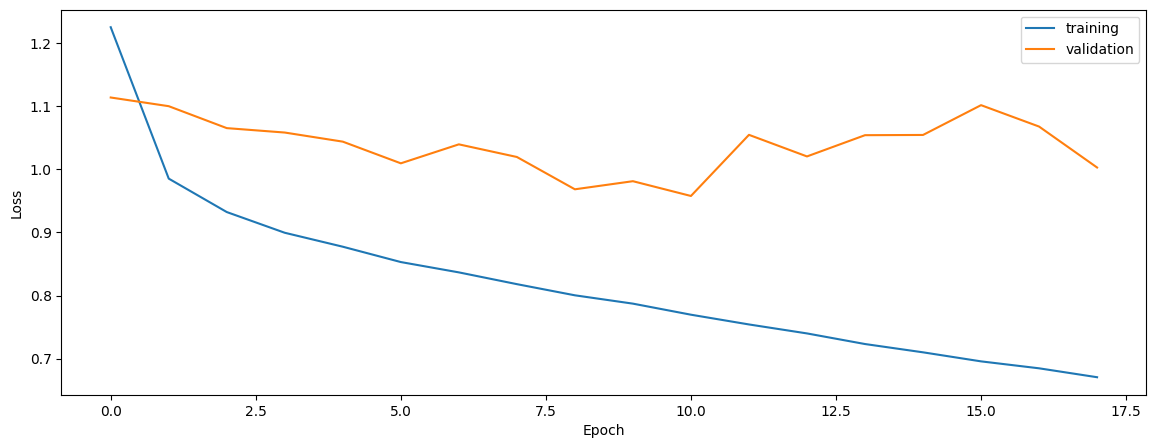

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['threshold'] = 0.6
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 828)
(1068345, 1)
validation
(123115, 828)
(123115, 1)
test
(152076, 828)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

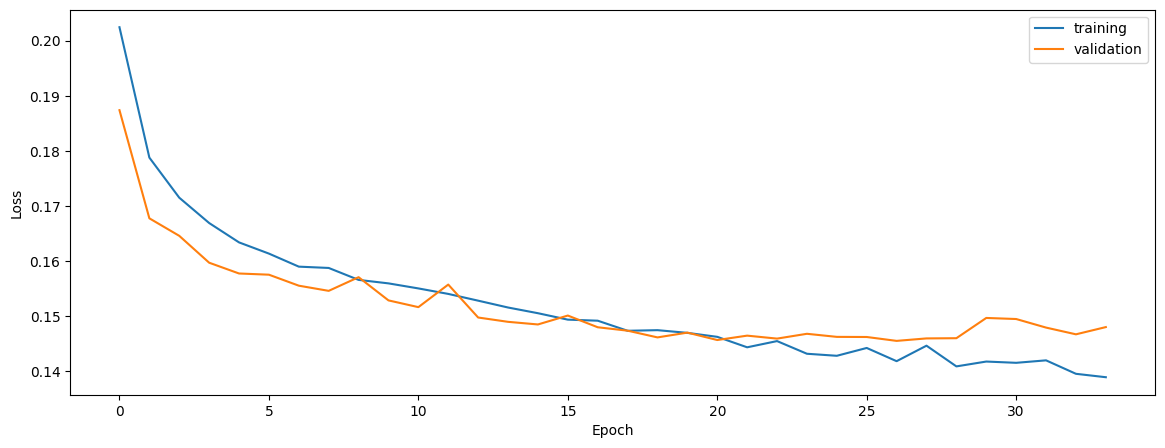

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['not_connected'] = True
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    not_connected = np.where(reg < threshold, 1, 0)
    not_connected = np.expand_dims(not_connected,-1)
    pred = np.concatenate([pred,not_connected],-1)
    for i in range(cla.shape[-1]):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6605551752985018
0.6504276032702238
0.6133022119453776


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6565851011601768
0.639564308504786
0.6173014970627251


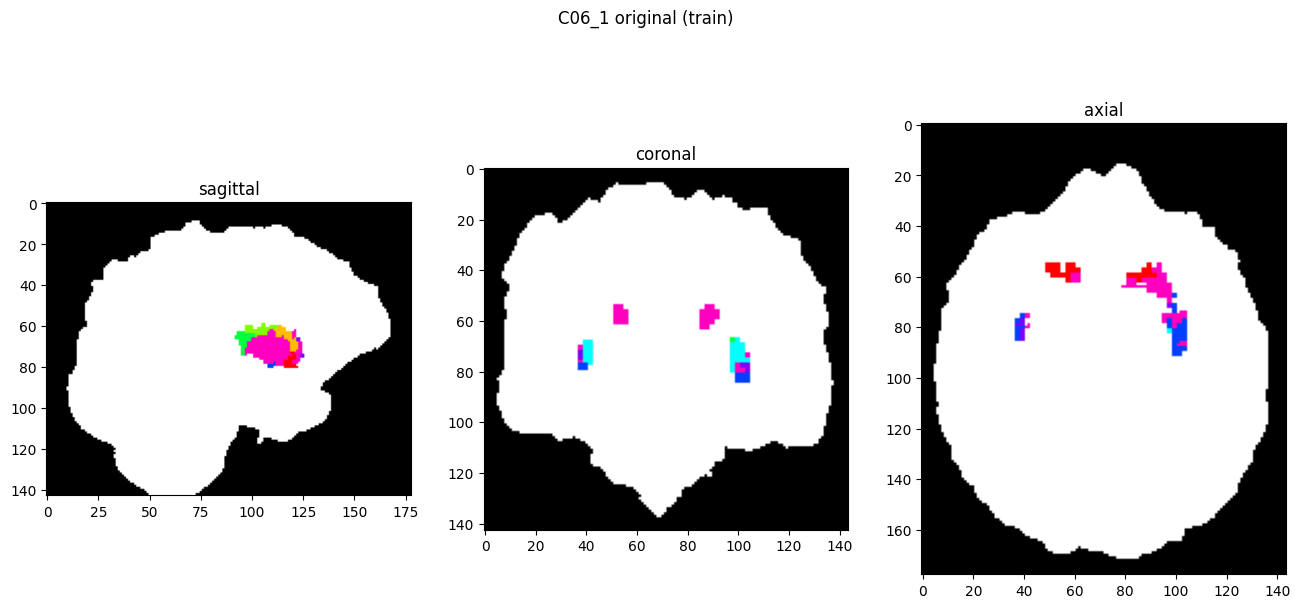

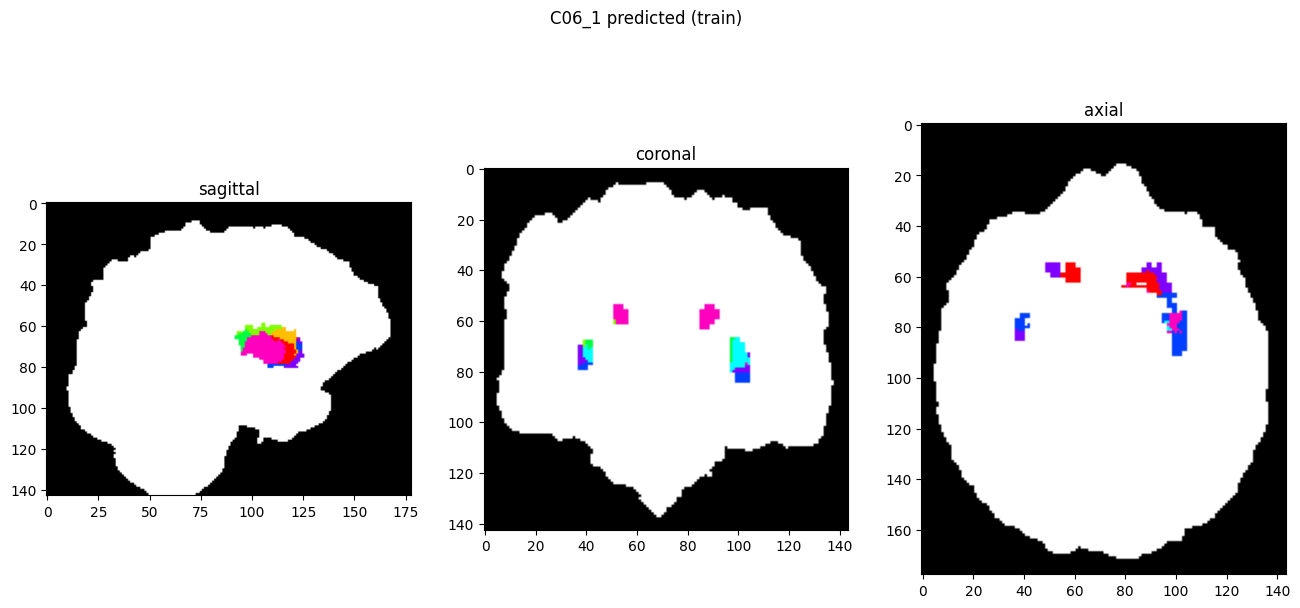

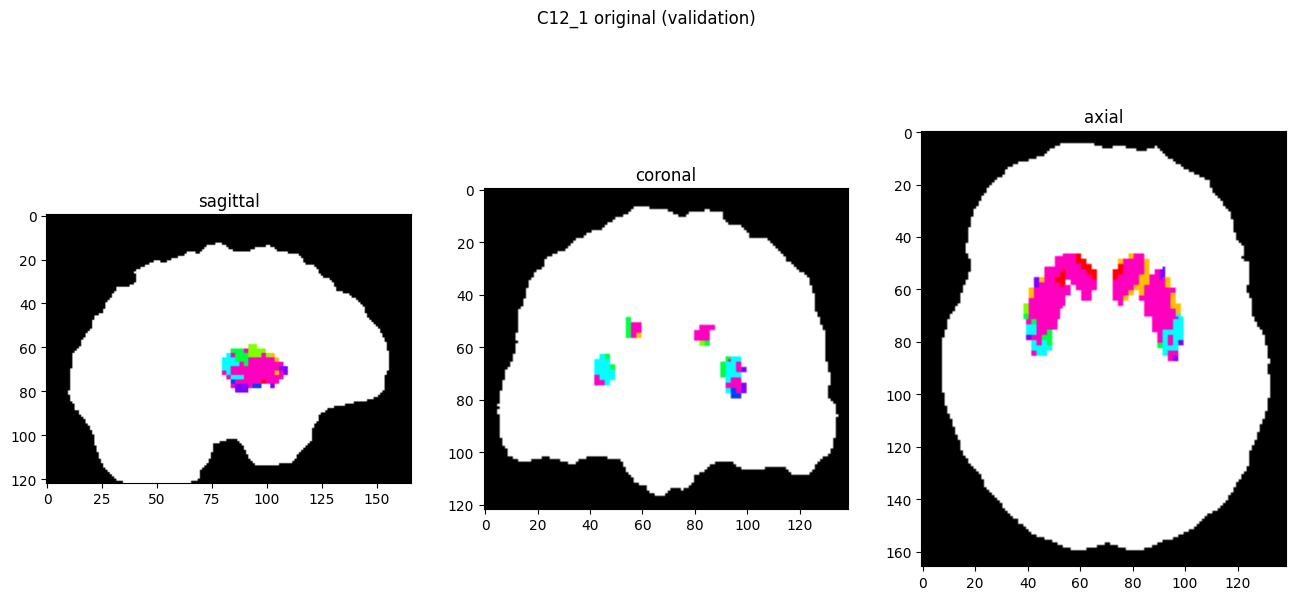

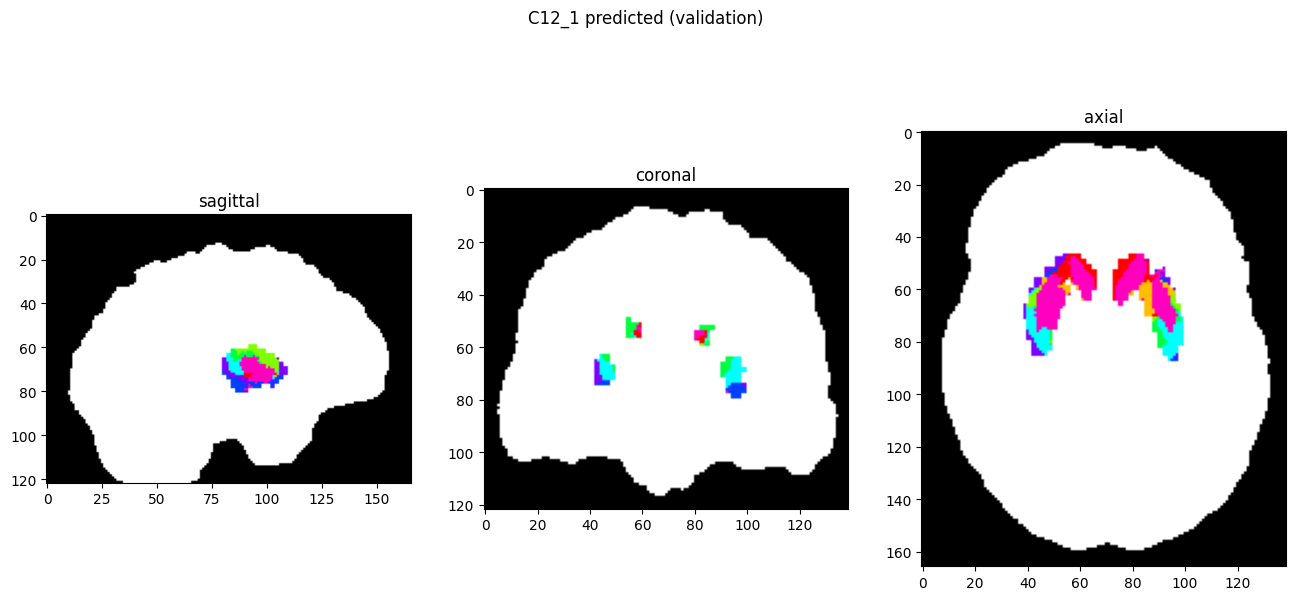

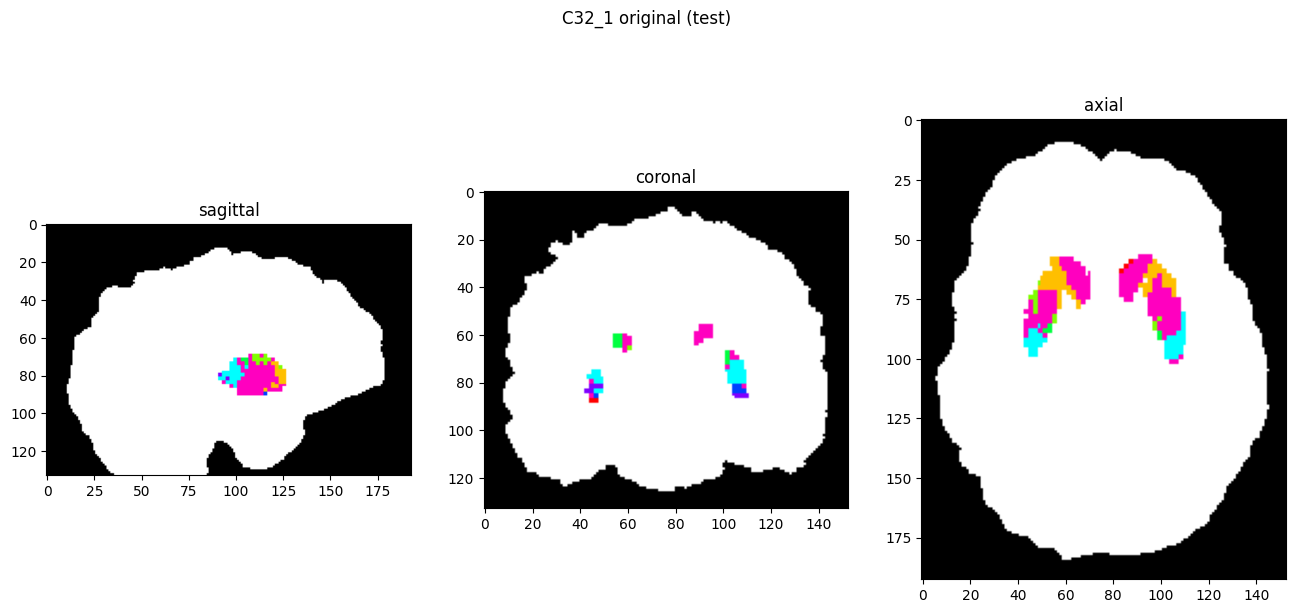

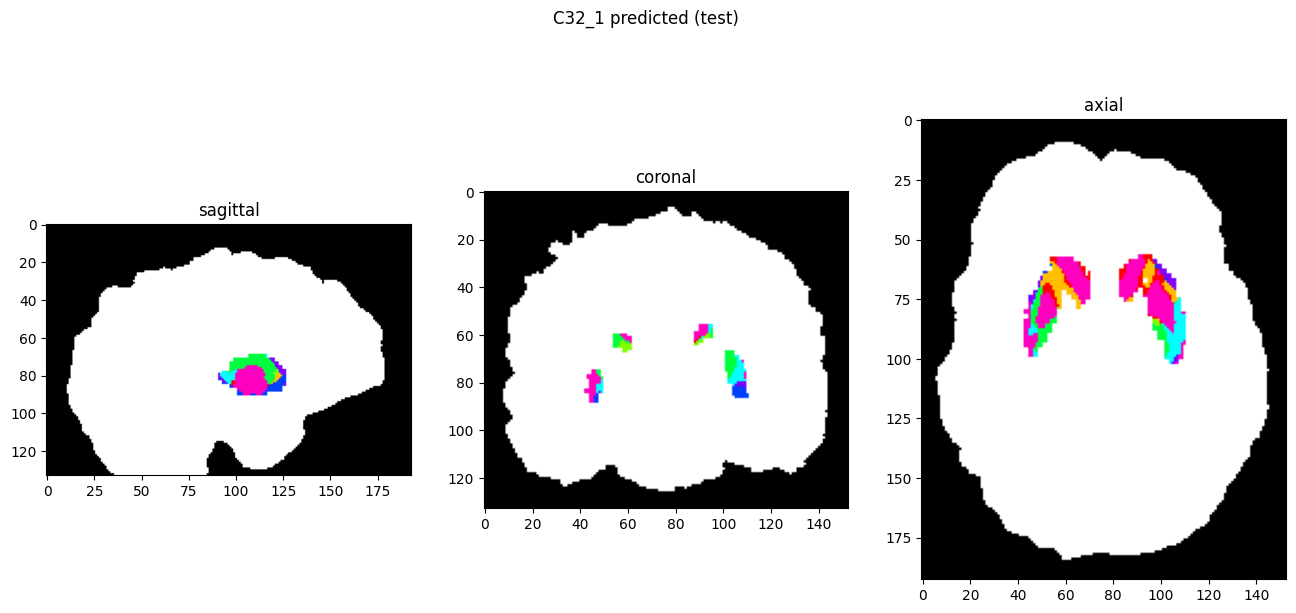

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)